In [547]:
%reload_ext autoreload
%autoreload 2

import requests
import matplotlib.pyplot as plt
import json
import csv
import os
import pandas as pd
import numpy as np

from fmp_python.fmp import FMP
from fmp_api_python.fmp import FMPClient

from xgbimputer import XGBImputer

import math
from scipy.stats import norm
from scipy import interpolate
from scipy.interpolate import UnivariateSpline
from scipy import signal  # wavelet denoising


import nest_asyncio
from aiohttp import ClientSession
import aiofiles
import aiohttp
import asyncio

from tqdm import tqdm

from skimage.restoration import (denoise_wavelet, estimate_sigma)

import miceforest as mf #miceforest imputation
import tensorflow as tf

import yfinance as yf

from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import missingno as msno # missingness plot


# VIX Data

In [391]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

vix=pd.read_csv('raw_data/VIX_History.csv')

vix

DATE   OPEN   HIGH    LOW  CLOSE
0     01/02/1990  17.24  17.24  17.24  17.24
1     01/03/1990  18.19  18.19  18.19  18.19
2     01/04/1990  19.22  19.22  19.22  19.22
3     01/05/1990  20.11  20.11  20.11  20.11
4     01/08/1990  20.26  20.26  20.26  20.26
...          ...    ...    ...    ...    ...
8332  01/25/2023  19.56  20.90  18.99  19.08
8333  01/26/2023  19.05  19.48  18.67  18.73
8334  01/27/2023  18.90  19.00  17.97  18.51
8335  01/30/2023  19.76  20.25  19.54  19.94
8336  01/31/2023  20.12  20.70  19.13  19.40

[8337 rows x 5 columns]

# JGB Yield Curves

In [4]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

japan_curves=pd.read_csv('raw_data/Yield Curves/jgbcme_all.csv')


In [5]:
japan_curves

Interest Rate Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4 Unnamed: 5  \
0              Date         1Y         2Y         3Y         4Y         5Y   
1         1974/9/24     10.327      9.362       8.83      8.515      8.348   
2         1974/9/25     10.333      9.364      8.831      8.516      8.348   
3         1974/9/26      10.34      9.366      8.832      8.516      8.348   
4         1974/9/27     10.347      9.367      8.833      8.517      8.349   
...             ...        ...        ...        ...        ...        ...   
12410     2023/1/25     -0.045      -0.01      0.004      0.083      0.189   
12411     2023/1/26     -0.055     -0.009      0.006      0.083      0.189   
12412     2023/1/27     -0.055      0.001      0.014      0.095        0.2   
12413     2023/1/30     -0.055     -0.004      0.011      0.087      0.187   
12414     2023/1/31     -0.055      -0.01      0.021      0.098      0.198   

      Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9 Unnamed: 10 Unnamed: 11  \
0             6Y         7Y         8Y         9Y         10Y         15Y   
1           8.29       8.24      8.121      8.127           -           -   
2           8.29       8.24      8.121      8.127           -           -   
3           8.29       8.24      8.122      8.128           -           -   
4           8.29       8.24      8.122      8.128           -           -   
...          ...        ...        ...        ...         ...         ...   
12410      0.257      0.317      0.424      0.415       0.457       1.001   
12411      0.252      0.311      0.429      0.432       0.483       1.021   
12412      0.283      0.364      0.485       0.51       0.497       1.087   
12413      0.273      0.361      0.472      0.493       0.497        1.09   
12414        0.3      0.398      0.514      0.535       0.511       1.114   

      Unnamed: 12 Unnamed: 13 Unnamed: 14 (Unit : %)  
0             20Y         25Y         30Y        40Y  
1               -           -           -          -  
2               -           -           -          -  
3               -           -           -          -  
4               -           -           -          -  
...           ...         ...         ...        ...  
12410       1.299       1.464       1.535       1.69  
12411       1.313        1.47       1.526      1.671  
12412       1.377       1.518       1.574      1.697  
12413       1.386       1.534       1.596      1.725  
12414       1.387       1.534         1.6      1.736  

[12415 rows x 16 columns]

# Euro Zone Yield Curves

In [6]:
## Read large kaggle quarterly FS file

os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")
data = pd.read_csv('quarterly.csv')

data

FileNotFoundError: [Errno 2] No such file or directory: 'quarterly.csv'

In [159]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

euro_curves=pd.read_csv('raw_data/Yield Curves/euro_yield_curves.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'raw_data/Yield Curves/euro_yield_curves.csv'

In [20]:
euro_curves

KEY FREQ REF_AREA CURRENCY  \
0        YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0    B       U2      EUR   
1        YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0    B       U2      EUR   
2        YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0    B       U2      EUR   
3        YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0    B       U2      EUR   
4        YC.B.U2.EUR.4F.G_N_C.SV_C_YM.BETA0    B       U2      EUR   
...                                     ...  ...      ...      ...   
5061955   YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2    B       U2      EUR   
5061956   YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2    B       U2      EUR   
5061957   YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2    B       U2      EUR   
5061958   YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2    B       U2      EUR   
5061959   YC.B.U2.EUR.4F.G_N_C.SV_C_YM.TAU2    B       U2      EUR   

        PROVIDER_FM INSTRUMENT_FM PROVIDER_FM_ID DATA_TYPE_FM TIME_PERIOD  \
0                4F         G_N_C        SV_C_YM        BETA0  2004-09-06   
1                4F         G_N_C        SV_C_YM        BETA0  2004-09-07   
2                4F         G_N_C        SV_C_YM        BETA0  2004-09-08   
3                4F         G_N_C        SV_C_YM        BETA0  2004-09-09   
4                4F         G_N_C        SV_C_YM        BETA0  2004-09-10   
...             ...           ...            ...          ...         ...   
5061955          4F         G_N_C        SV_C_YM         TAU2  2022-12-23   
5061956          4F         G_N_C        SV_C_YM         TAU2  2022-12-27   
5061957          4F         G_N_C        SV_C_YM         TAU2  2022-12-28   
5061958          4F         G_N_C        SV_C_YM         TAU2  2022-12-29   
5061959          4F         G_N_C        SV_C_YM         TAU2  2022-12-30   

         OBS_VALUE  ... UNIT_INDEX_BASE COMPILATION  COVERAGE  DECIMALS  \
0         5.441406  ...             NaN         NaN       NaN         6   
1         5.441406  ...             NaN         NaN       NaN         6   
2         5.425781  ...             NaN         NaN       NaN         6   
3         5.394531  ...             NaN         NaN       NaN         6   
4         5.363281  ...             NaN         NaN       NaN         6   
...            ...  ...             ...         ...       ...       ...   
5061955   0.624023  ...             NaN         NaN       NaN         6   
5061956   0.637207  ...             NaN         NaN       NaN         6   
5061957   0.636230  ...             NaN         NaN       NaN         6   
5061958   0.618652  ...             NaN         NaN       NaN         6   
5061959   0.634766  ...             NaN         NaN       NaN         6   

        SOURCE_AGENCY  SOURCE_PUB  \
0                 NaN         NaN   
1                 NaN         NaN   
2                 NaN         NaN   
3                 NaN         NaN   
4                 NaN         NaN   
...               ...         ...   
5061955           NaN         NaN   
5061956           NaN         NaN   
5061957           NaN         NaN   
5061958           NaN         NaN   
5061959           NaN         NaN   

                                                     TITLE  \
0        Yield curve parameters, Beta 0 - Government bo...   
1        Yield curve parameters, Beta 0 - Government bo...   
2        Yield curve parameters, Beta 0 - Government bo...   
3        Yield curve parameters, Beta 0 - Government bo...   
4        Yield curve parameters, Beta 0 - Government bo...   
...                                                    ...   
5061955  Yield curve parameters, Tau 2 - Government bon...   
5061956  Yield curve parameters, Tau 2 - Government bon...   
5061957  Yield curve parameters, Tau 2 - Government bon...   
5061958  Yield curve parameters, Tau 2 - Government bon...   
5061959  Yield curve parameters, Tau 2 - Government bon...   

                                               TITLE_COMPL       UNIT  \
0        Euro area (changing composition) - Government ...  PURE_NUMB   
1        Euro area (changing composit

#  Equity Closing Prices

In [392]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

equity_prices=pd.read_csv('raw_data/async_closing_prices.csv')

equity_prices.columns =['symbol', 'date', 'equity_price']  # name columns

equity_prices['date'] = pd.to_datetime(equity_prices.date) # convert to datetime format

equity_prices.set_index('date', inplace=True) # set date column as index

equity_prices


symbol  equity_price
date                                 
2023-04-27            A    133.250000
2023-04-26            A    133.120000
2023-04-25            A    130.370000
2023-04-24            A    138.480000
2023-04-21            A    138.500000
...                 ...           ...
1996-01-05  RELIANCE.NS     15.658285
1996-01-04  RELIANCE.NS     15.766594
1996-01-03  RELIANCE.NS     15.913584
1996-01-02  RELIANCE.NS     15.793671
1996-01-01  RELIANCE.NS     15.917452

[2771766 rows x 2 columns]

In [307]:
equity_prices[equity_prices['symbol'] ='RELIANCE.NS'].equity_price.plot()


SyntaxError: cannot assign to subscript here. Maybe you meant '==' instead of '='? (3789975945.py, line 1)

# Scrape highcharts sovereign CDS data from worldgovernmentbonds.com

In [ ]:
import pandas as pd

from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from tools.setups import get_local_safe_setup

if __name__ == "__main__":
    # Create local setup like here: https://gist.github.com/theDestI/aa21a0e721b06a74bd58a0a391d96e8f
    driver = get_local_safe_setup() 
    
		# Call url through selenium driver
    driver.get("https://www.worldweatheronline.com/brussels-weather-averages/be.aspx")

		# Wait until element with highcharts graph appears
    WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CLASS_NAME, "qc-cmp2-summary-section"))
    )

		# Parse dates and values in those dates
    dates = driver.execute_script('return Highcharts.charts[0].series[0].data.map(x => x.series).map(x => x.xData)[0].map(x => new Date(x).toISOString())')
    values = driver.execute_script('return Highcharts.charts[0].series[0].data.map(x => x.series).map(x => x.yData)[0]')

    df = pd.DataFrame({'Dates': dates, 'Temperatures': values })

		# Store to dataframe and save it in current folder
    df.to_csv('./output.csv', index=False)

		# Don't forget ot quit!
    driver.quit()

# Process Balance Sheet, Income Statement, Financial Ratios and Cashflow Data

## Clean and transform balance sheet

In [393]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

balance_sheet=pd.read_csv('raw_data/async_BS.csv')

balance_sheet

2023-01-31       A  USD  0001090872  2023-03-02 18:52:33  2023  Q2  \
0      2023-01-31       A  USD   1090872.0  2023-03-02 18:52:33  2023  Q1   
1      2022-10-31       A  USD   1090872.0  2022-12-20 18:42:30  2022  Q4   
2      2022-10-31       A  USD   1090872.0  2022-12-20 18:42:30  2023  Q1   
3      2022-07-31       A  USD   1090872.0  2022-08-31 18:53:26  2022  Q3   
4      2022-04-30       A  USD   1090872.0  2022-05-27 19:33:57  2022  Q2   
...           ...     ...  ...         ...                  ...   ...  ..   
43811  1994-09-30  WBC.AX  AUD         NaN  1994-09-29 20:00:00  1994  Q4   
43812  1993-09-30  WBC.AX  AUD         NaN  1993-09-29 20:00:00  1993  Q4   
43813  1992-09-30  WBC.AX  AUD         NaN  1992-09-29 20:00:00  1992  Q4   
43814  1991-09-30  WBC.AX  AUD         NaN  1991-09-29 20:00:00  1991  Q4   
43815  1990-09-30  WBC.AX  AUD         NaN  1990-09-29 20:00:00  1990  Q4   

         1250000000           0  1250000000.1  ...   -280000000    5345000000  \
0      1.250000e+09         0.0  1.250000e+09  ... -280000000.0  5.345000e+09   
1      1.053000e+09         0.0  1.053000e+09  ... -347000000.0  5.325000e+09   
2      1.053000e+09         0.0  1.053000e+09  ... -347000000.0  5.325000e+09   
3      1.071000e+09   6000000.0  1.077000e+09  ... -362000000.0  5.311000e+09   
4      1.186000e+09  21000000.0  1.207000e+09  ... -333000000.0  5.292000e+09   
...             ...         ...           ...  ...          ...           ...   
43811  1.077685e+09         0.0  1.077685e+09  ...          0.0  6.685405e+09   
43812  1.618374e+09         0.0  1.618374e+09  ...          0.0  6.915775e+09   
43813  1.253911e+10         0.0  1.253911e+10  ...          0.0  6.419166e+09   
43814  9.684783e+09         0.0  9.684783e+09  ...          0.0  5.688024e+09   
43815  1.069670e+10         0.0  1.069670e+10  ...          0.0  5.450933e+09   

         5609000000  5609000000.1  10919000000.1  0.9  10919000000.2  \
0      5.609000e+09  5.609000e+09   1.091900e+10    0   1.091900e+10   
1      5.305000e+09  5.305000e+09   1.053200e+10    0   1.053200e+10   
2      5.305000e+09  5.305000e+09   1.053200e+10    0   1.053200e+10   
3      5.091000e+09  5.091000e+09   1.048400e+10    0   1.048400e+10   
4      5.122000e+09  5.122000e+09   1.045500e+10    0   1.045500e+10   
...             ...           ...            ...  ...            ...   
43811  7.297480e+09  7.297480e+09   9.384779e+10    0   9.384779e+10   
43812  7.150216e+09  7.150216e+09   1.050208e+11    0   1.050208e+11   
43813  6.646616e+09  6.646616e+09   1.104521e+11    0   1.104521e+11   
43814  7.250530e+09  7.250530e+09   1.060991e+11    0   1.060991e+11   
43815  6.881740e+09  6.881740e+09   1.071595e+11    0   1.071595e+11   

              0.10    2971000000    1721000000  
0              0.0  2.971000e+09  1.721000e+09  
1              0.0  2.769000e+09  1.716000e+09  
2              0.0  2.769000e+09  1.716000e+09  
3      200000000.0  2.912000e+09  1.841000e+09  
4      211000000.0  2.905000e+09  1.719000e+09  
...            ...           ...           ...  
43811          0.0  5.530568e+09  4.452883e+09  
43812          0.0  6.776853e+09  5.158479e+09  
43813          0.0  6.746030e+09 -5.793083e+09  
43814          0.0  1.745335e+10  7.768568e+09  
43815          0.0  2.725660e+10  1.655990e+10  

[43816 rows x 51 columns]

In [394]:
balance_sheet.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'acceptedDate', 
                                             'calendarYear', 'period', 'cashAndCashEquivalents',
                                             'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
                                             'inventory', 'otherCurrentAssets', 'totalCurrentAssets',
                                             'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
                                             'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
                                             'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
                                             'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
                                             'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
                                             'longTermDebt', 'deferredRevenueNonCurrent',
                                             'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
                                             'totalNonCurrentLiabilities', 'otherLiabilities',
                                             'capitalLeaseObligations', 'totalLiabilities', 'preferredStock',
                                             'commonStock', 'retainedEarnings',
                                             'accumulatedOtherComprehensiveIncomeLoss',
                                             'othertotalStockholdersEquity', 'totalStockholdersEquity',
                                             'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
                                             'minorityInterest', 'totalLiabilitiesAndTotalEquity',
                                             'totalInvestments', 'totalDebt', 'netDebt']

balance_sheet['date']= pd.to_datetime(balance_sheet['date'])

balance_sheet.set_index('date', inplace=True)

balance_sheet

symbol reportedCurrency        cik         acceptedDate  \
date                                                                  
2023-01-31       A              USD  1090872.0  2023-03-02 18:52:33   
2022-10-31       A              USD  1090872.0  2022-12-20 18:42:30   
2022-10-31       A              USD  1090872.0  2022-12-20 18:42:30   
2022-07-31       A              USD  1090872.0  2022-08-31 18:53:26   
2022-04-30       A              USD  1090872.0  2022-05-27 19:33:57   
...            ...              ...        ...                  ...   
1994-09-30  WBC.AX              AUD        NaN  1994-09-29 20:00:00   
1993-09-30  WBC.AX              AUD        NaN  1993-09-29 20:00:00   
1992-09-30  WBC.AX              AUD        NaN  1992-09-29 20:00:00   
1991-09-30  WBC.AX              AUD        NaN  1991-09-29 20:00:00   
1990-09-30  WBC.AX              AUD        NaN  1990-09-29 20:00:00   

            calendarYear period  cashAndCashEquivalents  shortTermInvestments  \
date                                                                            
2023-01-31          2023     Q1            1.250000e+09                   0.0   
2022-10-31          2022     Q4            1.053000e+09                   0.0   
2022-10-31          2023     Q1            1.053000e+09                   0.0   
2022-07-31          2022     Q3            1.071000e+09             6000000.0   
2022-04-30          2022     Q2            1.186000e+09            21000000.0   
...                  ...    ...                     ...                   ...   
1994-09-30          1994     Q4            1.077685e+09                   0.0   
1993-09-30          1993     Q4            1.618374e+09                   0.0   
1992-09-30          1992     Q4            1.253911e+10                   0.0   
1991-09-30          1991     Q4            9.684783e+09                   0.0   
1990-09-30          1990     Q4            1.069670e+10                   0.0   

            cashAndShortTermInvestments  netReceivables  ...  \
date                                                     ...   
2023-01-31                 1.250000e+09    1.459000e+09  ...   
2022-10-31                 1.053000e+09    1.405000e+09  ...   
2022-10-31                 1.053000e+09    1.405000e+09  ...   
2022-07-31                 1.077000e+09    1.345000e+09  ...   
2022-04-30                 1.207000e+09    1.237000e+09  ...   
...                                 ...             ...  ...   
1994-09-30                 1.077685e+09    0.000000e+00  ...   
1993-09-30                 1.618374e+09    0.000000e+00  ...   
1992-09-30                 1.253911e+10    0.000000e+00  ...   
1991-09-30                 9.684783e+09    0.000000e+00  ...   
1990-09-30                 1.069670e+10    0.000000e+00  ...   

            accumulatedOtherComprehensiveIncomeLoss  \
date                                                  
2023-01-31                             -280000000.0   
2022-10-31                             -347000000.0   
2022-10-31                             -347000000.0   
2022-07-31                             -362000000.0   
2022-04-30                             -333000000.0   
...                                             ...   
1994-09-30                                      0.0   
1993-09-30                                      0.0   
1992-09-30                                      0.0   
1991-09-30                                      0.0   
1990-09-30                                      0.0   

            othertotalStockholdersEquity  totalStockholdersEquity  \
date                                                                
2023-01-31                  5.345000e+09             5.609000e+09   
2022-10-31                  5.325000e+09             5.305000e+09   
2022-10-31                  5.325000e+09             5.305000e+09   
2022-07-31                  5.311000e+09             5.091000e+09   
2022-04-30                  5.292000e+09             5.122000e+09   
..

## Understand characteristics and distribution of NaN and zero fields

In [241]:
balance_sheet.describe()

cik  calendarYear  cashAndCashEquivalents  \
count  3.164300e+04  43816.000000            4.381600e+04   
mean   5.901072e+05   2009.845376            2.707522e+11   
std    5.122480e+05      8.410816            3.072002e+12   
min    1.800000e+03   1985.000000           -3.130000e+07   
25%    6.270900e+04   2004.000000            2.438292e+08   
50%    7.327170e+05   2011.000000            1.181517e+09   
75%    1.018724e+06   2017.000000            5.567250e+09   
max    1.773383e+06   2023.000000            1.107632e+14   

       shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
count          4.381600e+04                 4.381600e+04    4.381600e+04   
mean           1.008503e+11                 3.715781e+11    8.580208e+10   
std            1.443180e+12                 3.879471e+12    7.676369e+11   
min           -2.160000e+08                -3.130000e+07   -3.200000e+07   
25%            0.000000e+00                 3.096000e+08    8.000000e+06   
50%            0.000000e+00                 1.581170e+09    9.801500e+08   
75%            5.631672e+08                 8.708000e+09    4.015560e+09   
max            5.884407e+13                 1.500985e+14    1.837100e+13   

          inventory  otherCurrentAssets  totalCurrentAssets  \
count  4.381600e+04        4.381600e+04        4.381600e+04   
mean   7.569834e+10       -8.307591e+12       -7.917848e+12   
std    6.736611e+11        1.306710e+15        1.306725e+15   
min    0.000000e+00       -2.264398e+17       -2.264398e+17   
25%    0.000000e+00        4.766900e+07        1.140742e+09   
50%    5.791983e+08        4.184955e+08        4.291667e+09   
75%    2.533000e+09        2.184000e+09        1.511044e+10   
max    1.835332e+13        1.256451e+14        1.990734e+14   

       propertyPlantEquipmentNet  ...  \
count               4.381600e+04  ...   
mean                6.285110e+11  ...   
std                 6.865207e+12  ...   
min                -2.361500e+10  ...   
25%                 1.013521e+09  ...   
50%                 3.776000e+09  ...   
75%                 1.381500e+10  ...   
max                 1.816610e+14  ...   

       accumulatedOtherComprehensiveIncomeLoss  othertotalStockholdersEquity  \
count                             4.381600e+04                  4.368900e+04   
mean                              1.133522e+10                  8.319889e+10   
std                               9.997908e+11                  1.374941e+12   
min                              -2.417901e+13                 -8.337300e+13   
25%                              -9.362500e+08                  0.000000e+00   
50%                              -1.650000e+07                  1.402000e+09   
75%                               0.000000e+00                  6.790200e+09   
max                               8.551500e+13                  7.569899e+13   

       totalStockholdersEquity   totalEquity  \
count             4.381600e+04  4.381600e+04   
mean              6.346607e+11  6.346607e+11   
std               4.881689e+12  4.881689e+12   
min              -1.142960e+11 -1.142960e+11   
25%               2.564788e+09  2.564788e+09   
50%               7.423000e+09  7.423000e+09   
75%               2.366500e+10  2.366500e+10   
max               1.277940e+14  1.277940e+14   

       totalLiabilitiesAndStockholdersEquity  minorityInterest  \
count                           4.381600e+04           43816.0   
mean                            2.806861e+12               0.0   
std                             2.017356e+13               0.0   
min                             0.000000e+00               0.0   
25%                             8.821425e+09               0.0   
50%                             2.589073e+10               0.0   
75%                             1.070150e+11               0.0   
max                             4.329429e+14               0.0   

       totalLiabilitiesAndTotalEquity  totalInvestments     totalDebt  \
count                

In [395]:
# Drop non numeric columns

balance_sheet=balance_sheet.drop(['cik', 'acceptedDate', 'calendarYear', 'period'], axis=1)

In [396]:
balance_sheet.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43816 entries, 2023-01-31 to 1990-09-30
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   symbol                                   43816 non-null  object 
 1   reportedCurrency                         43816 non-null  object 
 2   cashAndCashEquivalents                   43816 non-null  float64
 3   shortTermInvestments                     43816 non-null  float64
 4   cashAndShortTermInvestments              43816 non-null  float64
 5   netReceivables                           43816 non-null  float64
 6   inventory                                43816 non-null  float64
 7   otherCurrentAssets                       43816 non-null  float64
 8   totalCurrentAssets                       43816 non-null  float64
 9   propertyPlantEquipmentNet                43816 non-null  float64
 10  goodwill                     

In [397]:
# show all rows with totalAssets equals zero

balance_sheet_zero=balance_sheet.query("totalAssets == 0")

balance_sheet_zero

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                             
2010-09-30        AGR              USD            0.000000e+00   
2003-06-30       HSBC              USD            0.000000e+00   
2013-06-13       NRUC              USD            0.000000e+00   
2011-10-26       NRUC              USD            0.000000e+00   
2005-12-31        VOD              EUR            2.017901e+09   
2008-09-30        BTI              GBP            0.000000e+00   
2008-03-31        BTI              GBP            0.000000e+00   
2007-09-30        BTI              GBP            0.000000e+00   
2007-03-31        BTI              GBP            0.000000e+00   
2006-09-30        BTI              GBP            0.000000e+00   
2006-03-31        BTI              GBP            0.000000e+00   
2005-09-30        BTI              GBP            0.000000e+00   
2005-03-31        BTI              GBP            0.000000e+00   
2004-09-30        BTI              GBP            0.000000e+00   
2004-03-31        BTI              GBP            0.000000e+00   
2003-09-30        BTI              GBP            0.000000e+00   
2003-03-31        BTI              GBP            0.000000e+00   
2017-06-30        BKR              USD            4.133000e+09   
1994-09-30     CNQ.TO              CAD            0.000000e+00   
1994-06-30     CNQ.TO              CAD            0.000000e+00   
1994-03-31     CNQ.TO              CAD            0.000000e+00   
2021-12-31     O5G.DE              EUR            0.000000e+00   
2012-09-30      IAG.L              EUR            0.000000e+00   
2010-12-31  024110.KS              KRW            6.602803e+12   
2009-12-31  024110.KS              KRW            3.866048e+12   
2008-12-31  024110.KS              KRW            3.163986e+12   
2007-12-31  024110.KS              KRW            3.563601e+12   
2000-06-30     QBE.AX              AUD            3.016000e+08   
2011-09-30      RKT.L              GBP            0.000000e+00   
2011-03-31      RKT.L              GBP            0.000000e+00   
2010-09-30      RKT.L              GBP            0.000000e+00   
2010-03-31      RKT.L              GBP            0.000000e+00   
2009-09-30      RKT.L              GBP            0.000000e+00   
2009-03-31      RKT.L              GBP            0.000000e+00   
2008-09-30      RKT.L              GBP            0.000000e+00   
2008-03-31      RKT.L              GBP            0.000000e+00   
2007-09-30      RKT.L              GBP            0.000000e+00   
2022-09-30    SBIN.NS              INR            3.031799e+12   
1999-12-31     STO.AX              AUD            9.790000e+07   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2010-09-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2003-06-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2013-06-13          0.000000e+00                 0.000000e+00    0.000000e+00   
2011-10-26          0.000000e+00                 0.000000e+00    0.000000e+00   
2005-12-31          0.000000e+00                 2.017901e+09    0.000000e+00   
2008-09-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2008-03-31          0.000000e+00                 0.000000e+00    0.000000e+00   
2007-09-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2007-03-31          0.000000e+00                 0.000000e+00    0.000000e+00   
2006-09-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2006-03-31          0.000000e+00                 0.000000e+00    0.000000e+00   
2005-09-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2005-03-31          0.000000e+00                 0.000000e+00    0.000000e+00   
2004-09-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2004-03-31  

In [398]:
# Remove rows where total assets=0

BS_nonzero = balance_sheet[balance_sheet['totalAssets'] > 0]
BS_nonzero

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-07-31       A              USD            1.071000e+09   
2022-04-30       A              USD            1.186000e+09   
...            ...              ...                     ...   
1994-09-30  WBC.AX              AUD            1.077685e+09   
1993-09-30  WBC.AX              AUD            1.618374e+09   
1992-09-30  WBC.AX              AUD            1.253911e+10   
1991-09-30  WBC.AX              AUD            9.684783e+09   
1990-09-30  WBC.AX              AUD            1.069670e+10   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-07-31             6000000.0                 1.077000e+09    1.345000e+09   
2022-04-30            21000000.0                 1.207000e+09    1.237000e+09   
...                          ...                          ...             ...   
1994-09-30                   0.0                 1.077685e+09    0.000000e+00   
1993-09-30                   0.0                 1.618374e+09    0.000000e+00   
1992-09-30                   0.0                 1.253911e+10    0.000000e+00   
1991-09-30                   0.0                 9.684783e+09    0.000000e+00   
1990-09-30                   0.0                 1.069670e+10    0.000000e+00   

               inventory  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-07-31  1.010000e+09         258000000.0        3.690000e+09   
2022-04-30  9.370000e+08         262000000.0        3.643000e+09   
...                  ...                 ...                 ...   
1994-09-30  0.000000e+00                 0.0        0.000000e+00   
1993-09-30  0.000000e+00                 0.0        0.000000e+00   
1992-09-30  0.000000e+00                 0.0        0.000000e+00   
1991-09-30  0.000000e+00                 0.0        0.000000e+00   
1990-09-30  0.000000e+00                 0.0        0.000000e+00   

            propertyPlantEquipmentNet  ...  \
date                                   ...   
2023-01-31               1.147000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-07-31               1.054000e+09  ...   
2022-04-30               1.010000e+09  ...   
...                               ...  ...   
1994-09-30               1.737997e+09  ...   
1993-09-30               1.858571e+09  ...   
1992-09-30               2.217680e+09  ...   
1991-09-30               2.755522e+09  ...   
1990-09-30               2.805386e+09  ...   

            accumulatedOtherComprehensiveIncomeLoss  \
date                                                  
2023-01-31                             -280000000.0   
2022-10-31                             -347000000.0   
2022-10-31                             -347000000.0   
2022-07-31                             -362000000.0   
2022-04-30                             -333000000.0   
...                                             ...   
1994-09-30                                      0.0   
1993-09-30                                      0.0   
1992-09-30                                      0.0   
1991-09-30                                      0

In [399]:
# Remove rows where total assets=0

balance_sheet_cleaned=balance_sheet.drop(balance_sheet[balance_sheet['totalAssets'] == 0].index)

balance_sheet_cleaned

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-07-31       A              USD            1.071000e+09   
2022-04-30       A              USD            1.186000e+09   
...            ...              ...                     ...   
1995-09-30  WBC.AX              AUD            1.049361e+09   
1993-09-30  WBC.AX              AUD            1.618374e+09   
1992-09-30  WBC.AX              AUD            1.253911e+10   
1991-09-30  WBC.AX              AUD            9.684783e+09   
1990-09-30  WBC.AX              AUD            1.069670e+10   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-07-31             6000000.0                 1.077000e+09    1.345000e+09   
2022-04-30            21000000.0                 1.207000e+09    1.237000e+09   
...                          ...                          ...             ...   
1995-09-30                   0.0                 1.049361e+09    0.000000e+00   
1993-09-30                   0.0                 1.618374e+09    0.000000e+00   
1992-09-30                   0.0                 1.253911e+10    0.000000e+00   
1991-09-30                   0.0                 9.684783e+09    0.000000e+00   
1990-09-30                   0.0                 1.069670e+10    0.000000e+00   

               inventory  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09        2.580000e+08        4.078000e+09   
2022-10-31  1.038000e+09        2.820000e+08        3.778000e+09   
2022-10-31  1.038000e+09        2.820000e+08        3.778000e+09   
2022-07-31  1.010000e+09        2.580000e+08        3.690000e+09   
2022-04-30  9.370000e+08        2.620000e+08        3.643000e+09   
...                  ...                 ...                 ...   
1995-09-30  0.000000e+00        1.030819e+11        1.041313e+11   
1993-09-30  0.000000e+00        0.000000e+00        0.000000e+00   
1992-09-30  0.000000e+00        0.000000e+00        0.000000e+00   
1991-09-30  0.000000e+00        0.000000e+00        0.000000e+00   
1990-09-30  0.000000e+00        0.000000e+00        0.000000e+00   

            propertyPlantEquipmentNet  ...  \
date                                   ...   
2023-01-31               1.147000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-07-31               1.054000e+09  ...   
2022-04-30               1.010000e+09  ...   
...                               ...  ...   
1995-09-30               1.629090e+09  ...   
1993-09-30               1.858571e+09  ...   
1992-09-30               2.217680e+09  ...   
1991-09-30               2.755522e+09  ...   
1990-09-30               2.805386e+09  ...   

            accumulatedOtherComprehensiveIncomeLoss  \
date                                                  
2023-01-31                             -280000000.0   
2022-10-31                             -347000000.0   
2022-10-31                             -347000000.0   
2022-07-31                             -362000000.0   
2022-04-30                             -333000000.0   
...                                             ...   
1995-09-30                                      0.0   
1993-09-30                                      0.0   
1992-09-30                                      0.0   
1991-09-30                                      0

In [400]:
# Determine missing balance sheet fields

balance_sheet_cleaned.isnull().sum().sort_values(ascending=False)/len(balance_sheet_cleaned)

othertotalStockholdersEquity               0.002351
symbol                                     0.000000
commonStock                                0.000000
longTermDebt                               0.000000
deferredRevenueNonCurrent                  0.000000
deferredTaxLiabilitiesNonCurrent           0.000000
otherNonCurrentLiabilities                 0.000000
totalNonCurrentLiabilities                 0.000000
otherLiabilities                           0.000000
capitalLeaseObligations                    0.000000
totalLiabilities                           0.000000
preferredStock                             0.000000
retainedEarnings                           0.000000
reportedCurrency                           0.000000
accumulatedOtherComprehensiveIncomeLoss    0.000000
totalStockholdersEquity                    0.000000
totalEquity                                0.000000
totalLiabilitiesAndStockholdersEquity      0.000000
minorityInterest                           0.000000
totalLiabili

<AxesSubplot:>

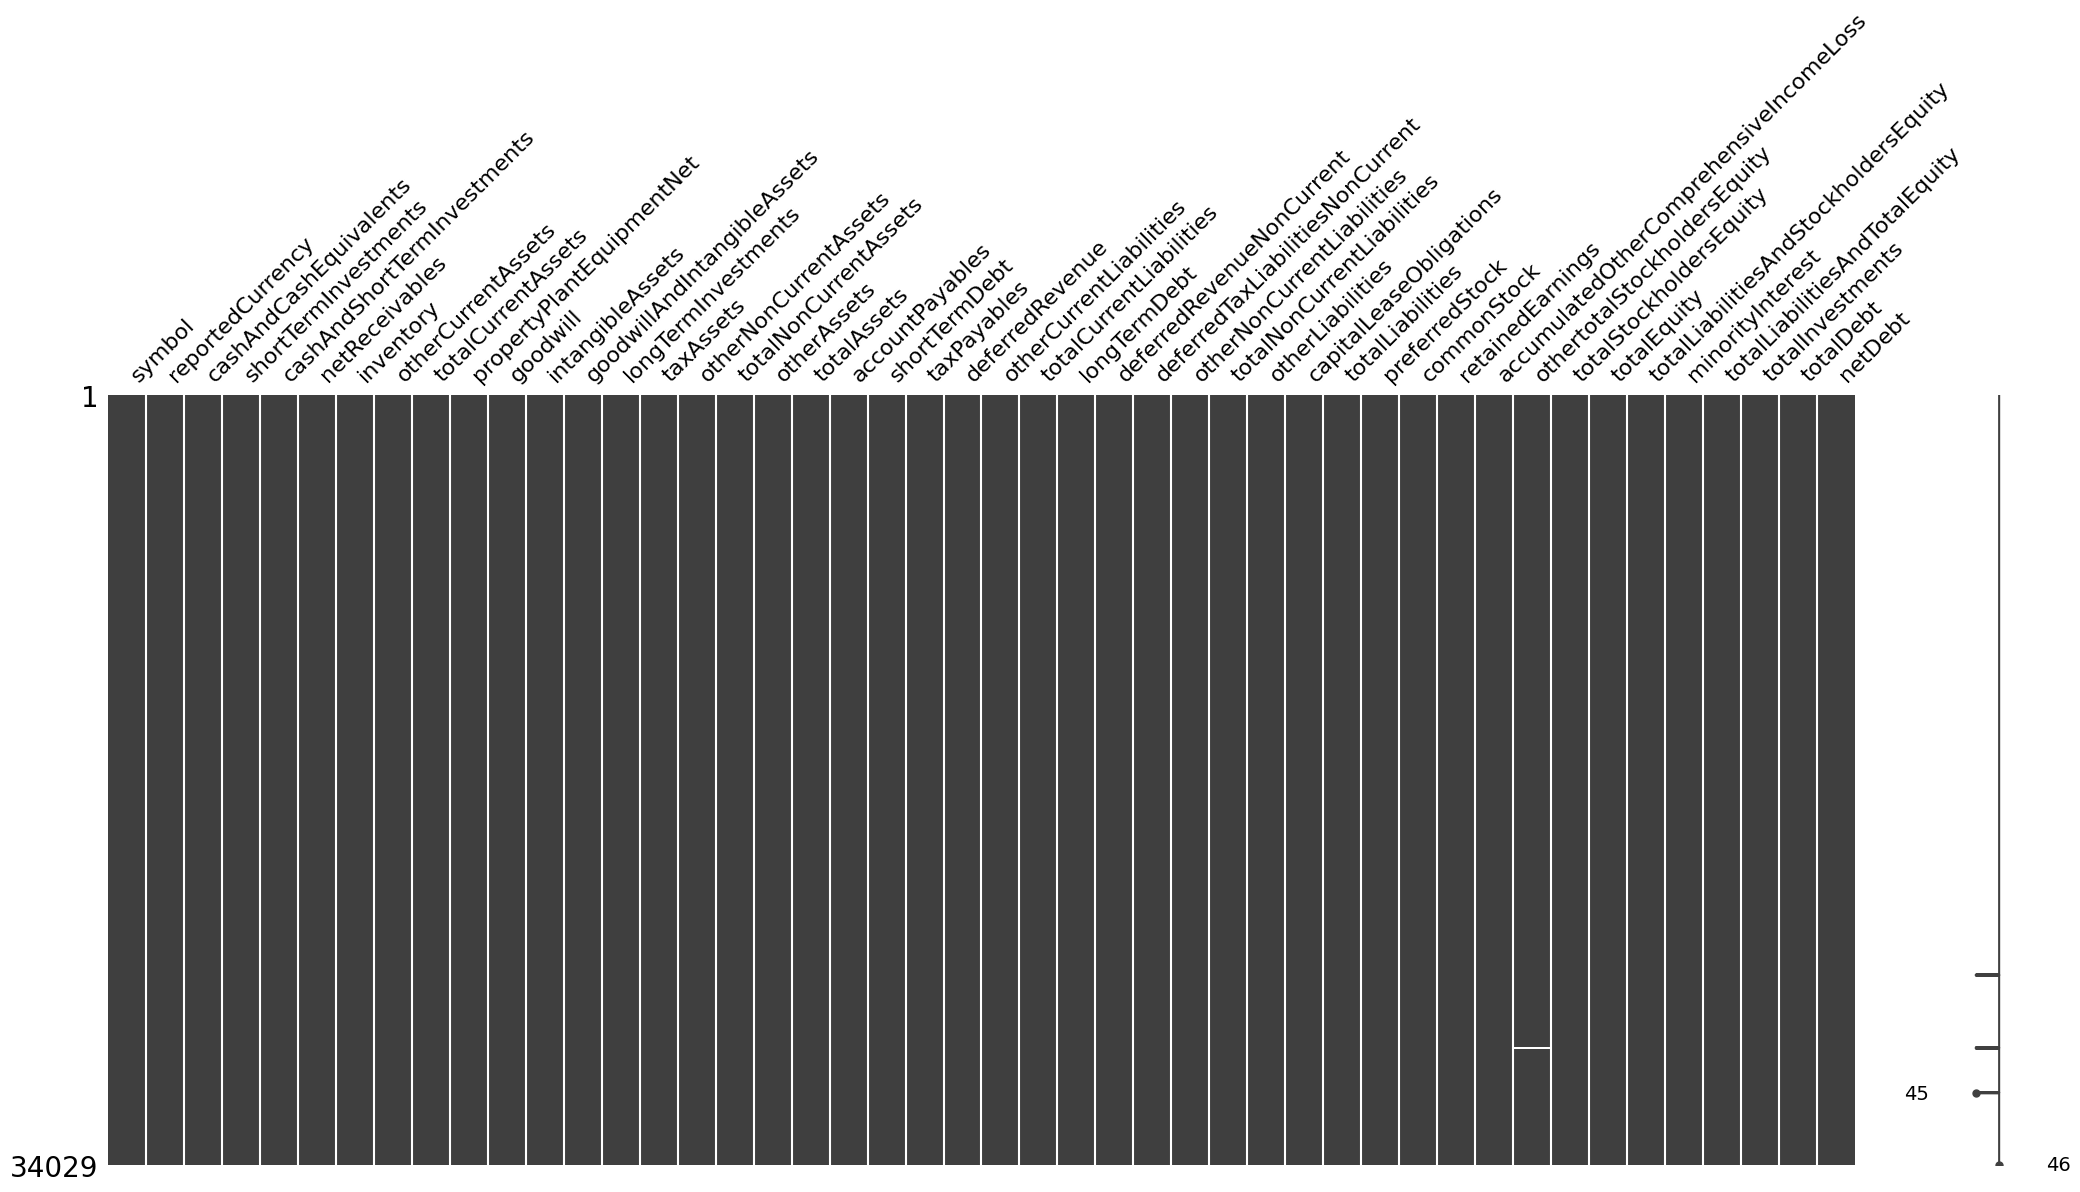

In [401]:
# Heatmap of missing fields

msno.matrix(balance_sheet_cleaned)

In [402]:
# Define missing values
# Use .loc to return values of cells matching condition

BS_missing_data = pd.DataFrame(balance_sheet_cleaned.isna().sum().loc[balance_sheet_cleaned.isna().sum() > 0], columns=['missing_data_count'])
BS_missing_data['missing_data_type'] = balance_sheet_cleaned.dtypes
BS_missing_data['missing_data_percentage'] = BS_missing_data['missing_data_count'] / len(balance_sheet)
BS_missing_data = BS_missing_data.sort_values(by='missing_data_percentage', ascending=False)
BS_missing_data

missing_data_count missing_data_type  \
othertotalStockholdersEquity                  80           float64   

                              missing_data_percentage  
othertotalStockholdersEquity                 0.001826

In [403]:
# Show all rows with missing values in 'othertotalStockholdersEquity' column

balance_sheet_cleaned[balance_sheet_cleaned['othertotalStockholdersEquity'].isna()]

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                           
2020-03-31  0883.HK              CNY            6.004750e+09   
2019-03-31  0883.HK              CNY            8.419750e+09   
2018-03-31  0883.HK              CNY            3.608000e+09   
2017-03-31  0883.HK              CNY            3.143000e+09   
2016-03-31  0883.HK              CNY            3.433750e+09   
...             ...              ...                     ...   
2003-01-31    RI.PA              EUR            3.810000e+07   
2002-09-30    RI.PA              EUR            2.235000e+07   
2002-06-30    RI.PA              EUR            2.235000e+07   
2002-03-31    RI.PA              EUR            2.235000e+07   
2002-01-31    RI.PA              EUR            2.235000e+07   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2020-03-31          2.586850e+10                 3.187325e+10    4.930750e+09   
2019-03-31          3.284200e+10                 4.126175e+10    6.326500e+09   
2018-03-31          3.476075e+10                 3.836875e+10    5.780000e+09   
2017-03-31          2.243450e+10                 2.557750e+10    5.325000e+09   
2016-03-31          1.743350e+10                 2.086725e+10    5.865500e+09   
...                          ...                          ...             ...   
2003-01-31          0.000000e+00                 3.810000e+07    0.000000e+00   
2002-09-30          0.000000e+00                 2.235000e+07    0.000000e+00   
2002-06-30          0.000000e+00                 2.235000e+07    0.000000e+00   
2002-03-31          0.000000e+00                 2.235000e+07    0.000000e+00   
2002-01-31          0.000000e+00                 2.235000e+07    0.000000e+00   

               inventory  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2020-03-31  1.411000e+09        2.632750e+09        4.084775e+10   
2019-03-31  1.578500e+09        2.319500e+09        5.148625e+10   
2018-03-31  1.463000e+09        1.908750e+09        4.752050e+10   
2017-03-31  1.838500e+09        1.968500e+09        3.470950e+10   
2016-03-31  2.177250e+09        1.601250e+09        3.051125e+10   
...                  ...                 ...                 ...   
2003-01-31  5.068250e+08        0.000000e+00        0.000000e+00   
2002-09-30  5.263750e+08        0.000000e+00        0.000000e+00   
2002-06-30  5.263750e+08        0.000000e+00        0.000000e+00   
2002-03-31  5.263750e+08        0.000000e+00        0.000000e+00   
2002-01-31  5.263750e+08        0.000000e+00        0.000000e+00   

            propertyPlantEquipmentNet  ...  \
date                                   ...   
2020-03-31               1.139572e+11  ...   
2019-03-31               1.124332e+11  ...   
2018-03-31               1.018342e+11  ...   
2017-03-31               9.896700e+10  ...   
2016-03-31               1.082015e+11  ...   
...                               ...  ...   
2003-01-31               2.054000e+08  ...   
2002-09-30               2.049250e+08  ...   
2002-06-30               2.049250e+08  ...   
2002-03-31               2.049250e+08  ...   
2002-01-31               2.049250e+08  ...   

            accumulatedOtherComprehensiveIncomeLoss  \
date                                                  
2020-03-31                            -1.651722e+11   
2019-03-31                            -1.556722e+11   
2018-03-31                            -1.408590e+11   
2017-03-31                            -1.244675e+11   
2016-03-31                            -1.105562e+11   
...                                             ...   
2003-01-31                             0.000000e+00   
2002-09-30                             0.000000e+00   
2002-06-30                             0.000000e+00   
2002-03-31                           

## Income Statement

In [404]:
# read in individual tickers

list=pd.read_csv('raw_data/concatenated_list_latest.csv')

stocks=list['Ticker'].to_list()

stocks

['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ADM',
 'ADP',
 'AES',
 'AET',
 'AFG',
 'AGR',
 'AIG',
 'ALL',
 'ALLY',
 'AMAT',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'APD',
 'ARW',
 'ASML',
 'AVB',
 'AVT',
 'AVY',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BABA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BIDU',
 'BK',
 'BLL',
 'BMO',
 'BMY',
 'BNS',
 'BSX',
 'BWA',
 'C',
 'CAG',
 'CAH',
 'CAR',
 'CAT',
 'CB',
 'CCB',
 'CCI',
 'CI',
 'CL',
 'CLX',
 'CM',
 'CMCSA',
 'CMI',
 'CNA',
 'CNHI',
 'CNP',
 'COF',
 'COP',
 'COST',
 'CPB',
 'CPT',
 'CS',
 'CSCO',
 'CSTM',
 'CSX',
 'CTVA',
 'CVS',
 'CVX',
 'D',
 'DAL',
 'DB',
 'DE',
 'DGX',
 'DHI',
 'DHR',
 'DOV',
 'DOW',
 'DRI',
 'DSM',
 'DT',
 'DTE',
 'DVN',
 'DXC',
 'ED',
 'EDF',
 'EMN',
 'EMR',
 'EOG',
 'EQIX',
 'EQNR',
 'ET',
 'ETN',
 'ETR',
 'EXPE',
 'F',
 'FDX',
 'FIS',
 'FISV',
 'FLEX',
 'FRT',
 'FTI',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GM',
 'GP',
 'GS',
 'GSK',
 'GT',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HIG',
 'HON',
 'HPQ',
 'HRB',
 'HSBC',
 'HS

In [405]:
income_statement=pd.read_csv('raw_data/async_IS.csv')

income_statement

2023-01-31       A  USD  0001090872  2023  Q2    1756000000  \
0      2023-01-31       A  USD   1090872.0  2023  Q1  1.756000e+09   
1      2022-10-31       A  USD   1090872.0  2022  Q4  1.849000e+09   
2      2022-10-31       A  USD   1090872.0  2023  Q1  1.849000e+09   
3      2022-07-31       A  USD   1090872.0  2022  Q3  1.718000e+09   
4      2022-04-30       A  USD   1090872.0  2022  Q2  1.607000e+09   
...           ...     ...  ...         ...   ...  ..           ...   
52317  1991-12-31  WBC.AX  AUD         NaN  1992  Q1  0.000000e+00   
52318  1990-12-31  WBC.AX  AUD         NaN  1991  Q1  0.000000e+00   
52319  1989-12-31  WBC.AX  AUD         NaN  1990  Q1  0.000000e+00   
52320  1988-12-31  WBC.AX  AUD         NaN  1989  Q1  0.000000e+00   
52321  1988-03-31  WBC.AX  AUD         NaN  1988  Q2  0.000000e+00   

         788000000     968000000  0.55125284738041  ...  0.23348519362186787  \
0      788000000.0  9.680000e+08          0.551253  ...             0.233485   
1      837000000.0  1.012000e+09          0.547323  ...             0.246079   
2      837000000.0  1.012000e+09          0.547323  ...             0.246079   
3      779000000.0  9.390000e+08          0.546566  ...             0.231083   
4      746000000.0  8.610000e+08          0.535781  ...             0.207218   
...            ...           ...               ...  ...                  ...   
52317          0.0  0.000000e+00          0.000000  ...             0.000000   
52318          0.0  0.000000e+00          0.000000  ...             0.000000   
52319          0.0  0.000000e+00          0.000000  ...             0.000000   
52320          0.0  0.000000e+00          0.000000  ...             0.000000   
52321          0.0  0.000000e+00          0.000000  ...             0.000000   

         58000000    352000000  0.20045558086560364      1.19    1.19.1  \
0      58000000.0  352000000.0             0.200456  1.190000  1.190000   
1      87000000.0  368000000.0             0.199027  1.240000  1.230000   
2      87000000.0  368000000.0             0.199027  1.240000  1.230000   
3      68000000.0  329000000.0             0.191502  1.100000  1.100000   
4      59000000.0  274000000.0             0.170504  0.920000  0.910000   
...           ...          ...                  ...       ...       ...   
52317         0.0 -366305480.0             0.000000 -0.206409 -0.206409   
52318         0.0          0.0             0.000000  0.095231  0.095231   
52319         0.0          0.0             0.000000  0.166169  0.166169   
52320         0.0          0.0             0.000000  0.201700  0.201700   
52321         0.0          0.0             0.000000  0.207008  0.207008   

          296000000     297000000  \
0      2.960000e+08  2.970000e+08   
1      2.960000e+08  2.980000e+08   
2      2.960000e+08  2.980000e+08   
3      2.980000e+08  2.990000e+08   
4      2.990000e+08  3.010000e+08   
...             ...           ...   
52317  1.234180e+09  1.234180e+09   
52318  1.136867e+09  1.136867e+09   
52319  1.064317e+09  1.064317e+09   
52320  1.064317e+09  1.064317e+09   
52321  1.064317e+09  1.064317e+09   

       https://www.sec.gov/Archives/edgar/data/1090872/000109087223000005/0001090872-23-000005-index.htm  \
0      https://www.sec.gov/Archives/edgar/data/109087...                                                   
1      https://www.sec.gov/Archives/edgar/data/109087...                                                   
2      https://www.sec.gov/Archives/edgar/data/109087...                                                   
3      https://www.sec.gov/Archives/edgar/data/109087...                                                   
4      https://www.sec.gov/Archives/edgar/data/109087...                                                   
...                                                  ...                                                   
52317                                                NaN                                               

In [406]:
income_statement.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
                           'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses', 
                           'sellingAndMarketingExpenses', 'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
                           'operatingExpenses', 'costAndExpenses', 'interestIncome', 'interestExpense', 'depreciationAndAmortization', 
                           'ebitda', 'ebitdaratio', 'operatingIncome', 'operatingIncomeRatio', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
                           'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome', 'netIncomeRatio', 'eps', 'epsdiluted',
                           'weightedAverageShsOut', 'weightedAverageShsOutDil', 'link', 'finalLink']

income_statement['date']= pd.to_datetime(income_statement['date'])

income_statement.set_index('date', inplace=True)

income_statement

symbol reportedCurrency        cik  calendarYear period  \
date                                                                  
2023-01-31       A              USD  1090872.0          2023     Q1   
2022-10-31       A              USD  1090872.0          2022     Q4   
2022-10-31       A              USD  1090872.0          2023     Q1   
2022-07-31       A              USD  1090872.0          2022     Q3   
2022-04-30       A              USD  1090872.0          2022     Q2   
...            ...              ...        ...           ...    ...   
1991-12-31  WBC.AX              AUD        NaN          1992     Q1   
1990-12-31  WBC.AX              AUD        NaN          1991     Q1   
1989-12-31  WBC.AX              AUD        NaN          1990     Q1   
1988-12-31  WBC.AX              AUD        NaN          1989     Q1   
1988-03-31  WBC.AX              AUD        NaN          1988     Q2   

                 revenue  costOfRevenue   grossProfit  grossProfitRatio  \
date                                                                      
2023-01-31  1.756000e+09    788000000.0  9.680000e+08          0.551253   
2022-10-31  1.849000e+09    837000000.0  1.012000e+09          0.547323   
2022-10-31  1.849000e+09    837000000.0  1.012000e+09          0.547323   
2022-07-31  1.718000e+09    779000000.0  9.390000e+08          0.546566   
2022-04-30  1.607000e+09    746000000.0  8.610000e+08          0.535781   
...                  ...            ...           ...               ...   
1991-12-31  0.000000e+00            0.0  0.000000e+00          0.000000   
1990-12-31  0.000000e+00            0.0  0.000000e+00          0.000000   
1989-12-31  0.000000e+00            0.0  0.000000e+00          0.000000   
1988-12-31  0.000000e+00            0.0  0.000000e+00          0.000000   
1988-03-31  0.000000e+00            0.0  0.000000e+00          0.000000   

            researchAndDevelopmentExpenses  ...  incomeBeforeTaxRatio  \
date                                        ...                         
2023-01-31                     123000000.0  ...              0.233485   
2022-10-31                     119000000.0  ...              0.246079   
2022-10-31                     119000000.0  ...              0.246079   
2022-07-31                     116000000.0  ...              0.231083   
2022-04-30                     115000000.0  ...              0.207218   
...                                    ...  ...                   ...   
1991-12-31                             0.0  ...              0.000000   
1990-12-31                             0.0  ...              0.000000   
1989-12-31                             0.0  ...              0.000000   
1988-12-31                             0.0  ...              0.000000   
1988-03-31                             0.0  ...              0.000000   

            incomeTaxExpense    netIncome  netIncomeRatio       eps  \
date                                                                  
2023-01-31        58000000.0  352000000.0        0.200456  1.190000   
2022-10-31        87000000.0  368000000.0        0.199027  1.240000   
2022-10-31        87000000.0  368000000.0        0.199027  1.240000   
2022-07-31        68000000.0  329000000.0        0.191502  1.100000   
2022-04-30        59000000.0  274000000.0        0.170504  0.920000   
...                      ...          ...             ...       ...   
1991-12-31               0.0 -366305480.0        0.000000 -0.206409   
1990-12-31               0.0          0.0        0.000000  0.095231   
1989-12-31               0.0          0.0        0.000000  0.166169   
1988-12-31               0.0          0.0        0.000000  0.201700   
1988-03-31               0.0          0.0        0.000000  0.207008   

            epsdiluted  weightedAverageShsOut  weightedAverageShsOutDil  \
date                                                                      
2023-01-31    1.190000           2.960000e+08              2.970000e+08   
2022-10-31   

In [407]:
# Drop columns

income_statement=income_statement.drop(['cik', 'calendarYear', 'period', 'link', 'finalLink'], axis=1)

In [408]:
income_statement.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52322 entries, 2023-01-31 to 1988-03-31
Data columns (total 30 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   symbol                                   52322 non-null  object 
 1   reportedCurrency                         52322 non-null  object 
 2   revenue                                  52322 non-null  float64
 3   costOfRevenue                            52322 non-null  float64
 4   grossProfit                              52322 non-null  float64
 5   grossProfitRatio                         52322 non-null  float64
 6   researchAndDevelopmentExpenses           52322 non-null  float64
 7   generalAndAdministrativeExpenses         52322 non-null  float64
 8   sellingAndMarketingExpenses              52322 non-null  float64
 9   sellingGeneralAndAdministrativeExpenses  52322 non-null  float64
 10  otherExpenses                

In [409]:
income_statement[(income_statement['revenue']==0)].count()

symbol                                     1318
reportedCurrency                           1318
revenue                                    1318
costOfRevenue                              1318
grossProfit                                1318
grossProfitRatio                           1318
researchAndDevelopmentExpenses             1318
generalAndAdministrativeExpenses           1318
sellingAndMarketingExpenses                1318
sellingGeneralAndAdministrativeExpenses    1318
otherExpenses                              1318
operatingExpenses                          1318
costAndExpenses                            1318
interestIncome                             1179
interestExpense                            1318
depreciationAndAmortization                1318
ebitda                                     1318
ebitdaratio                                1318
operatingIncome                            1318
operatingIncomeRatio                       1318
totalOtherIncomeExpensesNet             

In [410]:
# Filter all rows with zero revenue

income_statement_zero=income_statement.query("revenue == 0")

income_statement_zero

symbol reportedCurrency  revenue  costOfRevenue  grossProfit  \
date                                                                       
2021-03-26     AMP              USD      0.0            0.0          0.0   
1989-03-31     AXP              USD      0.0            0.0          0.0   
1988-03-31     AXP              USD      0.0            0.0          0.0   
1987-03-31     AXP              USD      0.0            0.0          0.0   
1986-03-31     AXP              USD      0.0            0.0          0.0   
...            ...              ...      ...            ...          ...   
1991-12-31  WBC.AX              AUD      0.0            0.0          0.0   
1990-12-31  WBC.AX              AUD      0.0            0.0          0.0   
1989-12-31  WBC.AX              AUD      0.0            0.0          0.0   
1988-12-31  WBC.AX              AUD      0.0            0.0          0.0   
1988-03-31  WBC.AX              AUD      0.0            0.0          0.0   

            grossProfitRatio  researchAndDevelopmentExpenses  \
date                                                           
2021-03-26               0.0                             0.0   
1989-03-31               0.0                             0.0   
1988-03-31               0.0                             0.0   
1987-03-31               0.0                             0.0   
1986-03-31               0.0                             0.0   
...                      ...                             ...   
1991-12-31               0.0                             0.0   
1990-12-31               0.0                             0.0   
1989-12-31               0.0                             0.0   
1988-12-31               0.0                             0.0   
1988-03-31               0.0                             0.0   

            generalAndAdministrativeExpenses  sellingAndMarketingExpenses  \
date                                                                        
2021-03-26                               0.0                          0.0   
1989-03-31                               0.0                          0.0   
1988-03-31                               0.0                          0.0   
1987-03-31                               0.0                          0.0   
1986-03-31                               0.0                          0.0   
...                                      ...                          ...   
1991-12-31                               0.0                          0.0   
1990-12-31                               0.0                          0.0   
1989-12-31                               0.0                          0.0   
1988-12-31                               0.0                          0.0   
1988-03-31                               0.0                          0.0   

            sellingGeneralAndAdministrativeExpenses  ...  \
date                                                 ...   
2021-03-26                             1.998000e+09  ...   
1989-03-31                             0.000000e+00  ...   
1988-03-31                             0.000000e+00  ...   
1987-03-31                             0.000000e+00  ...   
1986-03-31                             0.000000e+00  ...   
...                                             ...  ...   
1991-12-31                             0.000000e+00  ...   
1990-12-31                             0.000000e+00  ...   
1989-12-31                             0.000000e+00  ...   
1988-12-31                             0.000000e+00  ...   
1988-03-31                             0.000000e+00  ...   

            totalOtherIncomeExpensesNet  incomeBeforeTax  \
date                                                       
2021-03-26                          0.0     2.236000e+09   
1989-03-31                          0.0     0.000000e+00   
1988-03-31                          0.0     0.000000e+00   
1987-03-31                          0.0     0.000000e+00   
1986-03-31                          0.0     0.0

In [411]:
# Remove rows where revenue=0

IS_filtered = income_statement[income_statement['revenue'] > 0]
IS_filtered

symbol reportedCurrency       revenue  costOfRevenue  \
date                                                               
2023-01-31       A              USD  1.756000e+09    788000000.0   
2022-10-31       A              USD  1.849000e+09    837000000.0   
2022-10-31       A              USD  1.849000e+09    837000000.0   
2022-07-31       A              USD  1.718000e+09    779000000.0   
2022-04-30       A              USD  1.607000e+09    746000000.0   
...            ...              ...           ...            ...   
2003-03-31  WBC.AX              AUD  1.817124e+09            0.0   
2002-03-31  WBC.AX              AUD  1.764159e+09            0.0   
2001-03-31  WBC.AX              AUD  1.645364e+09            0.0   
2000-03-31  WBC.AX              AUD  1.526189e+09            0.0   
1998-03-31  WBC.AX              AUD  1.391091e+09            0.0   

             grossProfit  grossProfitRatio  researchAndDevelopmentExpenses  \
date                                                                         
2023-01-31  9.680000e+08          0.551253                     123000000.0   
2022-10-31  1.012000e+09          0.547323                     119000000.0   
2022-10-31  1.012000e+09          0.547323                     119000000.0   
2022-07-31  9.390000e+08          0.546566                     116000000.0   
2022-04-30  8.610000e+08          0.535781                     115000000.0   
...                  ...               ...                             ...   
2003-03-31  0.000000e+00          0.000000                             0.0   
2002-03-31  0.000000e+00          0.000000                             0.0   
2001-03-31  0.000000e+00          0.000000                             0.0   
2000-03-31  0.000000e+00          0.000000                             0.0   
1998-03-31  0.000000e+00          0.000000                             0.0   

            generalAndAdministrativeExpenses  sellingAndMarketingExpenses  \
date                                                                        
2023-01-31                               0.0                          0.0   
2022-10-31                               0.0                          0.0   
2022-10-31                               0.0                          0.0   
2022-07-31                               0.0                          0.0   
2022-04-30                               0.0                          0.0   
...                                      ...                          ...   
2003-03-31                       448488740.0                          0.0   
2002-03-31                       412449400.0                          0.0   
2001-03-31                       445361760.0                          0.0   
2000-03-31                       462132600.0                          0.0   
1998-03-31                       433055467.0                          0.0   

            sellingGeneralAndAdministrativeExpenses  ...  \
date                                                 ...   
2023-01-31                              419000000.0  ...   
2022-10-31                              422000000.0  ...   
2022-10-31                              422000000.0  ...   
2022-07-31                              412000000.0  ...   
2022-04-30                              386000000.0  ...   
...                                             ...  ...   
2003-03-31                              448488740.0  ...   
2002-03-31                              412449400.0  ...   
2001-03-31                              445361760.0  ...   
2000-03-31                              462132600.0  ...   
1998-03-31                              433055467.0  ...   

            totalOtherIncomeExpensesNet  incomeBeforeTax  \
date                                                       
2023-01-31                  -16000000.0      410000000.0   
2022-10-31                  -16000000.0      455000000.0   
2022-10-31                  -16000000.0      455000000.0   
2022-07-31                  -

In [412]:
# Remove rows where revenue=0
# this method has some issues

income_statement_cleaned=income_statement.drop(income_statement[income_statement['revenue'] == 0].index)

income_statement_cleaned

symbol reportedCurrency       revenue  costOfRevenue  \
date                                                               
2023-01-31       A              USD  1.756000e+09    788000000.0   
2022-10-31       A              USD  1.849000e+09    837000000.0   
2022-10-31       A              USD  1.849000e+09    837000000.0   
2022-07-31       A              USD  1.718000e+09    779000000.0   
2022-04-30       A              USD  1.607000e+09    746000000.0   
...            ...              ...           ...            ...   
2019-09-30   WBRBY              EUR  9.195610e+08    578091000.0   
2021-09-30  WKL.AS              EUR  1.192750e+09    343500000.0   
2020-03-31  WKL.AS              EUR  1.150750e+09    339750000.0   
2019-12-31  WKL.AS              EUR  1.153000e+09    346250000.0   
2019-09-30  WKL.AS              EUR  1.153000e+09    346250000.0   

             grossProfit  grossProfitRatio  researchAndDevelopmentExpenses  \
date                                                                         
2023-01-31  9.680000e+08          0.551253                     123000000.0   
2022-10-31  1.012000e+09          0.547323                     119000000.0   
2022-10-31  1.012000e+09          0.547323                     119000000.0   
2022-07-31  9.390000e+08          0.546566                     116000000.0   
2022-04-30  8.610000e+08          0.535781                     115000000.0   
...                  ...               ...                             ...   
2019-09-30  3.414700e+08          0.371340                             0.0   
2021-09-30  8.492500e+08          1.404475                     116500000.0   
2020-03-31  8.110000e+08          1.418927                     108250000.0   
2019-12-31  8.067500e+08          1.429191                     113250000.0   
2019-09-30  8.067500e+08          1.429191                     113250000.0   

            generalAndAdministrativeExpenses  sellingAndMarketingExpenses  \
date                                                                        
2023-01-31                               0.0                          0.0   
2022-10-31                               0.0                          0.0   
2022-10-31                               0.0                          0.0   
2022-07-31                               0.0                          0.0   
2022-04-30                               0.0                          0.0   
...                                      ...                          ...   
2019-09-30                        56819000.0                  168447000.0   
2021-09-30                       426500000.0                  196500000.0   
2020-03-31                       412750000.0                  187000000.0   
2019-12-31                       415500000.0                  196250000.0   
2019-09-30                       415500000.0                  196250000.0   

            sellingGeneralAndAdministrativeExpenses  ...  \
date                                                 ...   
2023-01-31                              419000000.0  ...   
2022-10-31                              422000000.0  ...   
2022-10-31                              422000000.0  ...   
2022-07-31                              412000000.0  ...   
2022-04-30                              386000000.0  ...   
...                                             ...  ...   
2019-09-30                              225266000.0  ...   
2021-09-30                                      0.0  ...   
2020-03-31                                      0.0  ...   
2019-12-31                                      0.0  ...   
2019-09-30                                      0.0  ...   

            totalOtherIncomeExpensesNet  incomeBeforeTax  \
date                                                       
2023-01-31                  -16000000.0      410000000.0   
2022-10-31                  -16000000.0      455000000.0   
2022-10-31                  -16000000.0      455000000.0   
2022-07-31                  -

## Cashflow statement

In [413]:
# read in individual tickers

list=pd.read_csv('raw_data/concatenated_list_latest.csv')

stocks=list['Ticker'].to_list()

stocks

['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ADM',
 'ADP',
 'AES',
 'AET',
 'AFG',
 'AGR',
 'AIG',
 'ALL',
 'ALLY',
 'AMAT',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'APD',
 'ARW',
 'ASML',
 'AVB',
 'AVT',
 'AVY',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BABA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BIDU',
 'BK',
 'BLL',
 'BMO',
 'BMY',
 'BNS',
 'BSX',
 'BWA',
 'C',
 'CAG',
 'CAH',
 'CAR',
 'CAT',
 'CB',
 'CCB',
 'CCI',
 'CI',
 'CL',
 'CLX',
 'CM',
 'CMCSA',
 'CMI',
 'CNA',
 'CNHI',
 'CNP',
 'COF',
 'COP',
 'COST',
 'CPB',
 'CPT',
 'CS',
 'CSCO',
 'CSTM',
 'CSX',
 'CTVA',
 'CVS',
 'CVX',
 'D',
 'DAL',
 'DB',
 'DE',
 'DGX',
 'DHI',
 'DHR',
 'DOV',
 'DOW',
 'DRI',
 'DSM',
 'DT',
 'DTE',
 'DVN',
 'DXC',
 'ED',
 'EDF',
 'EMN',
 'EMR',
 'EOG',
 'EQIX',
 'EQNR',
 'ET',
 'ETN',
 'ETR',
 'EXPE',
 'F',
 'FDX',
 'FIS',
 'FISV',
 'FLEX',
 'FRT',
 'FTI',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GM',
 'GP',
 'GS',
 'GSK',
 'GT',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HIG',
 'HON',
 'HPQ',
 'HRB',
 'HSBC',
 'HS

In [414]:
cashflow=pd.read_csv('raw_data/async_CF.csv')

cashflow

2023-01-31       A  USD  0001090872  2023  Q1    352000000    67000000  \
0      2022-10-31       A  USD   1090872.0  2022  Q4  368000000.0  73000000.0   
1      2022-07-31       A  USD   1090872.0  2022  Q3  329000000.0  80000000.0   
2      2022-04-30       A  USD   1090872.0  2022  Q2  274000000.0  82000000.0   
3      2022-01-31       A  USD   1090872.0  2022  Q1  283000000.0  82000000.0   
4      2021-10-31       A  USD   1090872.0  2021  Q4  442000000.0  84000000.0   
...           ...     ...  ...         ...   ...  ..          ...         ...   
44595  1991-01-31  WBC.AX  AUD         NaN  1991  Q1  119176326.5         0.0   
44596  1990-09-30  WBC.AX  AUD         NaN  1990  Q4  171231579.0  48049059.5   
44597  1990-06-30  WBC.AX  AUD         NaN  1990  Q3  171231579.0  48049059.5   
44598  1990-03-31  WBC.AX  AUD         NaN  1990  Q2  171231579.0  48049059.5   
44599  1990-01-31  WBC.AX  AUD         NaN  1990  Q1  171231579.0  48049059.5   

          4000000    44000000  ...    -67000000    125000000    -17000000  \
0     -17000000.0  26000000.0  ...  -62000000.0 -144000000.0 -341000000.0   
1       6000000.0  28000000.0  ...  -62000000.0  992000000.0 -362000000.0   
2      -5000000.0  27000000.0  ...  -63000000.0  174000000.0 -123000000.0   
3      24000000.0  44000000.0  ...  -63000000.0  204000000.0 -546000000.0   
4     -27000000.0  22000000.0  ...  -59000000.0  156000000.0 -324000000.0   
...           ...         ...  ...          ...          ...          ...   
44595         0.0         0.0  ...          0.0          0.0          0.0   
44596         0.0         0.0  ... -138148620.0          0.0          0.0   
44597         0.0         0.0  ... -138148620.0          0.0          0.0   
44598         0.0         0.0  ... -138148620.0          0.0          0.0   
44599         0.0         0.0  ... -138148620.0          0.0          0.0   

         22000000    197000000    1253000000    1056000000  296000000.1  \
0     -14000000.0  -17000000.0  1.056000e+09  1.073000e+09  448000000.0   
1      -6000000.0 -115000000.0  1.073000e+09  1.188000e+09  326000000.0   
2     -12000000.0   72000000.0  1.188000e+09  1.116000e+09  283000000.0   
3      -4000000.0 -374000000.0  1.116000e+09  1.490000e+09  255000000.0   
4      -3000000.0   55000000.0  1.490000e+09  1.435000e+09  441000000.0   
...           ...          ...           ...           ...          ...   
44595         0.0          0.0  0.000000e+00 -4.402573e+07  119176326.5   
44596         0.0          0.0  0.000000e+00 -7.228566e+07  864519522.0   
44597         0.0          0.0  0.000000e+00 -7.228566e+07  864519522.0   
44598         0.0          0.0  0.000000e+00 -7.228566e+07  864519522.0   
44599         0.0          0.0  0.000000e+00 -7.228566e+07  864519522.0   

        -76000000.1     220000000  
0     -7.000000e+07  3.780000e+08  
1     -8.200000e+07  2.440000e+08  
2     -6.400000e+07  2.190000e+08  
3     -7.500000e+07  1.800000e+08  
4     -6.200000e+07  3.790000e+08  
...             ...           ...  
44595  0.000000e+00  1.191763e+08  
44596 -1.421174e+08  7.224022e+08  
44597 -1.421174e+08  7.224022e+08  
44598 -1.421174e+08  7.224022e+08  
44599 -1.421174e+08  7.224022e+08  

[44600 rows x 36 columns]

In [415]:
cashflow.columns =['date', 'symbol', 'reportedCurrency', 'cik', 'calendarYear', 'period', 'netIncome', 'depreciationAndAmortization',
                   'deferredIncomeTax', 'stockBasedCompensation', 'changeInWorkingCapital', 'accountsReceivables', 'inventory', 'accountsPayables', 'otherWorkingCapital',
                   'otherNonCashItems', 'netCashProvidedByOperatingActivities', 'investmentsInPropertyPlantAndEquipment', 
                    'acquisitionsNet', 'purchasesOfInvestments', 'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites', 'debtRepayment',
                    'commonStockIssued', 'commonStockRepurchased', 'dividendsPaid', 'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities',
                    'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod', 'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 'freeCashFlow']

cashflow['date']= pd.to_datetime(cashflow['date'])

cashflow.set_index('date', inplace=True)

cashflow

symbol reportedCurrency        cik  calendarYear period  \
date                                                                  
2022-10-31       A              USD  1090872.0          2022     Q4   
2022-07-31       A              USD  1090872.0          2022     Q3   
2022-04-30       A              USD  1090872.0          2022     Q2   
2022-01-31       A              USD  1090872.0          2022     Q1   
2021-10-31       A              USD  1090872.0          2021     Q4   
...            ...              ...        ...           ...    ...   
1991-01-31  WBC.AX              AUD        NaN          1991     Q1   
1990-09-30  WBC.AX              AUD        NaN          1990     Q4   
1990-06-30  WBC.AX              AUD        NaN          1990     Q3   
1990-03-31  WBC.AX              AUD        NaN          1990     Q2   
1990-01-31  WBC.AX              AUD        NaN          1990     Q1   

              netIncome  depreciationAndAmortization  deferredIncomeTax  \
date                                                                      
2022-10-31  368000000.0                   73000000.0        -17000000.0   
2022-07-31  329000000.0                   80000000.0          6000000.0   
2022-04-30  274000000.0                   82000000.0         -5000000.0   
2022-01-31  283000000.0                   82000000.0         24000000.0   
2021-10-31  442000000.0                   84000000.0        -27000000.0   
...                 ...                          ...                ...   
1991-01-31  119176326.5                          0.0                0.0   
1990-09-30  171231579.0                   48049059.5                0.0   
1990-06-30  171231579.0                   48049059.5                0.0   
1990-03-31  171231579.0                   48049059.5                0.0   
1990-01-31  171231579.0                   48049059.5                0.0   

            stockBasedCompensation  changeInWorkingCapital  ...  \
date                                                        ...   
2022-10-31              26000000.0           -2.000000e+06  ...   
2022-07-31              28000000.0           -1.310000e+08  ...   
2022-04-30              27000000.0           -9.500000e+07  ...   
2022-01-31              44000000.0           -2.330000e+08  ...   
2021-10-31              22000000.0            1.000000e+07  ...   
...                            ...                     ...  ...   
1991-01-31                     0.0            0.000000e+00  ...   
1990-09-30                     0.0            1.460558e+08  ...   
1990-06-30                     0.0            1.460558e+08  ...   
1990-03-31                     0.0            1.460558e+08  ...   
1990-01-31                     0.0            1.460558e+08  ...   

            dividendsPaid  otherFinancingActivites  \
date                                                 
2022-10-31    -62000000.0             -144000000.0   
2022-07-31    -62000000.0              992000000.0   
2022-04-30    -63000000.0              174000000.0   
2022-01-31    -63000000.0              204000000.0   
2021-10-31    -59000000.0              156000000.0   
...                   ...                      ...   
1991-01-31            0.0                      0.0   
1990-09-30   -138148620.0                      0.0   
1990-06-30   -138148620.0                      0.0   
1990-03-31   -138148620.0                      0.0   
1990-01-31   -138148620.0                      0.0   

            netCashUsedProvidedByFinancingActivities  \
date                                                   
2022-10-31                              -341000000.0   
2022-07-31                              -362000000.0   
2022-04-30                              -123000000.0   
2022-01-31                              -546000000.0   
2021-10-31                              -324000000.0   
...                                              ...   
1991-01-31                                       0.0   
1990-09-30                       

In [416]:
# drop unnecessary columns

cashflow=cashflow.drop(['cik', 'calendarYear', 'period'], axis=1)

In [417]:
cashflow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 44600 entries, 2022-10-31 to 1990-01-31
Data columns (total 32 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   symbol                                    44600 non-null  object 
 1   reportedCurrency                          44600 non-null  object 
 2   netIncome                                 44600 non-null  float64
 3   depreciationAndAmortization               44600 non-null  float64
 4   deferredIncomeTax                         44600 non-null  float64
 5   stockBasedCompensation                    44600 non-null  float64
 6   changeInWorkingCapital                    44600 non-null  float64
 7   accountsReceivables                       44600 non-null  float64
 8   inventory                                 44600 non-null  float64
 9   accountsPayables                          44600 non-null  float64
 10  otherWorkingCapit

In [368]:
# Count total number of NaN/zeroes for each ticker

for stock in stocks:
    
    sum=0
    
    total=cashflow[(cashflow.symbol==stock)].shape[0]*cashflow[(cashflow.symbol==stock)].shape[1] # get number of cells in each ticker

    
    for index in range(1, cashflow.shape[1]):
        
        column=cashflow.iloc[:, index]
    
#        result=cashflow[((cashflow.symbol == stock) & (column==0))|
#               ((cashflow.symbol == stock) & (column.isnull()))].count()
        
        result=cashflow[(((cashflow.symbol == stock) & (column.isnull())].count()
        
        
        sum+=result
    
    fraction=sum/total*100
        
    print(stock, fraction)

SyntaxError: closing parenthesis ']' does not match opening parenthesis '(' (3625409054.py, line 17)

In [41]:
# Count total number of NaN for each ticker

for stock in stocks:
    
    sum=0
    
    total=cashflow[(cashflow.symbol==stock)].shape[0]*cashflow[(cashflow.symbol==stock)].shape[1] # get number of cells in each ticker

    
    for index in range(1, cashflow.shape[1]):
        
        column=cashflow.iloc[:, index]
    
        result=cashflow[((cashflow.symbol == stock) & (column.isnull()))].count()
        
        sum+=result
    
    fraction=sum/total*100
        
    print(stock, fraction)

A symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites               

ADP symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

ALL symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

AMZN symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

AVB symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

BA symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

BIDU symbol                                      0.10582
reportedCurrency                            0.10582
cik                                         0.00000
calendarYear                                0.10582
period                                      0.10582
netIncome                                   0.10582
depreciationAndAmortization                 0.10582
deferredIncomeTax                           0.10582
stockBasedCompensation                      0.10582
changeInWorkingCapital                      0.10582
accountsReceivables                         0.10582
inventory                                   0.10582
accountsPayables                            0.10582
otherWorkingCapital                         0.10582
otherNonCashItems                           0.10582
netCashProvidedByOperatingActivities        0.10582
investmentsInPropertyPlantAndEquipment      0.10582
acquisitionsNet                             0.10582
purchasesOfInvestments                      0.10582
salesMa

BSX symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

CAT symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

CLX symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

CNP symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

CS symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

CVX symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

DHI symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

DT symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

EMN symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

ETN symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

FISV symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

GILD symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

GSK symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

HIG symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

HUM symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

IP symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

JNPR symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

KMI symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

LEVI symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

LUV symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

MDLZ symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

MMP symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

MRO symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

NEE symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

NRG symbol                                      0.029762
reportedCurrency                            0.029762
cik                                         0.000000
calendarYear                                0.029762
period                                      0.029762
netIncome                                   0.029762
depreciationAndAmortization                 0.029762
deferredIncomeTax                           0.029762
stockBasedCompensation                      0.029762
changeInWorkingCapital                      0.029762
accountsReceivables                         0.029762
inventory                                   0.029762
accountsPayables                            0.029762
otherWorkingCapital                         0.029762
otherNonCashItems                           0.029762
netCashProvidedByOperatingActivities        0.029762
investmentsInPropertyPlantAndEquipment      0.029762
acquisitionsNet                             0.029762
purchasesOfInvestments                    

OI symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

PEAK symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

PKG symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

R symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites               

SCHW symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

SLB symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

STZ symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

TD symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

TT symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

UNH symbol                                      0.021322
reportedCurrency                            0.021322
cik                                         0.000000
calendarYear                                0.021322
period                                      0.021322
netIncome                                   0.021322
depreciationAndAmortization                 0.021322
deferredIncomeTax                           0.021322
stockBasedCompensation                      0.021322
changeInWorkingCapital                      0.021322
accountsReceivables                         0.021322
inventory                                   0.021322
accountsPayables                            0.021322
otherWorkingCapital                         0.021322
otherNonCashItems                           0.021322
netCashProvidedByOperatingActivities        0.021322
investmentsInPropertyPlantAndEquipment      0.021322
acquisitionsNet                             0.021322
purchasesOfInvestments                    

VFC symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

WBA symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

WMB symbol                                      0.024631
reportedCurrency                            0.024631
cik                                         0.000000
calendarYear                                0.024631
period                                      0.024631
netIncome                                   0.024631
depreciationAndAmortization                 0.024631
deferredIncomeTax                           0.024631
stockBasedCompensation                      0.024631
changeInWorkingCapital                      0.024631
accountsReceivables                         0.024631
inventory                                   0.024631
accountsPayables                            0.024631
otherWorkingCapital                         0.024631
otherNonCashItems                           0.024631
netCashProvidedByOperatingActivities        0.024631
investmentsInPropertyPlantAndEquipment      0.024631
acquisitionsNet                             0.024631
purchasesOfInvestments                    

AAL.L symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                  

ACE.MI symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

AGN.AS symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

AKZA.AS symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

AU symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites              

GEN.BR symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

BARC.L symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

BAYN.DE symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

BCJAF symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

BKR symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites             

BNFPL symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

BOCOM symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

CAP.PA symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

CECGR symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

9022.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

CNQ.TO symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

COV.PA symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

DAIWA symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

DGE.L symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                  

EBIUH symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

ENEL.MI symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

EO.PA symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

EUCAR.PA symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments               

FCGNZ symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

GALP.LS symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

HCOB symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCashU

7267.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

005380.KS symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments              

ICBCIL symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

INGA.AS symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

2914.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

KOROIL symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

LHA.DE symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

LOUDRE symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

MASQUH symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

8801.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

MSINS symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

NCM.AX symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

NOKIA.PA symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments               

NTR symbol                                      0.022676
reportedCurrency                            0.022676
cik                                         0.000000
calendarYear                                0.022676
period                                      0.022676
netIncome                                   0.022676
depreciationAndAmortization                 0.022676
deferredIncomeTax                           0.022676
stockBasedCompensation                      0.022676
changeInWorkingCapital                      0.022676
accountsReceivables                         0.022676
inventory                                   0.022676
accountsPayables                            0.022676
otherWorkingCapital                         0.022676
otherNonCashItems                           0.022676
netCashProvidedByOperatingActivities        0.022676
investmentsInPropertyPlantAndEquipment      0.022676
acquisitionsNet                             0.022676
purchasesOfInvestments                    

ODGR symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCashU

8591.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

PEUGOT symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

PROXBB symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

4755.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

RDEIY symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                  

ROSNRM symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

SAMBA symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

SAP.DE symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

SCBGER symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

SFRFP symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

0873.HK symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

0386.HK symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

SOLB.BR symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

STE-R.ST symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments               

8053.T symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                 

0019.HK symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

TDCDC symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCash

0700.HK symbol                                      2.857143
reportedCurrency                            2.857143
cik                                         0.000000
calendarYear                                2.857143
period                                      2.857143
netIncome                                   2.857143
depreciationAndAmortization                 2.857143
deferredIncomeTax                           2.857143
stockBasedCompensation                      2.857143
changeInWorkingCapital                      2.857143
accountsReceivables                         2.857143
inventory                                   2.857143
accountsPayables                            2.857143
otherWorkingCapital                         2.857143
otherNonCashItems                           2.857143
netCashProvidedByOperatingActivities        2.857143
investmentsInPropertyPlantAndEquipment      2.857143
acquisitionsNet                             2.857143
purchasesOfInvestments                

TTE symbol                                      0.071429
reportedCurrency                            0.071429
cik                                         0.000000
calendarYear                                0.071429
period                                      0.071429
netIncome                                   0.071429
depreciationAndAmortization                 0.071429
deferredIncomeTax                           0.071429
stockBasedCompensation                      0.071429
changeInWorkingCapital                      0.071429
accountsReceivables                         0.071429
inventory                                   0.071429
accountsPayables                            0.071429
otherWorkingCapital                         0.071429
otherNonCashItems                           0.071429
netCashProvidedByOperatingActivities        0.071429
investmentsInPropertyPlantAndEquipment      0.071429
acquisitionsNet                             0.071429
purchasesOfInvestments                    

TTMTIN symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

MUFG symbol                                      0.0
reportedCurrency                            0.0
cik                                         0.0
calendarYear                                0.0
period                                      0.0
netIncome                                   0.0
depreciationAndAmortization                 0.0
deferredIncomeTax                           0.0
stockBasedCompensation                      0.0
changeInWorkingCapital                      0.0
accountsReceivables                         0.0
inventory                                   0.0
accountsPayables                            0.0
otherWorkingCapital                         0.0
otherNonCashItems                           0.0
netCashProvidedByOperatingActivities        0.0
investmentsInPropertyPlantAndEquipment      0.0
acquisitionsNet                             0.0
purchasesOfInvestments                      0.0
salesMaturitiesOfInvestments                0.0
otherInvestingActivites            

VALE symbol                                      0.034014
reportedCurrency                            0.034014
cik                                         0.000000
calendarYear                                0.034014
period                                      0.034014
netIncome                                   0.034014
depreciationAndAmortization                 0.034014
deferredIncomeTax                           0.034014
stockBasedCompensation                      0.034014
changeInWorkingCapital                      0.034014
accountsReceivables                         0.034014
inventory                                   0.034014
accountsPayables                            0.034014
otherWorkingCapital                         0.034014
otherNonCashItems                           0.034014
netCashProvidedByOperatingActivities        0.034014
investmentsInPropertyPlantAndEquipment      0.034014
acquisitionsNet                             0.034014
purchasesOfInvestments                   

VMUKLN symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

WKL.AS symbol                                     NaN
reportedCurrency                           NaN
cik                                        NaN
calendarYear                               NaN
period                                     NaN
netIncome                                  NaN
depreciationAndAmortization                NaN
deferredIncomeTax                          NaN
stockBasedCompensation                     NaN
changeInWorkingCapital                     NaN
accountsReceivables                        NaN
inventory                                  NaN
accountsPayables                           NaN
otherWorkingCapital                        NaN
otherNonCashItems                          NaN
netCashProvidedByOperatingActivities       NaN
investmentsInPropertyPlantAndEquipment     NaN
acquisitionsNet                            NaN
purchasesOfInvestments                     NaN
salesMaturitiesOfInvestments               NaN
otherInvestingActivites                    NaN
netCas

## Financial Ratios

In [418]:
# read in individual tickers

list=pd.read_csv('raw_data/concatenated_list_latest.csv')

stocks=list['Ticker'].to_list()

stocks

['A',
 'AAPL',
 'ABBV',
 'ABC',
 'ABT',
 'ADM',
 'ADP',
 'AES',
 'AET',
 'AFG',
 'AGR',
 'AIG',
 'ALL',
 'ALLY',
 'AMAT',
 'AMGN',
 'AMP',
 'AMT',
 'AMZN',
 'AN',
 'ANTM',
 'APD',
 'ARW',
 'ASML',
 'AVB',
 'AVT',
 'AVY',
 'AXP',
 'AZN',
 'AZO',
 'BA',
 'BABA',
 'BAC',
 'BAX',
 'BBY',
 'BDX',
 'BIDU',
 'BK',
 'BLL',
 'BMO',
 'BMY',
 'BNS',
 'BSX',
 'BWA',
 'C',
 'CAG',
 'CAH',
 'CAR',
 'CAT',
 'CB',
 'CCB',
 'CCI',
 'CI',
 'CL',
 'CLX',
 'CM',
 'CMCSA',
 'CMI',
 'CNA',
 'CNHI',
 'CNP',
 'COF',
 'COP',
 'COST',
 'CPB',
 'CPT',
 'CS',
 'CSCO',
 'CSTM',
 'CSX',
 'CTVA',
 'CVS',
 'CVX',
 'D',
 'DAL',
 'DB',
 'DE',
 'DGX',
 'DHI',
 'DHR',
 'DOV',
 'DOW',
 'DRI',
 'DSM',
 'DT',
 'DTE',
 'DVN',
 'DXC',
 'ED',
 'EDF',
 'EMN',
 'EMR',
 'EOG',
 'EQIX',
 'EQNR',
 'ET',
 'ETN',
 'ETR',
 'EXPE',
 'F',
 'FDX',
 'FIS',
 'FISV',
 'FLEX',
 'FRT',
 'FTI',
 'GD',
 'GE',
 'GILD',
 'GIS',
 'GLW',
 'GM',
 'GP',
 'GS',
 'GSK',
 'GT',
 'HAL',
 'HAS',
 'HD',
 'HES',
 'HIG',
 'HON',
 'HPQ',
 'HRB',
 'HSBC',
 'HS

In [419]:
ratios=pd.read_csv('raw_data/async_ratios.csv')

ratios

2023-01-31       A  2.106404958677686  1.3992768595041323  \
0      2022-10-31       A           2.030091            1.320795   
1      2022-07-31       A           1.940063            1.273396   
2      2022-04-30       A           2.009377            1.348042   
3      2022-01-31       A           2.193182            1.491793   
4      2021-10-31       A           2.224239            1.608314   
...           ...     ...                ...                 ...   
54313  1990-06-30  WBC.AX           0.000000            0.000000   
54314  1990-03-31  WBC.AX           0.000000            0.000000   
54315  1990-01-31  WBC.AX           0.000000            0.000000   
54316  1988-12-31  WBC.AX           0.000000            0.000000   
54317  1988-03-31  WBC.AX           0.000000            0.000000   

       0.6456611570247934  303.2659453302961  126.89086294416244  \
0                0.565825         277.352623          111.612903   
1                0.563091         285.753783          116.688062   
2                0.654164         280.961419          113.042895   
3                0.702652         262.738949          103.547120   
4                0.868852         257.698795           98.289474   
...                   ...                ...                 ...   
54313            0.000000           0.000000            0.000000   
54314            0.000000           0.000000            0.000000   
54315            0.000000           0.000000            0.000000   
54316            0.000000           0.000000            0.000000   
54317            0.000000           0.000000            0.000000   

       201.66876727218067  61.6751269035533  139.99364036862738  ...  \
0              180.001221         62.365591          117.635630  ...   
1              187.147899         64.467266          122.680633  ...   
2              182.321054         60.683646          121.637407  ...   
3              168.332067         55.955497          112.376569  ...   
4              161.831642         52.815789          109.015853  ...   
...                   ...               ...                 ...  ...   
54313                 NaN          0.000000                 NaN  ...   
54314                 NaN          0.000000                 NaN  ...   
54315                 NaN          0.000000                 NaN  ...   
54316                 NaN          0.000000                 NaN  ...   
54317                 NaN          0.000000                 NaN  ...   

       25.635353075170844  31.971363636363638  204.61672727272727      152.08  \
0               22.147972           27.820380          108.337566   91.409821   
1               23.144435           30.214392          162.959590  121.969755   
2               22.191493           32.538075          162.838950  126.013180   
3               25.050968           37.045336          232.974000  164.452235   
4               28.668181           26.916957          125.565119  107.911973   
...                   ...                 ...                 ...         ...   
54313            0.000000            0.000000            0.000000    0.000000   
54314            0.000000            0.000000            0.000000    0.000000   
54315            0.000000            0.000000            7.934432    6.630100   
54316            0.000000            0.000000            0.000000    0.000000   
54317            0.000000            0.000000            0.000000    0.000000   

         152.08.1  -7.928898181818175  25.635353075170844.1  \
0       91.409821            2.185887             22.147972   
1      121.969755            1.544291             23.144435   
2      126.013180          -15.292895             22.191493   
3      164.452235           -1.040119             25.050968   
4      107.911973            0.396911             28.668181   
...           ...                 ...                   ...   
54313    0.000000            0.000000              0.000000   
54314    0.000000            0.

In [420]:
ratios.columns =['date','symbol','currentRatio','quickRatio','cashRatio','daysOfSalesOutstanding',
              'daysOfInventoryOutstanding', 'operatingCycle', 'daysOfPayablesOutstanding','cashConversionCycle',
              'grossProfitMargin', 'operatingProfitMargin', 'pretaxProfitMargin', 'netProfitMargin', 'effectiveTaxRate', 
             'returnOnAssets', 'returnOnEquity', 'returnOnCapitalEmployed', 'netIncomePerEBT', 'ebtPerEbit', 
             'ebitPerRevenue', 'debtRatio', 'debtEquityRatio', 'longTermDebtToCapitalization', 
             'totalDebtToCapitalization', 'interestCoverage', 'cashFlowToDebtRatio', 'companyEquityMultiplier', 
             'receivablesTurnover', 'payablesTurnover', 'inventoryTurnover', 'fixedAssetTurnover', 'assetTurnover', 
             'operatingCashFlowPerShare', 'freeCashFlowPerShare', 'cashPerShare', 'payoutRatio', 
             'operatingCashFlowSalesRatio', 'freeCashFlowOperatingCashFlowRatio', 'cashFlowCoverageRatios', 
             'shortTermCoverageRatios', 'capitalExpenditureCoverageRatio', 'dividendPaidAndCapexCoverageRatio', 
             'dividendPayoutRatio', 'priceBookValueRatio', 'priceToBookRatio', 'priceToSalesRatio', 
             'priceEarningsRatio', 'priceToFreeCashFlowsRatio', 'priceToOperatingCashFlowsRatio', 'priceCashFlowRatio', 
             'priceEarningsToGrowthRatio', 'priceSalesRatio', 'dividendYield', 'enterpriseValueMultiple', 
             'priceFairValue']

ratios['date']= pd.to_datetime(ratios['date'])

ratios.set_index('date', inplace=True)


In [421]:
ratios

symbol  currentRatio  quickRatio  cashRatio  \
date                                                      
2022-10-31       A      2.030091    1.320795   0.565825   
2022-07-31       A      1.940063    1.273396   0.563091   
2022-04-30       A      2.009377    1.348042   0.654164   
2022-01-31       A      2.193182    1.491793   0.702652   
2021-10-31       A      2.224239    1.608314   0.868852   
...            ...           ...         ...        ...   
1990-06-30  WBC.AX      0.000000    0.000000   0.000000   
1990-03-31  WBC.AX      0.000000    0.000000   0.000000   
1990-01-31  WBC.AX      0.000000    0.000000   0.000000   
1988-12-31  WBC.AX      0.000000    0.000000   0.000000   
1988-03-31  WBC.AX      0.000000    0.000000   0.000000   

            daysOfSalesOutstanding  daysOfInventoryOutstanding  \
date                                                             
2022-10-31              277.352623                  111.612903   
2022-07-31              285.753783                  116.688062   
2022-04-30              280.961419                  113.042895   
2022-01-31              262.738949                  103.547120   
2021-10-31              257.698795                   98.289474   
...                            ...                         ...   
1990-06-30                0.000000                    0.000000   
1990-03-31                0.000000                    0.000000   
1990-01-31                0.000000                    0.000000   
1988-12-31                0.000000                    0.000000   
1988-03-31                0.000000                    0.000000   

            operatingCycle  daysOfPayablesOutstanding  cashConversionCycle  \
date                                                                         
2022-10-31      180.001221                  62.365591           117.635630   
2022-07-31      187.147899                  64.467266           122.680633   
2022-04-30      182.321054                  60.683646           121.637407   
2022-01-31      168.332067                  55.955497           112.376569   
2021-10-31      161.831642                  52.815789           109.015853   
...                    ...                        ...                  ...   
1990-06-30             NaN                   0.000000                  NaN   
1990-03-31             NaN                   0.000000                  NaN   
1990-01-31             NaN                   0.000000                  NaN   
1988-12-31             NaN                   0.000000                  NaN   
1988-03-31             NaN                   0.000000                  NaN   

            grossProfitMargin  ...  priceToSalesRatio  priceEarningsRatio  \
date                           ...                                          
2022-10-31           0.547323  ...          22.147972           27.820380   
2022-07-31           0.546566  ...          23.144435           30.214392   
2022-04-30           0.535781  ...          22.191493           32.538075   
2022-01-31           0.543608  ...          25.050968           37.045336   
2021-10-31           0.542169  ...          28.668181           26.916957   
...                       ...  ...                ...                 ...   
1990-06-30           0.000000  ...           0.000000            0.000000   
1990-03-31           0.000000  ...           0.000000            0.000000   
1990-01-31           0.000000  ...           0.000000            0.000000   
1988-12-31           0.000000  ...           0.000000            0.000000   
1988-03-31           0.000000  ...           0.000000            0.000000   

            priceToFreeCashFlowsRatio  priceToOperatingCashFlowsRatio  \
date                                                                    
2022-10-31                 108.337566                       91.409821   
2022-07-31                 162.959590                      121.969755   
2022-04-30                 162.838950                      126.013180   
202

In [422]:
ratios.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 54318 entries, 2022-10-31 to 1988-03-31
Data columns (total 55 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   symbol                              54318 non-null  object 
 1   currentRatio                        54318 non-null  float64
 2   quickRatio                          54318 non-null  float64
 3   cashRatio                           54318 non-null  float64
 4   daysOfSalesOutstanding              45360 non-null  float64
 5   daysOfInventoryOutstanding          50677 non-null  float64
 6   operatingCycle                      32586 non-null  float64
 7   daysOfPayablesOutstanding           50677 non-null  float64
 8   cashConversionCycle                 32586 non-null  float64
 9   grossProfitMargin                   54318 non-null  float64
 10  operatingProfitMargin               54318 non-null  float64
 11  pretaxProfitMargin      

In [251]:
ratios_wbc = ratios[ratios['symbol'] == 'WBC.AX']

ratios_wbc

symbol  currentRatio  quickRatio  cashRatio  \
date                                                      
2022-09-30  WBC.AX           0.0         0.0        0.0   
2022-03-31  WBC.AX           0.0         0.0        0.0   
2021-09-30  WBC.AX           0.0         0.0        0.0   
2021-03-31  WBC.AX           0.0         0.0        0.0   
2020-09-30  WBC.AX           0.0         0.0        0.0   
...            ...           ...         ...        ...   
1990-06-30  WBC.AX           0.0         0.0        0.0   
1990-03-31  WBC.AX           0.0         0.0        0.0   
1990-01-31  WBC.AX           0.0         0.0        0.0   
1988-12-31  WBC.AX           0.0         0.0        0.0   
1988-03-31  WBC.AX           0.0         0.0        0.0   

            daysOfSalesOutstanding  daysOfInventoryOutstanding  \
date                                                             
2022-09-30                     0.0                         0.0   
2022-03-31                     0.0                         0.0   
2021-09-30                     0.0                         0.0   
2021-03-31                     0.0                         0.0   
2020-09-30                     0.0                         0.0   
...                            ...                         ...   
1990-06-30                     0.0                         0.0   
1990-03-31                     0.0                         0.0   
1990-01-31                     0.0                         0.0   
1988-12-31                     0.0                         0.0   
1988-03-31                     0.0                         0.0   

            operatingCycle  daysOfPayablesOutstanding  cashConversionCycle  \
date                                                                         
2022-09-30             NaN                        0.0                  NaN   
2022-03-31             NaN                        0.0                  NaN   
2021-09-30             NaN                        0.0                  NaN   
2021-03-31             NaN                        0.0                  NaN   
2020-09-30             NaN                        0.0                  NaN   
...                    ...                        ...                  ...   
1990-06-30             NaN                        0.0                  NaN   
1990-03-31             NaN                        0.0                  NaN   
1990-01-31             NaN                        0.0                  NaN   
1988-12-31             NaN                        0.0                  NaN   
1988-03-31             NaN                        0.0                  NaN   

            grossProfitMargin  ...  priceToSalesRatio  priceEarningsRatio  \
date                           ...                                          
2022-09-30                0.0  ...                0.0                 0.0   
2022-03-31                0.0  ...                0.0                 0.0   
2021-09-30                0.0  ...                0.0                 0.0   
2021-03-31                0.0  ...                0.0                 0.0   
2020-09-30                0.0  ...                0.0                 0.0   
...                       ...  ...                ...                 ...   
1990-06-30                0.0  ...                0.0                 0.0   
1990-03-31                0.0  ...                0.0                 0.0   
1990-01-31                0.0  ...                0.0                 0.0   
1988-12-31                0.0  ...                0.0                 0.0   
1988-03-31                0.0  ...                0.0                 0.0   

            priceToFreeCashFlowsRatio  priceToOperatingCashFlowsRatio  \
date                                                                    
2022-09-30                   0.000000                          0.0000   
2022-03-31                   0.000000                          0.0000   
2021-09-30                   0.000000                          0.0000   
202

In [423]:
# Determining missing data

ratios.isnull().sum()/len(ratios)


symbol                                0.000000
currentRatio                          0.000000
quickRatio                            0.000000
cashRatio                             0.000000
daysOfSalesOutstanding                0.164918
daysOfInventoryOutstanding            0.067031
operatingCycle                        0.400088
daysOfPayablesOutstanding             0.067031
cashConversionCycle                   0.400088
grossProfitMargin                     0.000000
operatingProfitMargin                 0.000000
pretaxProfitMargin                    0.000000
netProfitMargin                       0.000000
effectiveTaxRate                      0.000000
returnOnAssets                        0.025093
returnOnEquity                        0.025075
returnOnCapitalEmployed               0.025093
netIncomePerEBT                       0.000000
ebtPerEbit                            0.000000
ebitPerRevenue                        0.000000
debtRatio                             0.000000
debtEquityRat

In [424]:
# Show rows containing only NaN values

ratios_nan_rows = ratios[ratios.isnull().all(axis=1)]

ratios_nan_rows

Empty DataFrame
Columns: [symbol, currentRatio, quickRatio, cashRatio, daysOfSalesOutstanding, daysOfInventoryOutstanding, operatingCycle, daysOfPayablesOutstanding, cashConversionCycle, grossProfitMargin, operatingProfitMargin, pretaxProfitMargin, netProfitMargin, effectiveTaxRate, returnOnAssets, returnOnEquity, returnOnCapitalEmployed, netIncomePerEBT, ebtPerEbit, ebitPerRevenue, debtRatio, debtEquityRatio, longTermDebtToCapitalization, totalDebtToCapitalization, interestCoverage, cashFlowToDebtRatio, companyEquityMultiplier, receivablesTurnover, payablesTurnover, inventoryTurnover, fixedAssetTurnover, assetTurnover, operatingCashFlowPerShare, freeCashFlowPerShare, cashPerShare, payoutRatio, operatingCashFlowSalesRatio, freeCashFlowOperatingCashFlowRatio, cashFlowCoverageRatios, shortTermCoverageRatios, capitalExpenditureCoverageRatio, dividendPaidAndCapexCoverageRatio, dividendPayoutRatio, priceBookValueRatio, priceToBookRatio, priceToSalesRatio, priceEarningsRatio, priceToFreeCashFlowsRatio, priceToOperatingCashFlowsRatio, priceCashFlowRatio, priceEarningsToGrowthRatio, priceSalesRatio, dividendYield, enterpriseValueMultiple, priceFairValue]
Index: []

[0 rows x 55 columns]

In [425]:
# Show rows containing only non-zero values

ratios_zero_rows = ratios.loc[(ratios!=0).any(1)]

ratios_zero_rows

symbol  currentRatio  quickRatio  cashRatio  \
date                                                      
2022-10-31       A      2.030091    1.320795   0.565825   
2022-07-31       A      1.940063    1.273396   0.563091   
2022-04-30       A      2.009377    1.348042   0.654164   
2022-01-31       A      2.193182    1.491793   0.702652   
2021-10-31       A      2.224239    1.608314   0.868852   
...            ...           ...         ...        ...   
1990-06-30  WBC.AX      0.000000    0.000000   0.000000   
1990-03-31  WBC.AX      0.000000    0.000000   0.000000   
1990-01-31  WBC.AX      0.000000    0.000000   0.000000   
1988-12-31  WBC.AX      0.000000    0.000000   0.000000   
1988-03-31  WBC.AX      0.000000    0.000000   0.000000   

            daysOfSalesOutstanding  daysOfInventoryOutstanding  \
date                                                             
2022-10-31              277.352623                  111.612903   
2022-07-31              285.753783                  116.688062   
2022-04-30              280.961419                  113.042895   
2022-01-31              262.738949                  103.547120   
2021-10-31              257.698795                   98.289474   
...                            ...                         ...   
1990-06-30                0.000000                    0.000000   
1990-03-31                0.000000                    0.000000   
1990-01-31                0.000000                    0.000000   
1988-12-31                0.000000                    0.000000   
1988-03-31                0.000000                    0.000000   

            operatingCycle  daysOfPayablesOutstanding  cashConversionCycle  \
date                                                                         
2022-10-31      180.001221                  62.365591           117.635630   
2022-07-31      187.147899                  64.467266           122.680633   
2022-04-30      182.321054                  60.683646           121.637407   
2022-01-31      168.332067                  55.955497           112.376569   
2021-10-31      161.831642                  52.815789           109.015853   
...                    ...                        ...                  ...   
1990-06-30             NaN                   0.000000                  NaN   
1990-03-31             NaN                   0.000000                  NaN   
1990-01-31             NaN                   0.000000                  NaN   
1988-12-31             NaN                   0.000000                  NaN   
1988-03-31             NaN                   0.000000                  NaN   

            grossProfitMargin  ...  priceToSalesRatio  priceEarningsRatio  \
date                           ...                                          
2022-10-31           0.547323  ...          22.147972           27.820380   
2022-07-31           0.546566  ...          23.144435           30.214392   
2022-04-30           0.535781  ...          22.191493           32.538075   
2022-01-31           0.543608  ...          25.050968           37.045336   
2021-10-31           0.542169  ...          28.668181           26.916957   
...                       ...  ...                ...                 ...   
1990-06-30           0.000000  ...           0.000000            0.000000   
1990-03-31           0.000000  ...           0.000000            0.000000   
1990-01-31           0.000000  ...           0.000000            0.000000   
1988-12-31           0.000000  ...           0.000000            0.000000   
1988-03-31           0.000000  ...           0.000000            0.000000   

            priceToFreeCashFlowsRatio  priceToOperatingCashFlowsRatio  \
date                                                                    
2022-10-31                 108.337566                       91.409821   
2022-07-31                 162.959590                      121.969755   
2022-04-30                 162.838950                      126.013180   
202

In [426]:
# Drop rows where columns contain either NaN or zero

ratios[~ratios.isin([0, 'nan']).all(axis=1)]


symbol  currentRatio  quickRatio  cashRatio  \
date                                                      
2022-10-31       A      2.030091    1.320795   0.565825   
2022-07-31       A      1.940063    1.273396   0.563091   
2022-04-30       A      2.009377    1.348042   0.654164   
2022-01-31       A      2.193182    1.491793   0.702652   
2021-10-31       A      2.224239    1.608314   0.868852   
...            ...           ...         ...        ...   
1990-06-30  WBC.AX      0.000000    0.000000   0.000000   
1990-03-31  WBC.AX      0.000000    0.000000   0.000000   
1990-01-31  WBC.AX      0.000000    0.000000   0.000000   
1988-12-31  WBC.AX      0.000000    0.000000   0.000000   
1988-03-31  WBC.AX      0.000000    0.000000   0.000000   

            daysOfSalesOutstanding  daysOfInventoryOutstanding  \
date                                                             
2022-10-31              277.352623                  111.612903   
2022-07-31              285.753783                  116.688062   
2022-04-30              280.961419                  113.042895   
2022-01-31              262.738949                  103.547120   
2021-10-31              257.698795                   98.289474   
...                            ...                         ...   
1990-06-30                0.000000                    0.000000   
1990-03-31                0.000000                    0.000000   
1990-01-31                0.000000                    0.000000   
1988-12-31                0.000000                    0.000000   
1988-03-31                0.000000                    0.000000   

            operatingCycle  daysOfPayablesOutstanding  cashConversionCycle  \
date                                                                         
2022-10-31      180.001221                  62.365591           117.635630   
2022-07-31      187.147899                  64.467266           122.680633   
2022-04-30      182.321054                  60.683646           121.637407   
2022-01-31      168.332067                  55.955497           112.376569   
2021-10-31      161.831642                  52.815789           109.015853   
...                    ...                        ...                  ...   
1990-06-30             NaN                   0.000000                  NaN   
1990-03-31             NaN                   0.000000                  NaN   
1990-01-31             NaN                   0.000000                  NaN   
1988-12-31             NaN                   0.000000                  NaN   
1988-03-31             NaN                   0.000000                  NaN   

            grossProfitMargin  ...  priceToSalesRatio  priceEarningsRatio  \
date                           ...                                          
2022-10-31           0.547323  ...          22.147972           27.820380   
2022-07-31           0.546566  ...          23.144435           30.214392   
2022-04-30           0.535781  ...          22.191493           32.538075   
2022-01-31           0.543608  ...          25.050968           37.045336   
2021-10-31           0.542169  ...          28.668181           26.916957   
...                       ...  ...                ...                 ...   
1990-06-30           0.000000  ...           0.000000            0.000000   
1990-03-31           0.000000  ...           0.000000            0.000000   
1990-01-31           0.000000  ...           0.000000            0.000000   
1988-12-31           0.000000  ...           0.000000            0.000000   
1988-03-31           0.000000  ...           0.000000            0.000000   

            priceToFreeCashFlowsRatio  priceToOperatingCashFlowsRatio  \
date                                                                    
2022-10-31                 108.337566                       91.409821   
2022-07-31                 162.959590                      121.969755   
2022-04-30                 162.838950                      126.013180   
202

In [427]:
df_bool = (ratios == 0)
print(df_bool.sum())

symbol                                    0
currentRatio                          16794
quickRatio                            15509
cashRatio                             15895
daysOfSalesOutstanding                12830
daysOfInventoryOutstanding            22027
operatingCycle                          660
daysOfPayablesOutstanding             19676
cashConversionCycle                     207
grossProfitMargin                     17133
operatingProfitMargin                 11307
pretaxProfitMargin                     9389
netProfitMargin                        5975
effectiveTaxRate                       9540
returnOnAssets                        11256
returnOnEquity                        11475
returnOnCapitalEmployed               17817
netIncomePerEBT                        9173
ebtPerEbit                            15969
ebitPerRevenue                        11307
debtRatio                             10617
debtEquityRatio                       10865
longTermDebtToCapitalization    

In [428]:
ratios[(ratios.symbol=='ABC')].shape[1]


55

In [429]:
ratios[((ratios.symbol == "AAPL") & (ratios.operatingCycle==0))].count()

symbol                                2
currentRatio                          2
quickRatio                            2
cashRatio                             2
daysOfSalesOutstanding                2
daysOfInventoryOutstanding            2
operatingCycle                        2
daysOfPayablesOutstanding             2
cashConversionCycle                   2
grossProfitMargin                     2
operatingProfitMargin                 2
pretaxProfitMargin                    2
netProfitMargin                       2
effectiveTaxRate                      2
returnOnAssets                        2
returnOnEquity                        2
returnOnCapitalEmployed               2
netIncomePerEBT                       2
ebtPerEbit                            2
ebitPerRevenue                        2
debtRatio                             2
debtEquityRatio                       2
longTermDebtToCapitalization          2
totalDebtToCapitalization             2
interestCoverage                      2


In [23]:
# Count total number of NaN/zeroes for each ticker

for stock in stocks:
    
    sum=0
    
    total=ratios[(ratios.symbol==stock)].shape[0]*ratios[(ratios.symbol==stock)].shape[1] # get number of cells in each ticker

    
    for index in range(1, ratios.shape[1]):
        
        column=ratios.iloc[:, index]
    
        result=ratios[((ratios.symbol == stock) & (column==0))|
               ((ratios.symbol == stock) & (column.isnull()))].count()
        
        sum+=result
    
    fraction=sum/total*100
        
    print(stock, fraction)

A symbol                                8.068182
currentRatio                          8.068182
quickRatio                            8.068182
cashRatio                             8.068182
daysOfSalesOutstanding                5.378788
daysOfInventoryOutstanding            8.068182
operatingCycle                        4.791667
daysOfPayablesOutstanding             8.068182
cashConversionCycle                   4.791667
grossProfitMargin                     8.068182
operatingProfitMargin                 8.068182
pretaxProfitMargin                    8.068182
netProfitMargin                       8.068182
effectiveTaxRate                      8.068182
returnOnAssets                        8.068182
returnOnEquity                        8.068182
returnOnCapitalEmployed               8.068182
netIncomePerEBT                       8.068182
ebtPerEbit                            8.068182
ebitPerRevenue                        8.068182
debtRatio                             8.068182
debtEquityR

ABT symbol                                11.030303
currentRatio                          11.030303
quickRatio                            11.030303
cashRatio                             11.030303
daysOfSalesOutstanding                 3.151515
daysOfInventoryOutstanding            11.030303
operatingCycle                         1.212121
daysOfPayablesOutstanding             11.030303
cashConversionCycle                    1.212121
grossProfitMargin                     11.030303
operatingProfitMargin                 11.030303
pretaxProfitMargin                    11.030303
netProfitMargin                       11.030303
effectiveTaxRate                      11.030303
returnOnAssets                        11.030303
returnOnEquity                        11.030303
returnOnCapitalEmployed               11.030303
netIncomePerEBT                       11.030303
ebtPerEbit                            11.030303
ebitPerRevenue                        11.030303
debtRatio                           

AET symbol                                22.693096
currentRatio                          22.693096
quickRatio                            22.693096
cashRatio                             22.693096
daysOfSalesOutstanding                15.611757
daysOfInventoryOutstanding            22.693096
operatingCycle                         1.872864
daysOfPayablesOutstanding             22.693096
cashConversionCycle                    1.872864
grossProfitMargin                     22.693096
operatingProfitMargin                 22.693096
pretaxProfitMargin                    22.693096
netProfitMargin                       22.693096
effectiveTaxRate                      22.693096
returnOnAssets                        22.693096
returnOnEquity                        22.693096
returnOnCapitalEmployed               22.693096
netIncomePerEBT                       22.693096
ebtPerEbit                            22.693096
ebitPerRevenue                        22.693096
debtRatio                           

ALL symbol                                31.129032
currentRatio                          31.129032
quickRatio                            31.129032
cashRatio                             31.129032
daysOfSalesOutstanding                21.085044
daysOfInventoryOutstanding            31.129032
operatingCycle                         0.000000
daysOfPayablesOutstanding             31.129032
cashConversionCycle                    0.000000
grossProfitMargin                     31.129032
operatingProfitMargin                 31.129032
pretaxProfitMargin                    31.129032
netProfitMargin                       31.129032
effectiveTaxRate                      31.129032
returnOnAssets                        31.129032
returnOnEquity                        31.129032
returnOnCapitalEmployed               31.129032
netIncomePerEBT                       31.129032
ebtPerEbit                            31.129032
ebitPerRevenue                        31.129032
debtRatio                           

AMP symbol                                26.265356
currentRatio                          26.265356
quickRatio                            26.265356
cashRatio                             26.265356
daysOfSalesOutstanding                25.110565
daysOfInventoryOutstanding            26.265356
operatingCycle                         0.000000
daysOfPayablesOutstanding             26.265356
cashConversionCycle                    0.000000
grossProfitMargin                     26.265356
operatingProfitMargin                 26.265356
pretaxProfitMargin                    26.265356
netProfitMargin                       26.265356
effectiveTaxRate                      26.265356
returnOnAssets                        26.265356
returnOnEquity                        26.265356
returnOnCapitalEmployed               26.265356
netIncomePerEBT                       26.265356
ebtPerEbit                            26.265356
ebitPerRevenue                        26.265356
debtRatio                           

ANTM symbol                                24.458874
currentRatio                          24.458874
quickRatio                            24.458874
cashRatio                             24.458874
daysOfSalesOutstanding                24.458874
daysOfInventoryOutstanding            24.458874
operatingCycle                         0.043290
daysOfPayablesOutstanding             24.458874
cashConversionCycle                    0.043290
grossProfitMargin                     24.458874
operatingProfitMargin                 24.458874
pretaxProfitMargin                    24.458874
netProfitMargin                       24.458874
effectiveTaxRate                      24.458874
returnOnAssets                        24.458874
returnOnEquity                        24.458874
returnOnCapitalEmployed               24.458874
netIncomePerEBT                       24.458874
ebtPerEbit                            24.458874
ebitPerRevenue                        24.458874
debtRatio                          

AVB symbol                                21.269592
currentRatio                          21.269592
quickRatio                            21.269592
cashRatio                             21.269592
daysOfSalesOutstanding                21.269592
daysOfInventoryOutstanding            21.269592
operatingCycle                         6.442006
daysOfPayablesOutstanding             21.269592
cashConversionCycle                    6.442006
grossProfitMargin                     21.269592
operatingProfitMargin                 21.269592
pretaxProfitMargin                    21.269592
netProfitMargin                       21.269592
effectiveTaxRate                      21.269592
returnOnAssets                        21.269592
returnOnEquity                        21.269592
returnOnCapitalEmployed               21.269592
netIncomePerEBT                       21.269592
ebtPerEbit                            21.269592
ebitPerRevenue                        21.269592
debtRatio                           

AZN symbol                                32.987013
currentRatio                          32.987013
quickRatio                            32.987013
cashRatio                             32.987013
daysOfSalesOutstanding                 6.569901
daysOfInventoryOutstanding            24.980901
operatingCycle                         6.569901
daysOfPayablesOutstanding             24.980901
cashConversionCycle                    6.569901
grossProfitMargin                     32.987013
operatingProfitMargin                 32.987013
pretaxProfitMargin                    32.987013
netProfitMargin                       32.987013
effectiveTaxRate                      32.987013
returnOnAssets                        32.987013
returnOnEquity                        32.987013
returnOnCapitalEmployed               32.987013
netIncomePerEBT                       32.987013
ebtPerEbit                            32.987013
ebitPerRevenue                        32.987013
debtRatio                           

BAC symbol                                26.979472
currentRatio                          26.979472
quickRatio                            26.979472
cashRatio                             26.979472
daysOfSalesOutstanding                26.979472
daysOfInventoryOutstanding            26.979472
operatingCycle                         0.000000
daysOfPayablesOutstanding             26.979472
cashConversionCycle                    0.000000
grossProfitMargin                     26.979472
operatingProfitMargin                 26.979472
pretaxProfitMargin                    26.979472
netProfitMargin                       26.979472
effectiveTaxRate                      26.979472
returnOnAssets                        26.979472
returnOnEquity                        26.979472
returnOnCapitalEmployed               26.979472
netIncomePerEBT                       26.979472
ebtPerEbit                            26.979472
ebitPerRevenue                        26.979472
debtRatio                           

BIDU symbol                                33.647871
currentRatio                          33.647871
quickRatio                            33.647871
cashRatio                             33.647871
daysOfSalesOutstanding                26.121979
daysOfInventoryOutstanding            32.704258
operatingCycle                        23.544304
daysOfPayablesOutstanding             32.704258
cashConversionCycle                   23.544304
grossProfitMargin                     33.647871
operatingProfitMargin                 33.647871
pretaxProfitMargin                    33.647871
netProfitMargin                       33.647871
effectiveTaxRate                      33.647871
returnOnAssets                        33.647871
returnOnEquity                        33.647871
returnOnCapitalEmployed               33.647871
netIncomePerEBT                       33.647871
ebtPerEbit                            33.647871
ebitPerRevenue                        33.647871
debtRatio                          

BMY symbol                                8.030303
currentRatio                          8.030303
quickRatio                            8.030303
cashRatio                             8.030303
daysOfSalesOutstanding                2.348485
daysOfInventoryOutstanding            8.030303
operatingCycle                        1.136364
daysOfPayablesOutstanding             8.030303
cashConversionCycle                   1.136364
grossProfitMargin                     8.030303
operatingProfitMargin                 8.030303
pretaxProfitMargin                    8.030303
netProfitMargin                       8.030303
effectiveTaxRate                      8.030303
returnOnAssets                        8.030303
returnOnEquity                        8.030303
returnOnCapitalEmployed               8.030303
netIncomePerEBT                       8.030303
ebtPerEbit                            8.030303
ebitPerRevenue                        8.030303
debtRatio                             8.030303
debtEquit

C symbol                                30.922362
currentRatio                          30.922362
quickRatio                            30.922362
cashRatio                             30.922362
daysOfSalesOutstanding                30.922362
daysOfInventoryOutstanding            30.922362
operatingCycle                         0.000000
daysOfPayablesOutstanding             30.922362
cashConversionCycle                    0.000000
grossProfitMargin                     30.922362
operatingProfitMargin                 30.922362
pretaxProfitMargin                    30.922362
netProfitMargin                       30.922362
effectiveTaxRate                      30.922362
returnOnAssets                        30.298607
returnOnEquity                        30.298607
returnOnCapitalEmployed               30.298607
netIncomePerEBT                       30.922362
ebtPerEbit                            30.922362
ebitPerRevenue                        30.922362
debtRatio                             

CAT symbol                                9.478788
currentRatio                          9.478788
quickRatio                            9.478788
cashRatio                             9.478788
daysOfSalesOutstanding                2.812121
daysOfInventoryOutstanding            9.478788
operatingCycle                        1.260606
daysOfPayablesOutstanding             9.478788
cashConversionCycle                   1.260606
grossProfitMargin                     9.478788
operatingProfitMargin                 9.478788
pretaxProfitMargin                    9.478788
netProfitMargin                       9.478788
effectiveTaxRate                      9.478788
returnOnAssets                        9.478788
returnOnEquity                        9.478788
returnOnCapitalEmployed               9.478788
netIncomePerEBT                       9.478788
ebtPerEbit                            9.478788
ebitPerRevenue                        9.478788
debtRatio                             9.478788
debtEquit

CI symbol                                33.539394
currentRatio                          33.539394
quickRatio                            33.539394
cashRatio                             33.539394
daysOfSalesOutstanding                33.090909
daysOfInventoryOutstanding            33.539394
operatingCycle                         0.000000
daysOfPayablesOutstanding             33.539394
cashConversionCycle                    0.000000
grossProfitMargin                     33.539394
operatingProfitMargin                 33.539394
pretaxProfitMargin                    33.539394
netProfitMargin                       33.539394
effectiveTaxRate                      33.539394
returnOnAssets                        33.539394
returnOnEquity                        33.539394
returnOnCapitalEmployed               33.539394
netIncomePerEBT                       33.539394
ebtPerEbit                            33.539394
ebitPerRevenue                        33.539394
debtRatio                            

CMCSA symbol                                15.878788
currentRatio                          15.878788
quickRatio                            15.878788
cashRatio                             15.878788
daysOfSalesOutstanding                 9.818182
daysOfInventoryOutstanding            15.878788
operatingCycle                         4.703030
daysOfPayablesOutstanding             15.878788
cashConversionCycle                    4.703030
grossProfitMargin                     15.878788
operatingProfitMargin                 15.878788
pretaxProfitMargin                    15.878788
netProfitMargin                       15.878788
effectiveTaxRate                      15.878788
returnOnAssets                        15.878788
returnOnEquity                        15.878788
returnOnCapitalEmployed               15.878788
netIncomePerEBT                       15.878788
ebtPerEbit                            15.878788
ebitPerRevenue                        15.878788
debtRatio                         

CNP symbol                                21.103030
currentRatio                          21.103030
quickRatio                            21.103030
cashRatio                             21.103030
daysOfSalesOutstanding                 1.151515
daysOfInventoryOutstanding            21.103030
operatingCycle                         1.151515
daysOfPayablesOutstanding             21.103030
cashConversionCycle                    1.151515
grossProfitMargin                     21.103030
operatingProfitMargin                 21.103030
pretaxProfitMargin                    21.103030
netProfitMargin                       21.103030
effectiveTaxRate                      21.103030
returnOnAssets                        21.103030
returnOnEquity                        21.103030
returnOnCapitalEmployed               21.103030
netIncomePerEBT                       21.103030
ebtPerEbit                            21.103030
ebitPerRevenue                        21.103030
debtRatio                           

CPB symbol                                14.921212
currentRatio                          14.921212
quickRatio                            14.921212
cashRatio                             14.921212
daysOfSalesOutstanding                 7.503030
daysOfInventoryOutstanding            14.921212
operatingCycle                         5.563636
daysOfPayablesOutstanding             14.921212
cashConversionCycle                    5.563636
grossProfitMargin                     14.921212
operatingProfitMargin                 14.921212
pretaxProfitMargin                    14.921212
netProfitMargin                       14.921212
effectiveTaxRate                      14.921212
returnOnAssets                        14.921212
returnOnEquity                        14.921212
returnOnCapitalEmployed               14.921212
netIncomePerEBT                       14.921212
ebtPerEbit                            14.921212
ebitPerRevenue                        14.921212
debtRatio                           

CSTM symbol                                9.132231
currentRatio                          9.132231
quickRatio                            9.132231
cashRatio                             9.132231
daysOfSalesOutstanding                5.123967
daysOfInventoryOutstanding            5.123967
operatingCycle                        5.123967
daysOfPayablesOutstanding             5.123967
cashConversionCycle                   5.123967
grossProfitMargin                     9.132231
operatingProfitMargin                 9.132231
pretaxProfitMargin                    9.132231
netProfitMargin                       9.132231
effectiveTaxRate                      9.132231
returnOnAssets                        9.132231
returnOnEquity                        9.132231
returnOnCapitalEmployed               9.132231
netIncomePerEBT                       9.132231
ebtPerEbit                            9.132231
ebitPerRevenue                        9.132231
debtRatio                             9.132231
debtEqui

CVX symbol                                2.187731
currentRatio                          2.187731
quickRatio                            2.187731
cashRatio                             2.187731
daysOfSalesOutstanding                0.886918
daysOfInventoryOutstanding            0.886918
operatingCycle                        0.886918
daysOfPayablesOutstanding             0.886918
cashConversionCycle                   0.886918
grossProfitMargin                     2.187731
operatingProfitMargin                 2.187731
pretaxProfitMargin                    2.187731
netProfitMargin                       2.187731
effectiveTaxRate                      2.187731
returnOnAssets                        2.187731
returnOnEquity                        2.187731
returnOnCapitalEmployed               2.187731
netIncomePerEBT                       2.187731
ebtPerEbit                            2.187731
ebitPerRevenue                        2.187731
debtRatio                             2.187731
debtEquit

DE symbol                                10.278788
currentRatio                          10.278788
quickRatio                            10.278788
cashRatio                             10.278788
daysOfSalesOutstanding                 3.733333
daysOfInventoryOutstanding             9.187879
operatingCycle                         2.181818
daysOfPayablesOutstanding              9.187879
cashConversionCycle                    2.181818
grossProfitMargin                     10.278788
operatingProfitMargin                 10.278788
pretaxProfitMargin                    10.278788
netProfitMargin                       10.278788
effectiveTaxRate                      10.278788
returnOnAssets                        10.278788
returnOnEquity                        10.278788
returnOnCapitalEmployed               10.278788
netIncomePerEBT                       10.278788
ebtPerEbit                            10.278788
ebitPerRevenue                        10.278788
debtRatio                            

DOV symbol                                17.260606
currentRatio                          17.260606
quickRatio                            17.260606
cashRatio                             17.260606
daysOfSalesOutstanding                 0.824242
daysOfInventoryOutstanding            10.521212
operatingCycle                         0.824242
daysOfPayablesOutstanding             10.521212
cashConversionCycle                    0.824242
grossProfitMargin                     17.260606
operatingProfitMargin                 17.260606
pretaxProfitMargin                    17.260606
netProfitMargin                       17.260606
effectiveTaxRate                      17.260606
returnOnAssets                        17.260606
returnOnEquity                        17.260606
returnOnCapitalEmployed               17.260606
netIncomePerEBT                       17.260606
ebtPerEbit                            17.260606
ebitPerRevenue                        17.260606
debtRatio                           

DT symbol                                17.224880
currentRatio                          17.224880
quickRatio                            17.224880
cashRatio                             17.224880
daysOfSalesOutstanding                 7.942584
daysOfInventoryOutstanding             7.942584
operatingCycle                         7.942584
daysOfPayablesOutstanding              7.942584
cashConversionCycle                    7.942584
grossProfitMargin                     17.224880
operatingProfitMargin                 17.224880
pretaxProfitMargin                    17.224880
netProfitMargin                       17.224880
effectiveTaxRate                      17.224880
returnOnAssets                        17.224880
returnOnEquity                        17.224880
returnOnCapitalEmployed               17.224880
netIncomePerEBT                       17.224880
ebtPerEbit                            17.224880
ebitPerRevenue                        17.224880
debtRatio                            

ED symbol                                26.569697
currentRatio                          26.569697
quickRatio                            26.569697
cashRatio                             26.569697
daysOfSalesOutstanding                 0.800000
daysOfInventoryOutstanding            20.751515
operatingCycle                         0.800000
daysOfPayablesOutstanding             20.751515
cashConversionCycle                    0.800000
grossProfitMargin                     26.569697
operatingProfitMargin                 26.569697
pretaxProfitMargin                    26.569697
netProfitMargin                       26.569697
effectiveTaxRate                      26.569697
returnOnAssets                        26.569697
returnOnEquity                        26.569697
returnOnCapitalEmployed               26.569697
netIncomePerEBT                       26.569697
ebtPerEbit                            26.569697
ebitPerRevenue                        26.569697
debtRatio                            

EOG symbol                                10.695187
currentRatio                          10.695187
quickRatio                            10.695187
cashRatio                             10.695187
daysOfSalesOutstanding                 1.617647
daysOfInventoryOutstanding             4.291444
operatingCycle                         1.524064
daysOfPayablesOutstanding              4.291444
cashConversionCycle                    1.524064
grossProfitMargin                     10.695187
operatingProfitMargin                 10.695187
pretaxProfitMargin                    10.695187
netProfitMargin                       10.695187
effectiveTaxRate                      10.695187
returnOnAssets                        10.695187
returnOnEquity                        10.695187
returnOnCapitalEmployed               10.695187
netIncomePerEBT                       10.695187
ebtPerEbit                            10.695187
ebitPerRevenue                        10.695187
debtRatio                           

ETN symbol                                29.236364
currentRatio                          29.236364
quickRatio                            29.236364
cashRatio                             29.236364
daysOfSalesOutstanding                 0.363636
daysOfInventoryOutstanding             9.454545
operatingCycle                         0.363636
daysOfPayablesOutstanding              9.454545
cashConversionCycle                    0.363636
grossProfitMargin                     29.236364
operatingProfitMargin                 29.236364
pretaxProfitMargin                    29.236364
netProfitMargin                       29.236364
effectiveTaxRate                      29.236364
returnOnAssets                        29.236364
returnOnEquity                        29.236364
returnOnCapitalEmployed               29.236364
netIncomePerEBT                       29.236364
ebtPerEbit                            29.236364
ebitPerRevenue                        29.236364
debtRatio                           

FDX symbol                                24.635762
currentRatio                          24.635762
quickRatio                            24.635762
cashRatio                             24.635762
daysOfSalesOutstanding                 1.661650
daysOfInventoryOutstanding            10.728477
operatingCycle                         1.661650
daysOfPayablesOutstanding             10.728477
cashConversionCycle                    1.661650
grossProfitMargin                     24.635762
operatingProfitMargin                 24.635762
pretaxProfitMargin                    24.635762
netProfitMargin                       24.635762
effectiveTaxRate                      24.635762
returnOnAssets                        24.635762
returnOnEquity                        24.635762
returnOnCapitalEmployed               24.635762
netIncomePerEBT                       24.635762
ebtPerEbit                            24.635762
ebitPerRevenue                        24.635762
debtRatio                           

FRT symbol                                29.600000
currentRatio                          29.600000
quickRatio                            29.600000
cashRatio                             29.600000
daysOfSalesOutstanding                13.321212
daysOfInventoryOutstanding            29.600000
operatingCycle                         3.539394
daysOfPayablesOutstanding             29.600000
cashConversionCycle                    3.539394
grossProfitMargin                     29.600000
operatingProfitMargin                 29.600000
pretaxProfitMargin                    29.600000
netProfitMargin                       29.600000
effectiveTaxRate                      29.600000
returnOnAssets                        29.600000
returnOnEquity                        29.600000
returnOnCapitalEmployed               29.600000
netIncomePerEBT                       29.600000
ebtPerEbit                            29.600000
ebitPerRevenue                        29.600000
debtRatio                           

GILD symbol                                18.252841
currentRatio                          18.252841
quickRatio                            18.252841
cashRatio                             18.252841
daysOfSalesOutstanding                 5.880682
daysOfInventoryOutstanding            11.406250
operatingCycle                         5.880682
daysOfPayablesOutstanding             11.406250
cashConversionCycle                    5.880682
grossProfitMargin                     18.252841
operatingProfitMargin                 18.252841
pretaxProfitMargin                    18.252841
netProfitMargin                       18.252841
effectiveTaxRate                      18.252841
returnOnAssets                        18.252841
returnOnEquity                        18.252841
returnOnCapitalEmployed               18.252841
netIncomePerEBT                       18.252841
ebtPerEbit                            18.252841
ebitPerRevenue                        18.252841
debtRatio                          

GP symbol                                38.391608
currentRatio                          38.391608
quickRatio                            38.391608
cashRatio                             38.391608
daysOfSalesOutstanding                38.391608
daysOfInventoryOutstanding            38.391608
operatingCycle                         4.895105
daysOfPayablesOutstanding             38.391608
cashConversionCycle                    4.895105
grossProfitMargin                     38.391608
operatingProfitMargin                 38.391608
pretaxProfitMargin                    38.391608
netProfitMargin                       38.391608
effectiveTaxRate                      38.391608
returnOnAssets                        38.391608
returnOnEquity                        38.391608
returnOnCapitalEmployed               38.391608
netIncomePerEBT                       38.391608
ebtPerEbit                            38.391608
ebitPerRevenue                        38.391608
debtRatio                            

HAL symbol                                17.212121
currentRatio                          17.212121
quickRatio                            17.212121
cashRatio                             17.212121
daysOfSalesOutstanding                 1.066667
daysOfInventoryOutstanding            10.157576
operatingCycle                         1.066667
daysOfPayablesOutstanding             10.157576
cashConversionCycle                    1.066667
grossProfitMargin                     17.212121
operatingProfitMargin                 17.212121
pretaxProfitMargin                    17.212121
netProfitMargin                       17.212121
effectiveTaxRate                      17.212121
returnOnAssets                        17.212121
returnOnEquity                        17.212121
returnOnCapitalEmployed               17.212121
netIncomePerEBT                       17.212121
ebtPerEbit                            17.212121
ebitPerRevenue                        17.212121
debtRatio                           

HIG symbol                                27.110390
currentRatio                          27.110390
quickRatio                            27.110390
cashRatio                             27.110390
daysOfSalesOutstanding                23.701299
daysOfInventoryOutstanding            27.110390
operatingCycle                         0.000000
daysOfPayablesOutstanding             27.110390
cashConversionCycle                    0.000000
grossProfitMargin                     27.110390
operatingProfitMargin                 27.110390
pretaxProfitMargin                    27.110390
netProfitMargin                       27.110390
effectiveTaxRate                      27.110390
returnOnAssets                        27.110390
returnOnEquity                        27.110390
returnOnCapitalEmployed               27.110390
netIncomePerEBT                       27.110390
ebtPerEbit                            27.110390
ebitPerRevenue                        27.110390
debtRatio                           

HSBC symbol                                72.043011
currentRatio                          72.043011
quickRatio                            72.043011
cashRatio                             72.043011
daysOfSalesOutstanding                67.507331
daysOfInventoryOutstanding            72.043011
operatingCycle                         0.000000
daysOfPayablesOutstanding             72.043011
cashConversionCycle                    0.000000
grossProfitMargin                     72.043011
operatingProfitMargin                 72.043011
pretaxProfitMargin                    72.043011
netProfitMargin                       72.043011
effectiveTaxRate                      72.043011
returnOnAssets                        71.085044
returnOnEquity                        71.085044
returnOnCapitalEmployed               71.085044
netIncomePerEBT                       72.043011
ebtPerEbit                            72.043011
ebitPerRevenue                        72.043011
debtRatio                          

IBM symbol                                17.296970
currentRatio                          17.296970
quickRatio                            17.296970
cashRatio                             17.296970
daysOfSalesOutstanding                 0.557576
daysOfInventoryOutstanding            11.466667
operatingCycle                         0.557576
daysOfPayablesOutstanding             11.466667
cashConversionCycle                    0.557576
grossProfitMargin                     17.296970
operatingProfitMargin                 17.296970
pretaxProfitMargin                    17.296970
netProfitMargin                       17.296970
effectiveTaxRate                      17.296970
returnOnAssets                        17.296970
returnOnEquity                        17.296970
returnOnCapitalEmployed               17.296970
netIncomePerEBT                       17.296970
ebtPerEbit                            17.296970
ebitPerRevenue                        17.296970
debtRatio                           

IP symbol                                17.151515
currentRatio                          17.151515
quickRatio                            17.151515
cashRatio                             17.151515
daysOfSalesOutstanding                 0.412121
daysOfInventoryOutstanding            11.321212
operatingCycle                         0.412121
daysOfPayablesOutstanding             11.321212
cashConversionCycle                    0.412121
grossProfitMargin                     17.151515
operatingProfitMargin                 17.151515
pretaxProfitMargin                    17.151515
netProfitMargin                       17.151515
effectiveTaxRate                      17.151515
returnOnAssets                        17.151515
returnOnEquity                        17.151515
returnOnCapitalEmployed               17.151515
netIncomePerEBT                       17.151515
ebtPerEbit                            17.151515
ebitPerRevenue                        17.151515
debtRatio                            

JEF symbol                                33.473811
currentRatio                          33.473811
quickRatio                            33.473811
cashRatio                             33.473811
daysOfSalesOutstanding                26.333534
daysOfInventoryOutstanding            33.473811
operatingCycle                         4.021674
daysOfPayablesOutstanding             33.473811
cashConversionCycle                    4.021674
grossProfitMargin                     33.473811
operatingProfitMargin                 33.473811
pretaxProfitMargin                    33.473811
netProfitMargin                       33.473811
effectiveTaxRate                      33.473811
returnOnAssets                        19.903672
returnOnEquity                        19.903672
returnOnCapitalEmployed               19.903672
netIncomePerEBT                       33.473811
ebtPerEbit                            33.473811
ebitPerRevenue                        33.473811
debtRatio                           

JWN symbol                                17.187879
currentRatio                          17.187879
quickRatio                            17.187879
cashRatio                             17.187879
daysOfSalesOutstanding                 1.042424
daysOfInventoryOutstanding            10.133333
operatingCycle                         1.042424
daysOfPayablesOutstanding             10.133333
cashConversionCycle                    1.042424
grossProfitMargin                     17.187879
operatingProfitMargin                 17.187879
pretaxProfitMargin                    17.187879
netProfitMargin                       17.187879
effectiveTaxRate                      17.187879
returnOnAssets                        17.187879
returnOnEquity                        17.187879
returnOnCapitalEmployed               17.187879
netIncomePerEBT                       17.187879
ebtPerEbit                            17.187879
ebitPerRevenue                        17.187879
debtRatio                           

KMI symbol                                4.391081
currentRatio                          4.391081
quickRatio                            4.391081
cashRatio                             4.391081
daysOfSalesOutstanding                2.367067
daysOfInventoryOutstanding            2.367067
operatingCycle                        2.367067
daysOfPayablesOutstanding             2.367067
cashConversionCycle                   2.367067
grossProfitMargin                     4.391081
operatingProfitMargin                 4.391081
pretaxProfitMargin                    4.391081
netProfitMargin                       4.391081
effectiveTaxRate                      4.391081
returnOnAssets                        4.391081
returnOnEquity                        4.391081
returnOnCapitalEmployed               4.391081
netIncomePerEBT                       4.391081
ebtPerEbit                            4.391081
ebitPerRevenue                        4.391081
debtRatio                             4.391081
debtEquit

L symbol                                36.836364
currentRatio                          36.836364
quickRatio                            36.836364
cashRatio                             36.836364
daysOfSalesOutstanding                19.090909
daysOfInventoryOutstanding            36.836364
operatingCycle                         0.000000
daysOfPayablesOutstanding             36.836364
cashConversionCycle                    0.000000
grossProfitMargin                     36.836364
operatingProfitMargin                 36.836364
pretaxProfitMargin                    36.836364
netProfitMargin                       36.836364
effectiveTaxRate                      36.836364
returnOnAssets                        36.836364
returnOnEquity                        36.836364
returnOnCapitalEmployed               36.836364
netIncomePerEBT                       36.836364
ebtPerEbit                            36.836364
ebitPerRevenue                        36.836364
debtRatio                             

LLY symbol                                16.884848
currentRatio                          16.884848
quickRatio                            16.884848
cashRatio                             16.884848
daysOfSalesOutstanding                 0.727273
daysOfInventoryOutstanding             9.818182
operatingCycle                         0.727273
daysOfPayablesOutstanding              9.818182
cashConversionCycle                    0.727273
grossProfitMargin                     16.884848
operatingProfitMargin                 16.884848
pretaxProfitMargin                    16.884848
netProfitMargin                       16.884848
effectiveTaxRate                      16.884848
returnOnAssets                        16.884848
returnOnEquity                        16.884848
returnOnCapitalEmployed               16.884848
netIncomePerEBT                       16.884848
ebtPerEbit                            16.884848
ebitPerRevenue                        16.884848
debtRatio                           

LUV symbol                                18.557576
currentRatio                          18.557576
quickRatio                            18.557576
cashRatio                             18.557576
daysOfSalesOutstanding                 1.745455
daysOfInventoryOutstanding             9.733333
operatingCycle                         1.745455
daysOfPayablesOutstanding              9.733333
cashConversionCycle                    1.745455
grossProfitMargin                     18.557576
operatingProfitMargin                 18.557576
pretaxProfitMargin                    18.557576
netProfitMargin                       18.557576
effectiveTaxRate                      18.557576
returnOnAssets                        18.557576
returnOnEquity                        18.557576
returnOnCapitalEmployed               18.557576
netIncomePerEBT                       18.557576
ebtPerEbit                            18.557576
ebitPerRevenue                        18.557576
debtRatio                           

MCK symbol                                3.620553
currentRatio                          3.620553
quickRatio                            3.620553
cashRatio                             3.620553
daysOfSalesOutstanding                1.438735
daysOfInventoryOutstanding            2.956522
operatingCycle                        1.438735
daysOfPayablesOutstanding             2.956522
cashConversionCycle                   1.438735
grossProfitMargin                     3.620553
operatingProfitMargin                 3.620553
pretaxProfitMargin                    3.620553
netProfitMargin                       3.620553
effectiveTaxRate                      3.620553
returnOnAssets                        3.620553
returnOnEquity                        3.620553
returnOnCapitalEmployed               3.620553
netIncomePerEBT                       3.620553
ebtPerEbit                            3.620553
ebitPerRevenue                        3.620553
debtRatio                             3.620553
debtEquit

MHK symbol                                14.076705
currentRatio                          14.076705
quickRatio                            14.076705
cashRatio                             14.076705
daysOfSalesOutstanding                12.116477
daysOfInventoryOutstanding            14.076705
operatingCycle                        11.633523
daysOfPayablesOutstanding             14.076705
cashConversionCycle                   11.633523
grossProfitMargin                     14.076705
operatingProfitMargin                 14.076705
pretaxProfitMargin                    14.076705
netProfitMargin                       14.076705
effectiveTaxRate                      14.076705
returnOnAssets                        14.076705
returnOnEquity                        14.076705
returnOnCapitalEmployed               14.076705
netIncomePerEBT                       14.076705
ebtPerEbit                            14.076705
ebitPerRevenue                        14.076705
debtRatio                           

MMP symbol                                13.22314
currentRatio                          13.22314
quickRatio                            13.22314
cashRatio                             13.22314
daysOfSalesOutstanding                13.22314
daysOfInventoryOutstanding            13.22314
operatingCycle                        13.22314
daysOfPayablesOutstanding             13.22314
cashConversionCycle                   13.22314
grossProfitMargin                     13.22314
operatingProfitMargin                 13.22314
pretaxProfitMargin                    13.22314
netProfitMargin                       13.22314
effectiveTaxRate                      13.22314
returnOnAssets                        13.22314
returnOnEquity                        13.22314
returnOnCapitalEmployed               13.22314
netIncomePerEBT                       13.22314
ebtPerEbit                            13.22314
ebitPerRevenue                        13.22314
debtRatio                             13.22314
debtEquit

MPLX symbol                                16.174242
currentRatio                          16.174242
quickRatio                            16.174242
cashRatio                             16.174242
daysOfSalesOutstanding                12.348485
daysOfInventoryOutstanding            12.348485
operatingCycle                        12.348485
daysOfPayablesOutstanding             12.348485
cashConversionCycle                   12.348485
grossProfitMargin                     16.174242
operatingProfitMargin                 16.174242
pretaxProfitMargin                    16.174242
netProfitMargin                       16.174242
effectiveTaxRate                      16.174242
returnOnAssets                        16.174242
returnOnEquity                        16.174242
returnOnCapitalEmployed               16.174242
netIncomePerEBT                       16.174242
ebtPerEbit                            16.174242
ebitPerRevenue                        16.174242
debtRatio                          

MSFT symbol                                17.127273
currentRatio                          17.127273
quickRatio                            17.127273
cashRatio                             17.127273
daysOfSalesOutstanding                 9.854545
daysOfInventoryOutstanding            17.127273
operatingCycle                         8.254545
daysOfPayablesOutstanding             17.127273
cashConversionCycle                    8.254545
grossProfitMargin                     17.127273
operatingProfitMargin                 17.127273
pretaxProfitMargin                    17.127273
netProfitMargin                       17.127273
effectiveTaxRate                      17.127273
returnOnAssets                        17.127273
returnOnEquity                        17.127273
returnOnCapitalEmployed               17.127273
netIncomePerEBT                       17.127273
ebtPerEbit                            17.127273
ebitPerRevenue                        17.127273
debtRatio                          

NEE symbol                                21.006061
currentRatio                          21.006061
quickRatio                            21.006061
cashRatio                             21.006061
daysOfSalesOutstanding                 1.090909
daysOfInventoryOutstanding            21.006061
operatingCycle                         1.090909
daysOfPayablesOutstanding             21.006061
cashConversionCycle                    1.090909
grossProfitMargin                     21.006061
operatingProfitMargin                 21.006061
pretaxProfitMargin                    21.006061
netProfitMargin                       21.006061
effectiveTaxRate                      21.006061
returnOnAssets                        21.006061
returnOnEquity                        21.006061
returnOnCapitalEmployed               21.006061
netIncomePerEBT                       21.006061
ebtPerEbit                            21.006061
ebitPerRevenue                        21.006061
debtRatio                           

NKE symbol                                19.393939
currentRatio                          19.393939
quickRatio                            19.393939
cashRatio                             19.393939
daysOfSalesOutstanding                 1.296970
daysOfInventoryOutstanding            11.600000
operatingCycle                         1.296970
daysOfPayablesOutstanding             11.600000
cashConversionCycle                    1.296970
grossProfitMargin                     19.393939
operatingProfitMargin                 19.393939
pretaxProfitMargin                    19.393939
netProfitMargin                       19.393939
effectiveTaxRate                      19.393939
returnOnAssets                        19.393939
returnOnEquity                        19.393939
returnOnCapitalEmployed               19.393939
netIncomePerEBT                       19.393939
ebtPerEbit                            19.393939
ebitPerRevenue                        19.393939
debtRatio                           

NSC symbol                                16.339394
currentRatio                          16.339394
quickRatio                            16.339394
cashRatio                             16.339394
daysOfSalesOutstanding                 0.715152
daysOfInventoryOutstanding             9.272727
operatingCycle                         0.715152
daysOfPayablesOutstanding              9.272727
cashConversionCycle                    0.715152
grossProfitMargin                     16.339394
operatingProfitMargin                 16.339394
pretaxProfitMargin                    16.339394
netProfitMargin                       16.339394
effectiveTaxRate                      16.339394
returnOnAssets                        16.339394
returnOnEquity                        16.339394
returnOnCapitalEmployed               16.339394
netIncomePerEBT                       16.339394
ebtPerEbit                            16.339394
ebitPerRevenue                        16.339394
debtRatio                           

OI symbol                                6.860795
currentRatio                          6.860795
quickRatio                            6.860795
cashRatio                             6.860795
daysOfSalesOutstanding                4.730114
daysOfInventoryOutstanding            6.860795
operatingCycle                        4.275568
daysOfPayablesOutstanding             6.860795
cashConversionCycle                   4.275568
grossProfitMargin                     6.860795
operatingProfitMargin                 6.860795
pretaxProfitMargin                    6.860795
netProfitMargin                       6.860795
effectiveTaxRate                      6.860795
returnOnAssets                        6.860795
returnOnEquity                        6.860795
returnOnCapitalEmployed               6.860795
netIncomePerEBT                       6.860795
ebtPerEbit                            6.860795
ebitPerRevenue                        6.860795
debtRatio                             6.860795
debtEquity

PAA symbol                                10.814394
currentRatio                          10.814394
quickRatio                            10.814394
cashRatio                             10.814394
daysOfSalesOutstanding                10.814394
daysOfInventoryOutstanding            10.814394
operatingCycle                        10.814394
daysOfPayablesOutstanding             10.814394
cashConversionCycle                   10.814394
grossProfitMargin                     10.814394
operatingProfitMargin                 10.814394
pretaxProfitMargin                    10.814394
netProfitMargin                       10.814394
effectiveTaxRate                      10.814394
returnOnAssets                        10.814394
returnOnEquity                        10.814394
returnOnCapitalEmployed               10.814394
netIncomePerEBT                       10.814394
ebtPerEbit                            10.814394
ebitPerRevenue                        10.814394
debtRatio                           

PFE symbol                                17.563636
currentRatio                          17.563636
quickRatio                            17.563636
cashRatio                             17.563636
daysOfSalesOutstanding                 0.824242
daysOfInventoryOutstanding            11.733333
operatingCycle                         0.824242
daysOfPayablesOutstanding             11.733333
cashConversionCycle                    0.824242
grossProfitMargin                     17.563636
operatingProfitMargin                 17.563636
pretaxProfitMargin                    17.563636
netProfitMargin                       17.563636
effectiveTaxRate                      17.563636
returnOnAssets                        17.563636
returnOnEquity                        17.563636
returnOnCapitalEmployed               17.563636
netIncomePerEBT                       17.563636
ebtPerEbit                            17.563636
ebitPerRevenue                        17.563636
debtRatio                           

PKG symbol                                4.734848
currentRatio                          4.734848
quickRatio                            4.734848
cashRatio                             4.734848
daysOfSalesOutstanding                2.007576
daysOfInventoryOutstanding            4.734848
operatingCycle                        1.723485
daysOfPayablesOutstanding             4.734848
cashConversionCycle                   1.723485
grossProfitMargin                     4.734848
operatingProfitMargin                 4.734848
pretaxProfitMargin                    4.734848
netProfitMargin                       4.734848
effectiveTaxRate                      4.734848
returnOnAssets                        4.734848
returnOnEquity                        4.734848
returnOnCapitalEmployed               4.734848
netIncomePerEBT                       4.734848
ebtPerEbit                            4.734848
ebitPerRevenue                        4.734848
debtRatio                             4.734848
debtEquit

PRU symbol                                28.722944
currentRatio                          28.722944
quickRatio                            28.722944
cashRatio                             28.722944
daysOfSalesOutstanding                28.722944
daysOfInventoryOutstanding            28.722944
operatingCycle                         0.000000
daysOfPayablesOutstanding             28.722944
cashConversionCycle                    0.000000
grossProfitMargin                     28.722944
operatingProfitMargin                 28.722944
pretaxProfitMargin                    28.722944
netProfitMargin                       28.722944
effectiveTaxRate                      28.722944
returnOnAssets                        28.722944
returnOnEquity                        28.722944
returnOnCapitalEmployed               28.722944
netIncomePerEBT                       28.722944
ebtPerEbit                            28.722944
ebitPerRevenue                        28.722944
debtRatio                           

RL symbol                                3.283319
currentRatio                          3.283319
quickRatio                            3.283319
cashRatio                             3.283319
daysOfSalesOutstanding                3.283319
daysOfInventoryOutstanding            3.283319
operatingCycle                        3.283319
daysOfPayablesOutstanding             3.283319
cashConversionCycle                   3.283319
grossProfitMargin                     3.283319
operatingProfitMargin                 3.283319
pretaxProfitMargin                    3.283319
netProfitMargin                       3.283319
effectiveTaxRate                      3.283319
returnOnAssets                        3.283319
returnOnEquity                        3.283319
returnOnCapitalEmployed               3.283319
netIncomePerEBT                       3.283319
ebtPerEbit                            3.283319
ebitPerRevenue                        3.283319
debtRatio                             3.283319
debtEquity

SCHW symbol                                25.202389
currentRatio                          25.202389
quickRatio                            25.202389
cashRatio                             25.202389
daysOfSalesOutstanding                25.202389
daysOfInventoryOutstanding            25.202389
operatingCycle                         0.159257
daysOfPayablesOutstanding             25.202389
cashConversionCycle                    0.159257
grossProfitMargin                     25.202389
operatingProfitMargin                 25.202389
pretaxProfitMargin                    25.202389
netProfitMargin                       25.202389
effectiveTaxRate                      25.202389
returnOnAssets                        25.202389
returnOnEquity                        25.202389
returnOnCapitalEmployed               25.202389
netIncomePerEBT                       25.202389
ebtPerEbit                            25.202389
ebitPerRevenue                        25.202389
debtRatio                          

SHW symbol                                17.066667
currentRatio                          17.066667
quickRatio                            17.066667
cashRatio                             17.066667
daysOfSalesOutstanding                 0.921212
daysOfInventoryOutstanding            10.012121
operatingCycle                         0.921212
daysOfPayablesOutstanding             10.012121
cashConversionCycle                    0.921212
grossProfitMargin                     17.066667
operatingProfitMargin                 17.066667
pretaxProfitMargin                    17.066667
netProfitMargin                       17.066667
effectiveTaxRate                      17.066667
returnOnAssets                        17.066667
returnOnEquity                        17.066667
returnOnCapitalEmployed               17.066667
netIncomePerEBT                       17.066667
ebtPerEbit                            17.066667
ebitPerRevenue                        17.066667
debtRatio                           

SO symbol                                20.496970
currentRatio                          20.496970
quickRatio                            20.496970
cashRatio                             20.496970
daysOfSalesOutstanding                 0.812121
daysOfInventoryOutstanding            19.624242
operatingCycle                         0.812121
daysOfPayablesOutstanding             19.624242
cashConversionCycle                    0.812121
grossProfitMargin                     20.496970
operatingProfitMargin                 20.496970
pretaxProfitMargin                    20.496970
netProfitMargin                       20.496970
effectiveTaxRate                      20.496970
returnOnAssets                        20.496970
returnOnEquity                        20.496970
returnOnCapitalEmployed               20.496970
netIncomePerEBT                       20.496970
ebtPerEbit                            20.496970
ebitPerRevenue                        20.496970
debtRatio                            

STZ symbol                                20.933333
currentRatio                          20.933333
quickRatio                            20.933333
cashRatio                             20.933333
daysOfSalesOutstanding                 3.793939
daysOfInventoryOutstanding            14.096970
operatingCycle                         3.793939
daysOfPayablesOutstanding             14.096970
cashConversionCycle                    3.793939
grossProfitMargin                     20.933333
operatingProfitMargin                 20.933333
pretaxProfitMargin                    20.933333
netProfitMargin                       20.933333
effectiveTaxRate                      20.933333
returnOnAssets                        20.933333
returnOnEquity                        20.933333
returnOnCapitalEmployed               20.933333
netIncomePerEBT                       20.933333
ebtPerEbit                            20.933333
ebitPerRevenue                        20.933333
debtRatio                           

TAP symbol                                18.945455
currentRatio                          18.945455
quickRatio                            18.945455
cashRatio                             18.945455
daysOfSalesOutstanding                 1.696970
daysOfInventoryOutstanding            12.606061
operatingCycle                         1.696970
daysOfPayablesOutstanding             12.606061
cashConversionCycle                    1.696970
grossProfitMargin                     18.945455
operatingProfitMargin                 18.945455
pretaxProfitMargin                    18.945455
netProfitMargin                       18.945455
effectiveTaxRate                      18.945455
returnOnAssets                        18.945455
returnOnEquity                        18.945455
returnOnCapitalEmployed               18.945455
netIncomePerEBT                       18.945455
ebtPerEbit                            18.945455
ebitPerRevenue                        18.945455
debtRatio                           

TGT symbol                                18.133654
currentRatio                          18.133654
quickRatio                            18.133654
cashRatio                             18.133654
daysOfSalesOutstanding                 2.059001
daysOfInventoryOutstanding            11.089705
operatingCycle                         2.059001
daysOfPayablesOutstanding             11.089705
cashConversionCycle                    2.059001
grossProfitMargin                     18.133654
operatingProfitMargin                 18.133654
pretaxProfitMargin                    18.133654
netProfitMargin                       18.133654
effectiveTaxRate                      18.133654
returnOnAssets                        18.133654
returnOnEquity                        18.133654
returnOnCapitalEmployed               18.133654
netIncomePerEBT                       18.133654
ebtPerEbit                            18.133654
ebitPerRevenue                        18.133654
debtRatio                           

TT symbol                                29.236364
currentRatio                          29.236364
quickRatio                            29.236364
cashRatio                             29.236364
daysOfSalesOutstanding                 0.315152
daysOfInventoryOutstanding             9.406061
operatingCycle                         0.315152
daysOfPayablesOutstanding              9.406061
cashConversionCycle                    0.315152
grossProfitMargin                     29.236364
operatingProfitMargin                 29.236364
pretaxProfitMargin                    29.236364
netProfitMargin                       29.236364
effectiveTaxRate                      29.236364
returnOnAssets                        29.236364
returnOnEquity                        29.236364
returnOnCapitalEmployed               29.236364
netIncomePerEBT                       29.236364
ebtPerEbit                            29.236364
ebitPerRevenue                        29.236364
debtRatio                            

UDR symbol                                36.642424
currentRatio                          36.642424
quickRatio                            36.642424
cashRatio                             36.642424
daysOfSalesOutstanding                 4.787879
daysOfInventoryOutstanding            36.642424
operatingCycle                         2.787879
daysOfPayablesOutstanding             36.642424
cashConversionCycle                    2.787879
grossProfitMargin                     36.642424
operatingProfitMargin                 36.642424
pretaxProfitMargin                    36.642424
netProfitMargin                       36.642424
effectiveTaxRate                      36.642424
returnOnAssets                        36.642424
returnOnEquity                        36.642424
returnOnCapitalEmployed               36.642424
netIncomePerEBT                       36.642424
ebtPerEbit                            36.642424
ebitPerRevenue                        36.642424
debtRatio                           

UNP symbol                                13.418182
currentRatio                          13.418182
quickRatio                            13.418182
cashRatio                             13.418182
daysOfSalesOutstanding                 7.357576
daysOfInventoryOutstanding            13.418182
operatingCycle                         5.709091
daysOfPayablesOutstanding             13.418182
cashConversionCycle                    5.709091
grossProfitMargin                     13.418182
operatingProfitMargin                 13.418182
pretaxProfitMargin                    13.418182
netProfitMargin                       13.418182
effectiveTaxRate                      13.418182
returnOnAssets                        13.418182
returnOnEquity                        13.418182
returnOnCapitalEmployed               13.418182
netIncomePerEBT                       13.418182
ebtPerEbit                            13.418182
ebitPerRevenue                        13.418182
debtRatio                           

VFC symbol                                13.511586
currentRatio                          13.511586
quickRatio                            13.511586
cashRatio                             13.511586
daysOfSalesOutstanding                 6.262626
daysOfInventoryOutstanding            13.511586
operatingCycle                         4.361260
daysOfPayablesOutstanding             13.511586
cashConversionCycle                    4.361260
grossProfitMargin                     13.511586
operatingProfitMargin                 13.511586
pretaxProfitMargin                    13.511586
netProfitMargin                       13.511586
effectiveTaxRate                      13.511586
returnOnAssets                        13.511586
returnOnEquity                        13.511586
returnOnCapitalEmployed               13.511586
netIncomePerEBT                       13.511586
ebtPerEbit                            13.511586
ebitPerRevenue                        13.511586
debtRatio                           

VOD symbol                                72.043512
currentRatio                          72.043512
quickRatio                            72.043512
cashRatio                             72.043512
daysOfSalesOutstanding                31.157731
daysOfInventoryOutstanding            72.043512
operatingCycle                         4.568765
daysOfPayablesOutstanding             72.043512
cashConversionCycle                    4.568765
grossProfitMargin                     72.043512
operatingProfitMargin                 72.043512
pretaxProfitMargin                    72.043512
netProfitMargin                       72.043512
effectiveTaxRate                      72.043512
returnOnAssets                        61.320901
returnOnEquity                        61.320901
returnOnCapitalEmployed               61.320901
netIncomePerEBT                       72.043512
ebtPerEbit                            72.043512
ebitPerRevenue                        72.043512
debtRatio                           

WELL symbol                                31.090909
currentRatio                          31.090909
quickRatio                            31.090909
cashRatio                             31.090909
daysOfSalesOutstanding                13.527273
daysOfInventoryOutstanding            31.090909
operatingCycle                         3.381818
daysOfPayablesOutstanding             31.090909
cashConversionCycle                    3.381818
grossProfitMargin                     31.090909
operatingProfitMargin                 31.090909
pretaxProfitMargin                    31.090909
netProfitMargin                       31.090909
effectiveTaxRate                      31.090909
returnOnAssets                        31.090909
returnOnEquity                        31.090909
returnOnCapitalEmployed               31.090909
netIncomePerEBT                       31.090909
ebtPerEbit                            31.090909
ebitPerRevenue                        31.090909
debtRatio                          

WMB symbol                                29.296970
currentRatio                          29.296970
quickRatio                            29.296970
cashRatio                             29.296970
daysOfSalesOutstanding                 4.739394
daysOfInventoryOutstanding            29.296970
operatingCycle                         0.036364
daysOfPayablesOutstanding             29.296970
cashConversionCycle                    0.036364
grossProfitMargin                     29.296970
operatingProfitMargin                 29.296970
pretaxProfitMargin                    29.296970
netProfitMargin                       29.296970
effectiveTaxRate                      29.296970
returnOnAssets                        29.296970
returnOnEquity                        29.296970
returnOnCapitalEmployed               29.296970
netIncomePerEBT                       29.296970
ebtPerEbit                            29.296970
ebitPerRevenue                        29.296970
debtRatio                           

XL symbol                                18.496970
currentRatio                          18.496970
quickRatio                            18.496970
cashRatio                             18.496970
daysOfSalesOutstanding                16.072727
daysOfInventoryOutstanding            16.072727
operatingCycle                         0.848485
daysOfPayablesOutstanding             16.072727
cashConversionCycle                    0.848485
grossProfitMargin                     18.496970
operatingProfitMargin                 18.496970
pretaxProfitMargin                    18.496970
netProfitMargin                       18.496970
effectiveTaxRate                      18.496970
returnOnAssets                        17.381818
returnOnEquity                        17.381818
returnOnCapitalEmployed               17.381818
netIncomePerEBT                       18.496970
ebtPerEbit                            18.496970
ebitPerRevenue                        18.496970
debtRatio                            

ABESM symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

ACE.MI symbol                                14.314050
currentRatio                          14.314050
quickRatio                            14.314050
cashRatio                             14.314050
daysOfSalesOutstanding                 9.917355
daysOfInventoryOutstanding             9.917355
operatingCycle                         4.991736
daysOfPayablesOutstanding              9.917355
cashConversionCycle                    4.991736
grossProfitMargin                     14.314050
operatingProfitMargin                 14.314050
pretaxProfitMargin                    14.314050
netProfitMargin                       14.314050
effectiveTaxRate                      14.314050
returnOnAssets                        14.314050
returnOnEquity                        14.314050
returnOnCapitalEmployed               14.314050
netIncomePerEBT                       14.314050
ebtPerEbit                            14.314050
ebitPerRevenue                        14.314050
debtRatio                        

AD.AS symbol                                13.030303
currentRatio                          13.030303
quickRatio                            13.030303
cashRatio                             13.030303
daysOfSalesOutstanding                 8.417508
daysOfInventoryOutstanding             8.417508
operatingCycle                         8.417508
daysOfPayablesOutstanding              8.417508
cashConversionCycle                    8.417508
grossProfitMargin                     13.030303
operatingProfitMargin                 13.030303
pretaxProfitMargin                    13.030303
netProfitMargin                       13.030303
effectiveTaxRate                      13.030303
returnOnAssets                        13.030303
returnOnEquity                        13.030303
returnOnCapitalEmployed               13.030303
netIncomePerEBT                       13.030303
ebtPerEbit                            13.030303
ebitPerRevenue                        13.030303
debtRatio                         

1288.HK symbol                                32.898799
currentRatio                          32.898799
quickRatio                            32.898799
cashRatio                             32.898799
daysOfSalesOutstanding                30.325901
daysOfInventoryOutstanding            32.898799
operatingCycle                         0.000000
daysOfPayablesOutstanding             32.898799
cashConversionCycle                    0.000000
grossProfitMargin                     32.898799
operatingProfitMargin                 32.898799
pretaxProfitMargin                    32.898799
netProfitMargin                       32.898799
effectiveTaxRate                      32.898799
returnOnAssets                        32.898799
returnOnEquity                        32.898799
returnOnCapitalEmployed               32.898799
netIncomePerEBT                       32.898799
ebtPerEbit                            32.898799
ebitPerRevenue                        32.898799
debtRatio                       

AKZA.AS symbol                                30.802139
currentRatio                          30.802139
quickRatio                            30.802139
cashRatio                             30.802139
daysOfSalesOutstanding                 8.141711
daysOfInventoryOutstanding            29.251337
operatingCycle                         3.342246
daysOfPayablesOutstanding             29.251337
cashConversionCycle                    3.342246
grossProfitMargin                     30.802139
operatingProfitMargin                 30.802139
pretaxProfitMargin                    30.802139
netProfitMargin                       30.802139
effectiveTaxRate                      30.802139
returnOnAssets                        30.802139
returnOnEquity                        30.802139
returnOnCapitalEmployed               30.802139
netIncomePerEBT                       30.802139
ebtPerEbit                            30.802139
ebitPerRevenue                        30.802139
debtRatio                       

ALV.DE symbol                                62.541073
currentRatio                          62.541073
quickRatio                            62.541073
cashRatio                             62.541073
daysOfSalesOutstanding                51.084337
daysOfInventoryOutstanding            62.541073
operatingCycle                         0.000000
daysOfPayablesOutstanding             62.541073
cashConversionCycle                    0.000000
grossProfitMargin                     62.541073
operatingProfitMargin                 62.541073
pretaxProfitMargin                    62.541073
netProfitMargin                       62.541073
effectiveTaxRate                      62.541073
returnOnAssets                        62.541073
returnOnEquity                        62.541073
returnOnCapitalEmployed               62.541073
netIncomePerEBT                       62.541073
ebtPerEbit                            62.541073
ebitPerRevenue                        62.541073
debtRatio                        

AQUASM symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

GEN.BR symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

AV.L symbol                                60.765550
currentRatio                          60.765550
quickRatio                            60.765550
cashRatio                             60.765550
daysOfSalesOutstanding                60.765550
daysOfInventoryOutstanding            60.765550
operatingCycle                         0.000000
daysOfPayablesOutstanding             60.765550
cashConversionCycle                    0.000000
grossProfitMargin                     60.765550
operatingProfitMargin                 60.765550
pretaxProfitMargin                    60.765550
netProfitMargin                       60.765550
effectiveTaxRate                      60.765550
returnOnAssets                        60.765550
returnOnEquity                        60.765550
returnOnCapitalEmployed               60.765550
netIncomePerEBT                       60.765550
ebtPerEbit                            60.765550
ebitPerRevenue                        60.765550
debtRatio                          

BA.L symbol                                50.128041
currentRatio                          50.128041
quickRatio                            50.128041
cashRatio                             50.128041
daysOfSalesOutstanding                 7.387964
daysOfInventoryOutstanding            45.620999
operatingCycle                         0.627401
daysOfPayablesOutstanding             45.620999
cashConversionCycle                    0.627401
grossProfitMargin                     50.128041
operatingProfitMargin                 50.128041
pretaxProfitMargin                    50.128041
netProfitMargin                       50.128041
effectiveTaxRate                      50.128041
returnOnAssets                        46.594110
returnOnEquity                        46.594110
returnOnCapitalEmployed               46.594110
netIncomePerEBT                       50.128041
ebtPerEbit                            50.128041
ebitPerRevenue                        50.128041
debtRatio                          

BAYN.DE symbol                                10.240334
currentRatio                          10.240334
quickRatio                            10.240334
cashRatio                             10.240334
daysOfSalesOutstanding                 8.359457
daysOfInventoryOutstanding             8.359457
operatingCycle                         8.359457
daysOfPayablesOutstanding              8.359457
cashConversionCycle                    8.359457
grossProfitMargin                     10.240334
operatingProfitMargin                 10.240334
pretaxProfitMargin                    10.240334
netProfitMargin                       10.240334
effectiveTaxRate                      10.240334
returnOnAssets                        10.240334
returnOnEquity                        10.240334
returnOnCapitalEmployed               10.240334
netIncomePerEBT                       10.240334
ebtPerEbit                            10.240334
ebitPerRevenue                        10.240334
debtRatio                       

BCECN symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

BCP.LS symbol                                42.954545
currentRatio                          42.954545
quickRatio                            42.954545
cashRatio                             42.954545
daysOfSalesOutstanding                38.571429
daysOfInventoryOutstanding            42.954545
operatingCycle                         0.000000
daysOfPayablesOutstanding             42.954545
cashConversionCycle                    0.000000
grossProfitMargin                     42.954545
operatingProfitMargin                 42.954545
pretaxProfitMargin                    42.954545
netProfitMargin                       42.954545
effectiveTaxRate                      42.954545
returnOnAssets                        42.954545
returnOnEquity                        42.954545
returnOnCapitalEmployed               42.954545
netIncomePerEBT                       42.954545
ebtPerEbit                            42.954545
ebitPerRevenue                        42.954545
debtRatio                        

BKR symbol                                7.490909
currentRatio                          7.490909
quickRatio                            7.490909
cashRatio                             7.490909
daysOfSalesOutstanding                7.490909
daysOfInventoryOutstanding            7.490909
operatingCycle                        0.727273
daysOfPayablesOutstanding             7.490909
cashConversionCycle                   0.727273
grossProfitMargin                     7.490909
operatingProfitMargin                 7.490909
pretaxProfitMargin                    7.490909
netProfitMargin                       7.490909
effectiveTaxRate                      7.490909
returnOnAssets                        7.490909
returnOnEquity                        7.490909
returnOnCapitalEmployed               7.490909
netIncomePerEBT                       7.490909
ebtPerEbit                            7.490909
ebitPerRevenue                        7.490909
debtRatio                             7.490909
debtEquit

BMW.DE symbol                                13.223140
currentRatio                          13.223140
quickRatio                            13.223140
cashRatio                             13.223140
daysOfSalesOutstanding                10.016529
daysOfInventoryOutstanding            10.016529
operatingCycle                        10.016529
daysOfPayablesOutstanding             10.016529
cashConversionCycle                   10.016529
grossProfitMargin                     13.223140
operatingProfitMargin                 13.223140
pretaxProfitMargin                    13.223140
netProfitMargin                       13.223140
effectiveTaxRate                      13.223140
returnOnAssets                        13.223140
returnOnEquity                        13.223140
returnOnCapitalEmployed               13.223140
netIncomePerEBT                       13.223140
ebtPerEbit                            13.223140
ebitPerRevenue                        13.223140
debtRatio                        

BNP.PA symbol                                54.965035
currentRatio                          54.965035
quickRatio                            54.965035
cashRatio                             54.965035
daysOfSalesOutstanding                47.412587
daysOfInventoryOutstanding            54.965035
operatingCycle                         0.000000
daysOfPayablesOutstanding             54.965035
cashConversionCycle                    0.000000
grossProfitMargin                     54.965035
operatingProfitMargin                 54.965035
pretaxProfitMargin                    54.965035
netProfitMargin                       54.965035
effectiveTaxRate                      54.965035
returnOnAssets                        53.251748
returnOnEquity                        53.251748
returnOnCapitalEmployed               53.251748
netIncomePerEBT                       54.965035
ebtPerEbit                            54.965035
ebitPerRevenue                        54.965035
debtRatio                        

BOCOM symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

CA.PA symbol                                21.818182
currentRatio                          21.818182
quickRatio                            21.818182
cashRatio                             21.818182
daysOfSalesOutstanding                 7.134199
daysOfInventoryOutstanding             7.134199
operatingCycle                         6.337662
daysOfPayablesOutstanding              7.134199
cashConversionCycle                    6.337662
grossProfitMargin                     21.818182
operatingProfitMargin                 21.818182
pretaxProfitMargin                    21.818182
netProfitMargin                       21.818182
effectiveTaxRate                      21.818182
returnOnAssets                        21.021645
returnOnEquity                        21.021645
returnOnCapitalEmployed               21.021645
netIncomePerEBT                       21.818182
ebtPerEbit                            21.818182
ebitPerRevenue                        21.818182
debtRatio                         

CBA.AX symbol                                54.921112
currentRatio                          54.921112
quickRatio                            54.921112
cashRatio                             54.921112
daysOfSalesOutstanding                 9.256198
daysOfInventoryOutstanding            54.921112
operatingCycle                         0.000000
daysOfPayablesOutstanding             54.921112
cashConversionCycle                    0.000000
grossProfitMargin                     54.921112
operatingProfitMargin                 54.921112
pretaxProfitMargin                    54.921112
netProfitMargin                       54.921112
effectiveTaxRate                      54.921112
returnOnAssets                        51.239669
returnOnEquity                        51.239669
returnOnCapitalEmployed               51.239669
netIncomePerEBT                       54.921112
ebtPerEbit                            54.921112
ebitPerRevenue                        54.921112
debtRatio                        

CECGR symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

CITNAT symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

CMACG symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

CNQ.TO symbol                                9.590909
currentRatio                          9.590909
quickRatio                            9.590909
cashRatio                             9.590909
daysOfSalesOutstanding                7.409091
daysOfInventoryOutstanding            9.590909
operatingCycle                        6.969697
daysOfPayablesOutstanding             9.590909
cashConversionCycle                   6.969697
grossProfitMargin                     9.590909
operatingProfitMargin                 9.590909
pretaxProfitMargin                    9.590909
netProfitMargin                       9.590909
effectiveTaxRate                      9.590909
returnOnAssets                        9.590909
returnOnEquity                        9.590909
returnOnCapitalEmployed               9.590909
netIncomePerEBT                       9.590909
ebtPerEbit                            9.590909
ebitPerRevenue                        9.590909
debtRatio                             9.590909
debtEq

COMQAT symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

CPG.L symbol                                52.024793
currentRatio                          52.024793
quickRatio                            52.024793
cashRatio                             52.024793
daysOfSalesOutstanding                18.595041
daysOfInventoryOutstanding            30.929752
operatingCycle                         5.826446
daysOfPayablesOutstanding             30.929752
cashConversionCycle                    5.826446
grossProfitMargin                     52.024793
operatingProfitMargin                 52.024793
pretaxProfitMargin                    52.024793
netProfitMargin                       52.024793
effectiveTaxRate                      52.024793
returnOnAssets                        44.318182
returnOnEquity                        44.318182
returnOnCapitalEmployed               44.318182
netIncomePerEBT                       52.024793
ebtPerEbit                            52.024793
ebitPerRevenue                        52.024793
debtRatio                         

DAIWA symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

DEPFA symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

DNBBY symbol                                32.207792
currentRatio                          32.207792
quickRatio                            32.207792
cashRatio                             32.207792
daysOfSalesOutstanding                28.961039
daysOfInventoryOutstanding            32.207792
operatingCycle                         0.000000
daysOfPayablesOutstanding             32.207792
cashConversionCycle                    0.000000
grossProfitMargin                     32.207792
operatingProfitMargin                 32.207792
pretaxProfitMargin                    32.207792
netProfitMargin                       32.207792
effectiveTaxRate                      32.207792
returnOnAssets                        32.207792
returnOnEquity                        32.207792
returnOnCapitalEmployed               32.207792
netIncomePerEBT                       32.207792
ebtPerEbit                            32.207792
ebitPerRevenue                        32.207792
debtRatio                         

EBIUH symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

ENB symbol                                21.689233
currentRatio                          21.689233
quickRatio                            21.689233
cashRatio                             21.689233
daysOfSalesOutstanding                 2.011605
daysOfInventoryOutstanding            15.486783
operatingCycle                         1.057382
daysOfPayablesOutstanding             15.486783
cashConversionCycle                    1.057382
grossProfitMargin                     21.689233
operatingProfitMargin                 21.689233
pretaxProfitMargin                    21.689233
netProfitMargin                       21.689233
effectiveTaxRate                      21.689233
returnOnAssets                        20.992908
returnOnEquity                        21.689233
returnOnCapitalEmployed               20.992908
netIncomePerEBT                       21.689233
ebtPerEbit                            21.689233
ebitPerRevenue                        21.689233
debtRatio                           

ENGALL symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

EO.PA symbol                                80.064935
currentRatio                          80.064935
quickRatio                            80.064935
cashRatio                             80.064935
daysOfSalesOutstanding                80.064935
daysOfInventoryOutstanding            80.064935
operatingCycle                         1.623377
daysOfPayablesOutstanding             80.064935
cashConversionCycle                    1.623377
grossProfitMargin                     80.064935
operatingProfitMargin                 80.064935
pretaxProfitMargin                    80.064935
netProfitMargin                       80.064935
effectiveTaxRate                      80.064935
returnOnAssets                         1.623377
returnOnEquity                         1.623377
returnOnCapitalEmployed                1.623377
netIncomePerEBT                       80.064935
ebtPerEbit                            80.064935
ebitPerRevenue                        80.064935
debtRatio                         

ETE.AT symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

EWE symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCove

FCGNZ symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

FR.PA symbol                                17.708593
currentRatio                          17.708593
quickRatio                            17.708593
cashRatio                             17.708593
daysOfSalesOutstanding                17.708593
daysOfInventoryOutstanding            17.708593
operatingCycle                         6.600249
daysOfPayablesOutstanding             17.708593
cashConversionCycle                    6.600249
grossProfitMargin                     17.708593
operatingProfitMargin                 17.708593
pretaxProfitMargin                    17.708593
netProfitMargin                       17.708593
effectiveTaxRate                      17.708593
returnOnAssets                        16.562889
returnOnEquity                        16.562889
returnOnCapitalEmployed               16.562889
netIncomePerEBT                       17.708593
ebtPerEbit                            17.708593
ebitPerRevenue                        17.708593
debtRatio                         

GFC.PA symbol                                55.350224
currentRatio                          55.350224
quickRatio                            55.350224
cashRatio                             55.350224
daysOfSalesOutstanding                24.560358
daysOfInventoryOutstanding            26.408346
operatingCycle                         0.923994
daysOfPayablesOutstanding             26.408346
cashConversionCycle                    0.923994
grossProfitMargin                     55.350224
operatingProfitMargin                 55.350224
pretaxProfitMargin                    55.350224
netProfitMargin                       55.350224
effectiveTaxRate                      55.350224
returnOnAssets                        32.041729
returnOnEquity                        32.041729
returnOnCapitalEmployed               32.041729
netIncomePerEBT                       55.350224
ebtPerEbit                            55.350224
ebitPerRevenue                        55.350224
debtRatio                        

HCOB symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCov

HESLAN symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

HOT.DE symbol                                11.201299
currentRatio                          11.201299
quickRatio                            11.201299
cashRatio                             11.201299
daysOfSalesOutstanding                 8.149351
daysOfInventoryOutstanding             8.149351
operatingCycle                         8.149351
daysOfPayablesOutstanding              8.149351
cashConversionCycle                    8.149351
grossProfitMargin                     11.201299
operatingProfitMargin                 11.201299
pretaxProfitMargin                    11.201299
netProfitMargin                       11.201299
effectiveTaxRate                      11.201299
returnOnAssets                        11.201299
returnOnEquity                        11.201299
returnOnCapitalEmployed               11.201299
netIncomePerEBT                       11.201299
ebtPerEbit                            11.201299
ebitPerRevenue                        11.201299
debtRatio                        

005380.KS symbol                                7.734488
currentRatio                          7.734488
quickRatio                            7.734488
cashRatio                             7.734488
daysOfSalesOutstanding                7.734488
daysOfInventoryOutstanding            7.734488
operatingCycle                        7.734488
daysOfPayablesOutstanding             7.734488
cashConversionCycle                   7.734488
grossProfitMargin                     7.734488
operatingProfitMargin                 7.734488
pretaxProfitMargin                    7.734488
netProfitMargin                       7.734488
effectiveTaxRate                      7.734488
returnOnAssets                        7.734488
returnOnEquity                        7.734488
returnOnCapitalEmployed               7.734488
netIncomePerEBT                       7.734488
ebtPerEbit                            7.734488
ebitPerRevenue                        7.734488
debtRatio                             7.734488
deb

IBE.MC symbol                                31.103896
currentRatio                          31.103896
quickRatio                            31.103896
cashRatio                             31.103896
daysOfSalesOutstanding                27.077922
daysOfInventoryOutstanding            27.077922
operatingCycle                        27.077922
daysOfPayablesOutstanding             27.077922
cashConversionCycle                   27.077922
grossProfitMargin                     31.103896
operatingProfitMargin                 31.103896
pretaxProfitMargin                    31.103896
netProfitMargin                       31.103896
effectiveTaxRate                      31.103896
returnOnAssets                        31.103896
returnOnEquity                        31.103896
returnOnCapitalEmployed               31.103896
netIncomePerEBT                       31.103896
ebtPerEbit                            31.103896
ebitPerRevenue                        31.103896
debtRatio                        

IDASAL symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

INGA.AS symbol                                52.096475
currentRatio                          52.096475
quickRatio                            52.096475
cashRatio                             52.096475
daysOfSalesOutstanding                47.235622
daysOfInventoryOutstanding            52.096475
operatingCycle                         0.000000
daysOfPayablesOutstanding             52.096475
cashConversionCycle                    0.000000
grossProfitMargin                     52.096475
operatingProfitMargin                 52.096475
pretaxProfitMargin                    52.096475
netProfitMargin                       52.096475
effectiveTaxRate                      52.096475
returnOnAssets                        49.369202
returnOnEquity                        49.369202
returnOnCapitalEmployed               49.369202
netIncomePerEBT                       52.096475
ebtPerEbit                            52.096475
ebitPerRevenue                        52.096475
debtRatio                       

ISSDC symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

KBC.BR symbol                                41.266234
currentRatio                          41.266234
quickRatio                            41.266234
cashRatio                             41.266234
daysOfSalesOutstanding                37.435065
daysOfInventoryOutstanding            41.266234
operatingCycle                         0.000000
daysOfPayablesOutstanding             41.266234
cashConversionCycle                    0.000000
grossProfitMargin                     41.266234
operatingProfitMargin                 41.266234
pretaxProfitMargin                    41.266234
netProfitMargin                       41.266234
effectiveTaxRate                      41.266234
returnOnAssets                        41.266234
returnOnEquity                        41.266234
returnOnCapitalEmployed               41.266234
netIncomePerEBT                       41.266234
ebtPerEbit                            41.266234
ebitPerRevenue                        41.266234
debtRatio                        

KOROIL symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

LGFP symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCov

LIFUNG symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

LOXAM symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

8002.T symbol                                8.844376
currentRatio                          8.844376
quickRatio                            8.844376
cashRatio                             8.844376
daysOfSalesOutstanding                6.040062
daysOfInventoryOutstanding            6.040062
operatingCycle                        6.040062
daysOfPayablesOutstanding             6.040062
cashConversionCycle                   6.040062
grossProfitMargin                     8.844376
operatingProfitMargin                 8.844376
pretaxProfitMargin                    8.844376
netProfitMargin                       8.844376
effectiveTaxRate                      8.844376
returnOnAssets                        8.844376
returnOnEquity                        8.844376
returnOnCapitalEmployed               8.844376
netIncomePerEBT                       8.844376
ebtPerEbit                            8.844376
ebitPerRevenue                        8.844376
debtRatio                             8.844376
debtEq

3690.HK symbol                                70.197628
currentRatio                          70.197628
quickRatio                            70.197628
cashRatio                             70.197628
daysOfSalesOutstanding                70.197628
daysOfInventoryOutstanding            70.197628
operatingCycle                         2.292490
daysOfPayablesOutstanding             70.197628
cashConversionCycle                    2.292490
grossProfitMargin                     70.197628
operatingProfitMargin                 70.197628
pretaxProfitMargin                    70.197628
netProfitMargin                       70.197628
effectiveTaxRate                      70.197628
returnOnAssets                        50.118577
returnOnEquity                        50.118577
returnOnCapitalEmployed               50.118577
netIncomePerEBT                       70.197628
ebtPerEbit                            70.197628
ebitPerRevenue                        70.197628
debtRatio                       

MFG symbol                                47.544098
currentRatio                          47.544098
quickRatio                            47.544098
cashRatio                             47.544098
daysOfSalesOutstanding                47.544098
daysOfInventoryOutstanding            47.544098
operatingCycle                         0.000000
daysOfPayablesOutstanding             47.544098
cashConversionCycle                    0.000000
grossProfitMargin                     47.544098
operatingProfitMargin                 47.544098
pretaxProfitMargin                    47.544098
netProfitMargin                       47.544098
effectiveTaxRate                      47.544098
returnOnAssets                        47.544098
returnOnEquity                        47.544098
returnOnCapitalEmployed               47.544098
netIncomePerEBT                       47.544098
ebtPerEbit                            47.544098
ebitPerRevenue                        47.544098
debtRatio                           

MRK.PA symbol                                11.284848
currentRatio                          11.284848
quickRatio                            11.284848
cashRatio                             11.284848
daysOfSalesOutstanding                 3.660606
daysOfInventoryOutstanding            10.933333
operatingCycle                         1.745455
daysOfPayablesOutstanding             10.933333
cashConversionCycle                    1.745455
grossProfitMargin                     11.284848
operatingProfitMargin                 11.284848
pretaxProfitMargin                    11.284848
netProfitMargin                       11.284848
effectiveTaxRate                      11.284848
returnOnAssets                        11.284848
returnOnEquity                        11.284848
returnOnCapitalEmployed               11.284848
netIncomePerEBT                       11.284848
ebtPerEbit                            11.284848
ebitPerRevenue                        11.284848
debtRatio                        

MUFJLF symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

NRDBY symbol                                37.824675
currentRatio                          37.824675
quickRatio                            37.824675
cashRatio                             37.824675
daysOfSalesOutstanding                33.084416
daysOfInventoryOutstanding            37.824675
operatingCycle                         0.000000
daysOfPayablesOutstanding             37.824675
cashConversionCycle                    0.000000
grossProfitMargin                     37.824675
operatingProfitMargin                 37.824675
pretaxProfitMargin                    37.824675
netProfitMargin                       37.824675
effectiveTaxRate                      37.824675
returnOnAssets                        37.824675
returnOnEquity                        37.824675
returnOnCapitalEmployed               37.824675
netIncomePerEBT                       37.824675
ebtPerEbit                            37.824675
ebitPerRevenue                        37.824675
debtRatio                         

NN.AS symbol                                53.409091
currentRatio                          53.409091
quickRatio                            53.409091
cashRatio                             53.409091
daysOfSalesOutstanding                49.318182
daysOfInventoryOutstanding            53.409091
operatingCycle                         0.000000
daysOfPayablesOutstanding             53.409091
cashConversionCycle                    0.000000
grossProfitMargin                     53.409091
operatingProfitMargin                 53.409091
pretaxProfitMargin                    53.409091
netProfitMargin                       53.409091
effectiveTaxRate                      53.409091
returnOnAssets                        33.920455
returnOnEquity                        33.920455
returnOnCapitalEmployed               33.920455
netIncomePerEBT                       53.409091
ebtPerEbit                            53.409091
ebitPerRevenue                        53.409091
debtRatio                         

NVS symbol                                12.272727
currentRatio                          12.272727
quickRatio                            12.272727
cashRatio                             12.272727
daysOfSalesOutstanding                 7.608696
daysOfInventoryOutstanding            12.272727
operatingCycle                         6.541502
daysOfPayablesOutstanding             12.272727
cashConversionCycle                    6.541502
grossProfitMargin                     12.272727
operatingProfitMargin                 12.272727
pretaxProfitMargin                    12.272727
netProfitMargin                       12.272727
effectiveTaxRate                      12.272727
returnOnAssets                        12.272727
returnOnEquity                        12.272727
returnOnCapitalEmployed               12.272727
netIncomePerEBT                       12.272727
ebtPerEbit                            12.272727
ebitPerRevenue                        12.272727
debtRatio                           

9432.T symbol                                32.189723
currentRatio                          32.189723
quickRatio                            32.189723
cashRatio                             32.189723
daysOfSalesOutstanding                 4.221344
daysOfInventoryOutstanding            30.861660
operatingCycle                         3.367589
daysOfPayablesOutstanding             30.861660
cashConversionCycle                    3.367589
grossProfitMargin                     32.189723
operatingProfitMargin                 32.189723
pretaxProfitMargin                    32.189723
netProfitMargin                       32.189723
effectiveTaxRate                      32.189723
returnOnAssets                        32.189723
returnOnEquity                        32.189723
returnOnCapitalEmployed               32.189723
netIncomePerEBT                       32.189723
ebtPerEbit                            32.189723
ebitPerRevenue                        32.189723
debtRatio                        

O39.SI symbol                                42.549634
currentRatio                          42.549634
quickRatio                            42.549634
cashRatio                             42.549634
daysOfSalesOutstanding                39.373041
daysOfInventoryOutstanding            42.549634
operatingCycle                         0.000000
daysOfPayablesOutstanding             42.549634
cashConversionCycle                    0.000000
grossProfitMargin                     42.549634
operatingProfitMargin                 42.549634
pretaxProfitMargin                    42.549634
netProfitMargin                       42.549634
effectiveTaxRate                      42.549634
returnOnAssets                        42.549634
returnOnEquity                        42.549634
returnOnCapitalEmployed               42.549634
netIncomePerEBT                       42.549634
ebtPerEbit                            42.549634
ebitPerRevenue                        42.549634
debtRatio                        

ORANOF symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

ORSTED symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

PETMK symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

PLNIJ symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

PUK symbol                                62.739394
currentRatio                          62.739394
quickRatio                            62.739394
cashRatio                             62.739394
daysOfSalesOutstanding                59.806061
daysOfInventoryOutstanding            62.739394
operatingCycle                         0.000000
daysOfPayablesOutstanding             62.739394
cashConversionCycle                    0.000000
grossProfitMargin                     62.739394
operatingProfitMargin                 62.739394
pretaxProfitMargin                    62.739394
netProfitMargin                       62.739394
effectiveTaxRate                      62.739394
returnOnAssets                        61.551515
returnOnEquity                        61.551515
returnOnCapitalEmployed               61.551515
netIncomePerEBT                       62.739394
ebtPerEbit                            62.739394
ebitPerRevenue                        62.739394
debtRatio                           

RABOBK symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

RBOSGR symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

REN.AS symbol                                83.769401
currentRatio                          83.769401
quickRatio                            83.769401
cashRatio                             83.769401
daysOfSalesOutstanding                83.769401
daysOfInventoryOutstanding            83.769401
operatingCycle                         0.000000
daysOfPayablesOutstanding             83.769401
cashConversionCycle                    0.000000
grossProfitMargin                     83.769401
operatingProfitMargin                 83.769401
pretaxProfitMargin                    83.769401
netProfitMargin                       83.769401
effectiveTaxRate                      83.769401
returnOnAssets                        24.478936
returnOnEquity                        24.478936
returnOnCapitalEmployed               24.478936
netIncomePerEBT                       83.769401
ebtPerEbit                            83.769401
ebitPerRevenue                        83.769401
debtRatio                        

RELIANCE.NS symbol                                63.686177
currentRatio                          63.686177
quickRatio                            63.686177
cashRatio                             63.686177
daysOfSalesOutstanding                46.998755
daysOfInventoryOutstanding            46.998755
operatingCycle                         3.810710
daysOfPayablesOutstanding             46.998755
cashConversionCycle                    3.810710
grossProfitMargin                     63.686177
operatingProfitMargin                 63.686177
pretaxProfitMargin                    63.686177
netProfitMargin                       63.686177
effectiveTaxRate                      63.686177
returnOnAssets                        63.686177
returnOnEquity                        63.686177
returnOnCapitalEmployed               63.686177
netIncomePerEBT                       63.686177
ebtPerEbit                            63.686177
ebitPerRevenue                        63.686177
debtRatio                   

RXL.PA symbol                                25.151515
currentRatio                          25.151515
quickRatio                            25.151515
cashRatio                             25.151515
daysOfSalesOutstanding                20.871212
daysOfInventoryOutstanding            22.462121
operatingCycle                         6.477273
daysOfPayablesOutstanding             22.462121
cashConversionCycle                    6.477273
grossProfitMargin                     25.151515
operatingProfitMargin                 25.151515
pretaxProfitMargin                    25.151515
netProfitMargin                       25.151515
effectiveTaxRate                      25.151515
returnOnAssets                        11.212121
returnOnEquity                        11.212121
returnOnCapitalEmployed               11.212121
netIncomePerEBT                       25.151515
ebtPerEbit                            25.151515
ebitPerRevenue                        25.151515
debtRatio                        

SAN.PA symbol                                53.592018
currentRatio                          53.592018
quickRatio                            53.592018
cashRatio                             53.592018
daysOfSalesOutstanding                15.144124
daysOfInventoryOutstanding            23.481153
operatingCycle                        12.150776
daysOfPayablesOutstanding             23.481153
cashConversionCycle                   12.150776
grossProfitMargin                     53.592018
operatingProfitMargin                 53.592018
pretaxProfitMargin                    53.592018
netProfitMargin                       53.592018
effectiveTaxRate                      53.592018
returnOnAssets                        53.592018
returnOnEquity                        53.592018
returnOnCapitalEmployed               53.592018
netIncomePerEBT                       53.592018
ebtPerEbit                            53.592018
ebitPerRevenue                        53.592018
debtRatio                        

SANUSA symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

SBERRU symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

SCBNOR symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

SFD symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCove

SGTOPT symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

SHIN symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCov

0338.HK symbol                                46.750675
currentRatio                          46.750675
quickRatio                            46.750675
cashRatio                             46.750675
daysOfSalesOutstanding                18.955896
daysOfInventoryOutstanding            46.750675
operatingCycle                         5.382538
daysOfPayablesOutstanding             46.750675
cashConversionCycle                    5.382538
grossProfitMargin                     46.750675
operatingProfitMargin                 46.750675
pretaxProfitMargin                    46.750675
netProfitMargin                       46.750675
effectiveTaxRate                      46.750675
returnOnAssets                        40.954095
returnOnEquity                        40.954095
returnOnCapitalEmployed               40.954095
netIncomePerEBT                       46.750675
ebtPerEbit                            46.750675
ebitPerRevenue                        46.750675
debtRatio                       

SMIN.L symbol                                81.837732
currentRatio                          81.837732
quickRatio                            81.837732
cashRatio                             81.837732
daysOfSalesOutstanding                81.837732
daysOfInventoryOutstanding            81.837732
operatingCycle                         0.000000
daysOfPayablesOutstanding             81.837732
cashConversionCycle                    0.000000
grossProfitMargin                     81.837732
operatingProfitMargin                 81.837732
pretaxProfitMargin                    81.837732
netProfitMargin                       81.837732
effectiveTaxRate                      81.837732
returnOnAssets                        53.900293
returnOnEquity                        53.900293
returnOnCapitalEmployed               53.900293
netIncomePerEBT                       81.837732
ebtPerEbit                            81.837732
ebitPerRevenue                        81.837732
debtRatio                        

SPLLLC symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

STENA symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

STYRO symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestCo

8316.T symbol                                51.833085
currentRatio                          51.833085
quickRatio                            51.833085
cashRatio                             51.833085
daysOfSalesOutstanding                46.318927
daysOfInventoryOutstanding            51.833085
operatingCycle                         0.000000
daysOfPayablesOutstanding             51.833085
cashConversionCycle                    0.000000
grossProfitMargin                     51.833085
operatingProfitMargin                 51.833085
pretaxProfitMargin                    51.833085
netProfitMargin                       51.833085
effectiveTaxRate                      51.833085
returnOnAssets                        51.833085
returnOnEquity                        51.833085
returnOnCapitalEmployed               51.833085
netIncomePerEBT                       51.833085
ebtPerEbit                            51.833085
ebitPerRevenue                        51.833085
debtRatio                        

SW.PA symbol                                50.524064
currentRatio                          50.524064
quickRatio                            50.524064
cashRatio                             50.524064
daysOfSalesOutstanding                29.754011
daysOfInventoryOutstanding            37.561497
operatingCycle                         1.497326
daysOfPayablesOutstanding             37.561497
cashConversionCycle                    1.497326
grossProfitMargin                     50.524064
operatingProfitMargin                 50.524064
pretaxProfitMargin                    50.524064
netProfitMargin                       50.524064
effectiveTaxRate                      50.524064
returnOnAssets                        48.663102
returnOnEquity                        48.663102
returnOnCapitalEmployed               48.663102
netIncomePerEBT                       50.524064
ebtPerEbit                            50.524064
ebitPerRevenue                        50.524064
debtRatio                         

4502.T symbol                                7.523511
currentRatio                          7.523511
quickRatio                            7.523511
cashRatio                             7.523511
daysOfSalesOutstanding                5.297806
daysOfInventoryOutstanding            5.297806
operatingCycle                        5.297806
daysOfPayablesOutstanding             5.297806
cashConversionCycle                   5.297806
grossProfitMargin                     7.523511
operatingProfitMargin                 7.523511
pretaxProfitMargin                    7.523511
netProfitMargin                       7.523511
effectiveTaxRate                      7.523511
returnOnAssets                        7.523511
returnOnEquity                        7.523511
returnOnCapitalEmployed               7.523511
netIncomePerEBT                       7.523511
ebtPerEbit                            7.523511
ebitPerRevenue                        7.523511
debtRatio                             7.523511
debtEq

TEF symbol                                42.532468
currentRatio                          42.532468
quickRatio                            42.532468
cashRatio                             42.532468
daysOfSalesOutstanding                15.051948
daysOfInventoryOutstanding            35.532468
operatingCycle                        12.844156
daysOfPayablesOutstanding             35.532468
cashConversionCycle                   12.844156
grossProfitMargin                     42.532468
operatingProfitMargin                 42.532468
pretaxProfitMargin                    42.532468
netProfitMargin                       42.532468
effectiveTaxRate                      42.532468
returnOnAssets                        42.532468
returnOnEquity                        42.532468
returnOnCapitalEmployed               42.532468
netIncomePerEBT                       42.532468
ebtPerEbit                            42.532468
ebitPerRevenue                        42.532468
debtRatio                           

TEMASE symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

TKA.DE symbol                                12.153110
currentRatio                          12.153110
quickRatio                            12.153110
cashRatio                             12.153110
daysOfSalesOutstanding                 8.931419
daysOfInventoryOutstanding             8.931419
operatingCycle                         8.931419
daysOfPayablesOutstanding              8.931419
cashConversionCycle                    8.931419
grossProfitMargin                     12.153110
operatingProfitMargin                 12.153110
pretaxProfitMargin                    12.153110
netProfitMargin                       12.153110
effectiveTaxRate                      12.153110
returnOnAssets                        12.153110
returnOnEquity                        12.153110
returnOnCapitalEmployed               12.153110
netIncomePerEBT                       12.153110
ebtPerEbit                            12.153110
ebitPerRevenue                        12.153110
debtRatio                        

TM symbol                                36.429993
currentRatio                          36.429993
quickRatio                            36.429993
cashRatio                             36.429993
daysOfSalesOutstanding                11.373590
daysOfInventoryOutstanding            36.045123
operatingCycle                         6.582614
daysOfPayablesOutstanding             36.045123
cashConversionCycle                    6.582614
grossProfitMargin                     36.429993
operatingProfitMargin                 36.429993
pretaxProfitMargin                    36.429993
netProfitMargin                       36.429993
effectiveTaxRate                      36.429993
returnOnAssets                        36.429993
returnOnEquity                        36.429993
returnOnCapitalEmployed               36.429993
netIncomePerEBT                       36.429993
ebtPerEbit                            36.429993
ebitPerRevenue                        36.429993
debtRatio                            

TTE.PA symbol                                26.202346
currentRatio                          26.202346
quickRatio                            26.202346
cashRatio                             26.202346
daysOfSalesOutstanding                 6.114370
daysOfInventoryOutstanding            26.202346
operatingCycle                         1.744868
daysOfPayablesOutstanding             26.202346
cashConversionCycle                    1.744868
grossProfitMargin                     26.202346
operatingProfitMargin                 26.202346
pretaxProfitMargin                    26.202346
netProfitMargin                       26.202346
effectiveTaxRate                      26.202346
returnOnAssets                        26.202346
returnOnEquity                        26.202346
returnOnCapitalEmployed               26.202346
netIncomePerEBT                       26.202346
ebtPerEbit                            26.202346
ebitPerRevenue                        26.202346
debtRatio                        

UCG.MI symbol                                52.248804
currentRatio                          52.248804
quickRatio                            52.248804
cashRatio                             52.248804
daysOfSalesOutstanding                48.102073
daysOfInventoryOutstanding            52.248804
operatingCycle                         0.000000
daysOfPayablesOutstanding             52.248804
cashConversionCycle                    0.000000
grossProfitMargin                     52.248804
operatingProfitMargin                 52.248804
pretaxProfitMargin                    52.248804
netProfitMargin                       52.248804
effectiveTaxRate                      52.248804
returnOnAssets                        52.248804
returnOnEquity                        52.248804
returnOnCapitalEmployed               52.248804
netIncomePerEBT                       52.248804
ebtPerEbit                            52.248804
ebitPerRevenue                        52.248804
debtRatio                        

UNI.MI symbol                               NaN
currentRatio                         NaN
quickRatio                           NaN
cashRatio                            NaN
daysOfSalesOutstanding               NaN
daysOfInventoryOutstanding           NaN
operatingCycle                       NaN
daysOfPayablesOutstanding            NaN
cashConversionCycle                  NaN
grossProfitMargin                    NaN
operatingProfitMargin                NaN
pretaxProfitMargin                   NaN
netProfitMargin                      NaN
effectiveTaxRate                     NaN
returnOnAssets                       NaN
returnOnEquity                       NaN
returnOnCapitalEmployed              NaN
netIncomePerEBT                      NaN
ebtPerEbit                           NaN
ebitPerRevenue                       NaN
debtRatio                            NaN
debtEquityRatio                      NaN
longTermDebtToCapitalization         NaN
totalDebtToCapitalization            NaN
interestC

UU.L symbol                                44.924242
currentRatio                          44.924242
quickRatio                            44.924242
cashRatio                             44.924242
daysOfSalesOutstanding                12.247475
daysOfInventoryOutstanding            29.570707
operatingCycle                         0.909091
daysOfPayablesOutstanding             29.570707
cashConversionCycle                    0.909091
grossProfitMargin                     44.924242
operatingProfitMargin                 44.924242
pretaxProfitMargin                    44.924242
netProfitMargin                       44.924242
effectiveTaxRate                      44.924242
returnOnAssets                        35.631313
returnOnEquity                        35.631313
returnOnCapitalEmployed               35.631313
netIncomePerEBT                       44.924242
ebtPerEbit                            44.924242
ebitPerRevenue                        44.924242
debtRatio                          

VIE.PA symbol                                28.074291
currentRatio                          28.074291
quickRatio                            28.074291
cashRatio                             28.074291
daysOfSalesOutstanding                20.371457
daysOfInventoryOutstanding            23.323558
operatingCycle                         3.558162
daysOfPayablesOutstanding             23.323558
cashConversionCycle                    3.558162
grossProfitMargin                     28.074291
operatingProfitMargin                 28.074291
pretaxProfitMargin                    28.074291
netProfitMargin                       28.074291
effectiveTaxRate                      28.074291
returnOnAssets                        27.174976
returnOnEquity                        27.174976
returnOnCapitalEmployed               27.174976
netIncomePerEBT                       28.074291
ebtPerEbit                            28.074291
ebitPerRevenue                        28.074291
debtRatio                        

2202.HK symbol                                30.054545
currentRatio                          30.054545
quickRatio                            30.054545
cashRatio                             30.054545
daysOfSalesOutstanding                30.054545
daysOfInventoryOutstanding            30.054545
operatingCycle                        15.600000
daysOfPayablesOutstanding             30.054545
cashConversionCycle                   15.600000
grossProfitMargin                     30.054545
operatingProfitMargin                 30.054545
pretaxProfitMargin                    30.054545
netProfitMargin                       30.054545
effectiveTaxRate                      30.054545
returnOnAssets                        15.600000
returnOnEquity                        15.600000
returnOnCapitalEmployed               15.600000
netIncomePerEBT                       30.054545
ebtPerEbit                            30.054545
ebitPerRevenue                        30.054545
debtRatio                       

WBRBY symbol                                14.247934
currentRatio                          14.247934
quickRatio                            14.247934
cashRatio                             14.247934
daysOfSalesOutstanding                11.239669
daysOfInventoryOutstanding            11.239669
operatingCycle                        11.239669
daysOfPayablesOutstanding             11.239669
cashConversionCycle                   11.239669
grossProfitMargin                     14.247934
operatingProfitMargin                 14.247934
pretaxProfitMargin                    14.247934
netProfitMargin                       14.247934
effectiveTaxRate                      14.247934
returnOnAssets                        14.247934
returnOnEquity                        14.247934
returnOnCapitalEmployed               14.247934
netIncomePerEBT                       14.247934
ebtPerEbit                            14.247934
ebitPerRevenue                        14.247934
debtRatio                         

WBC.AX symbol                                74.643357
currentRatio                          74.643357
quickRatio                            74.643357
cashRatio                             74.643357
daysOfSalesOutstanding                74.643357
daysOfInventoryOutstanding            74.643357
operatingCycle                         0.000000
daysOfPayablesOutstanding             74.643357
cashConversionCycle                    0.000000
grossProfitMargin                     74.643357
operatingProfitMargin                 74.643357
pretaxProfitMargin                    74.643357
netProfitMargin                       74.643357
effectiveTaxRate                      74.643357
returnOnAssets                        55.748252
returnOnEquity                        55.748252
returnOnCapitalEmployed               55.748252
netIncomePerEBT                       74.643357
ebtPerEbit                            74.643357
ebitPerRevenue                        74.643357
debtRatio                        

#  Kaggle CDS Data

In [28]:
os.chdir("/Users/veesheenyuen/code/veeyuen/credit-spreads/")

CDS=pd.read_csv('raw_data/cds.csv')

In [29]:
CDS['Date']= pd.to_datetime(CDS['Date'])

CDS.set_index('Date', inplace=True)

CDS

Ticker                   Company      PX1      PX2       PX3  \
Date                                                                      
2015-01-01      A  Agilent Technologies Inc  14.8500  25.0500   39.0550   
2015-01-02      A  Agilent Technologies Inc  14.8550  25.1500   39.1600   
2015-01-05      A  Agilent Technologies Inc  13.4550  24.9600   39.3100   
2015-01-06      A  Agilent Technologies Inc  15.5350  24.8800   39.3000   
2015-01-07      A  Agilent Technologies Inc  15.2150  25.5000   40.2700   
...           ...                       ...      ...      ...       ...   
2021-09-06  ZIGGO                     Ziggo  43.1264  87.0118  129.5117   
2021-09-07  ZIGGO                     Ziggo  43.1224  86.7150  132.9410   
2021-09-08  ZIGGO                     Ziggo  42.3178  86.5418  131.5519   
2021-09-09  ZIGGO                     Ziggo  42.8331  86.1851  131.5978   
2021-09-10  ZIGGO                     Ziggo  46.1870  88.4756  128.3068   

                 PX4       PX5       PX6       PX7       PX8       PX9  \
Date                                                                     
2015-01-01   73.7150   86.3000  111.3050  125.9050  144.3000  158.6000   
2015-01-02   73.6000   86.4000  111.5100  126.1000  144.3750  158.7750   
2015-01-05   70.2000   88.2600  111.9700  125.0600  143.1650  157.3850   
2015-01-06   72.6800   91.1000  116.6100  130.8900  150.3650  165.6550   
2015-01-07   73.8800   92.5000  117.7800  131.9400  151.1450  166.2150   
...              ...       ...       ...       ...       ...       ...   
2021-09-06  172.7865  214.8831  266.7008  302.0419  327.0323  345.8258   
2021-09-07  176.4412  222.3668  277.1234  313.9639  339.7347  358.9416   
2021-09-08  178.4565  223.4681  277.5741  314.0263  339.5492  358.5867   
2021-09-09  176.8352  221.5081  275.4564  311.8584  337.4389  356.5323   
2021-09-10  178.8222  222.8676  276.4238  312.5936  338.0292  357.0261   

                PX10  
Date                  
2015-01-01  168.1950  
2015-01-02  168.3750  
2015-01-05  166.8250  
2015-01-06  175.8850  
2015-01-07  176.2950  
...              ...  
2021-09-06  360.3988  
2021-09-07  373.7222  
2021-09-08  373.2473  
2021-09-09  371.2460  
2021-09-10  371.6742  

[1061167 rows x 12 columns]

In [30]:
CDS.isnull().sum() 

Ticker     0
Company    0
PX1        0
PX2        0
PX3        0
PX4        0
PX5        0
PX6        0
PX7        0
PX8        0
PX9        0
PX10       0
dtype: int64

# Create merged dataframe from financial statement data

In [430]:
# create dictionary of currencies to fill in missing as ratios do not have a currency field

currencies=dict(zip(balance_sheet_cleaned['symbol'], balance_sheet['reportedCurrency']))


In [431]:
# merge ratios and balance sheet dataframes

merged_df = balance_sheet_cleaned.merge(ratios, on=['date', 'symbol'], how='outer')

In [432]:
merged_df

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-07-31       A              USD            1.071000e+09   
2022-04-30       A              USD            1.186000e+09   
...            ...              ...                     ...   
1990-06-30  WBC.AX              NaN                     NaN   
1990-03-31  WBC.AX              NaN                     NaN   
1990-01-31  WBC.AX              NaN                     NaN   
1988-12-31  WBC.AX              NaN                     NaN   
1988-03-31  WBC.AX              NaN                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-07-31             6000000.0                 1.077000e+09    1.345000e+09   
2022-04-30            21000000.0                 1.207000e+09    1.237000e+09   
...                          ...                          ...             ...   
1990-06-30                   NaN                          NaN             NaN   
1990-03-31                   NaN                          NaN             NaN   
1990-01-31                   NaN                          NaN             NaN   
1988-12-31                   NaN                          NaN             NaN   
1988-03-31                   NaN                          NaN             NaN   

               inventory  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-07-31  1.010000e+09         258000000.0        3.690000e+09   
2022-04-30  9.370000e+08         262000000.0        3.643000e+09   
...                  ...                 ...                 ...   
1990-06-30           NaN                 NaN                 NaN   
1990-03-31           NaN                 NaN                 NaN   
1990-01-31           NaN                 NaN                 NaN   
1988-12-31           NaN                 NaN                 NaN   
1988-03-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  priceToSalesRatio  \
date                                   ...                      
2023-01-31               1.147000e+09  ...                NaN   
2022-10-31               1.100000e+09  ...          22.147972   
2022-10-31               1.100000e+09  ...          22.147972   
2022-07-31               1.054000e+09  ...          23.144435   
2022-04-30               1.010000e+09  ...          22.191493   
...                               ...  ...                ...   
1990-06-30                        NaN  ...           0.000000   
1990-03-31                        NaN  ...           0.000000   
1990-01-31                        NaN  ...           0.000000   
1988-12-31                        NaN  ...           0.000000   
1988-03-31                        NaN  ...           0.000000   

            priceEarningsRatio  priceToFreeCashFlowsRatio  \
date                                                        
2023-01-31                 NaN                        NaN   
2022-10-31           27.820380                 108.337566   
2022-10-31           27.820380                 108.337566   
2022-07-31           30.214392                 162.959590   
2022-04-30           32.538075           

In [433]:
# Fill in missing currency fields from dictionary

merged_df['reportedCurrency'] = merged_df['reportedCurrency'].fillna(merged_df['symbol'].map(currencies))


In [434]:
merged_df

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-07-31       A              USD            1.071000e+09   
2022-04-30       A              USD            1.186000e+09   
...            ...              ...                     ...   
1990-06-30  WBC.AX              EUR                     NaN   
1990-03-31  WBC.AX              EUR                     NaN   
1990-01-31  WBC.AX              EUR                     NaN   
1988-12-31  WBC.AX              EUR                     NaN   
1988-03-31  WBC.AX              EUR                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-07-31             6000000.0                 1.077000e+09    1.345000e+09   
2022-04-30            21000000.0                 1.207000e+09    1.237000e+09   
...                          ...                          ...             ...   
1990-06-30                   NaN                          NaN             NaN   
1990-03-31                   NaN                          NaN             NaN   
1990-01-31                   NaN                          NaN             NaN   
1988-12-31                   NaN                          NaN             NaN   
1988-03-31                   NaN                          NaN             NaN   

               inventory  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-07-31  1.010000e+09         258000000.0        3.690000e+09   
2022-04-30  9.370000e+08         262000000.0        3.643000e+09   
...                  ...                 ...                 ...   
1990-06-30           NaN                 NaN                 NaN   
1990-03-31           NaN                 NaN                 NaN   
1990-01-31           NaN                 NaN                 NaN   
1988-12-31           NaN                 NaN                 NaN   
1988-03-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  priceToSalesRatio  \
date                                   ...                      
2023-01-31               1.147000e+09  ...                NaN   
2022-10-31               1.100000e+09  ...          22.147972   
2022-10-31               1.100000e+09  ...          22.147972   
2022-07-31               1.054000e+09  ...          23.144435   
2022-04-30               1.010000e+09  ...          22.191493   
...                               ...  ...                ...   
1990-06-30                        NaN  ...           0.000000   
1990-03-31                        NaN  ...           0.000000   
1990-01-31                        NaN  ...           0.000000   
1988-12-31                        NaN  ...           0.000000   
1988-03-31                        NaN  ...           0.000000   

            priceEarningsRatio  priceToFreeCashFlowsRatio  \
date                                                        
2023-01-31                 NaN                        NaN   
2022-10-31           27.820380                 108.337566   
2022-10-31           27.820380                 108.337566   
2022-07-31           30.214392                 162.959590   
2022-04-30           32.538075           

In [435]:
# merge income statement 
# must add reportedcurrency as additional column to join or you will get duplicate columns for currency

merged_df2 = merged_df.merge(IS_filtered, on=['date', 'symbol', 'reportedCurrency'], how='outer')

In [436]:
merged_df2

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
2007-03-31  WBC.AX              AUD                     NaN   
2006-03-31  WBC.AX              AUD                     NaN   
2005-03-31  WBC.AX              AUD                     NaN   
2004-03-31  WBC.AX              AUD                     NaN   
2003-03-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
2007-03-31                   NaN                          NaN             NaN   
2006-03-31                   NaN                          NaN             NaN   
2005-03-31                   NaN                          NaN             NaN   
2004-03-31                   NaN                          NaN             NaN   
2003-03-31                   NaN                          NaN             NaN   

               inventory  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
2007-03-31           NaN                 NaN                 NaN   
2006-03-31           NaN                 NaN                 NaN   
2005-03-31           NaN                 NaN                 NaN   
2004-03-31           NaN                 NaN                 NaN   
2003-03-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  totalOtherIncomeExpensesNet  \
date                                   ...                                
2023-01-31               1.147000e+09  ...                  -16000000.0   
2022-10-31               1.100000e+09  ...                  -16000000.0   
2022-10-31               1.100000e+09  ...                  -16000000.0   
2022-10-31               1.100000e+09  ...                  -16000000.0   
2022-10-31               1.100000e+09  ...                  -16000000.0   
...                               ...  ...                          ...   
2007-03-31                        NaN  ...                          0.0   
2006-03-31                        NaN  ...                          0.0   
2005-03-31                        NaN  ...                          0.0   
2004-03-31                        NaN  ...                          0.0   
2003-03-31                        NaN  ...                          0.0   

            incomeBeforeTax  incomeBeforeTaxRatio  incomeTaxExpense  \
date                                                                  
2023-01-31     4.100000e+08              0.233485        58000000.0   
2022-10-31     4.550000e+08              0.246079        8700000

In [437]:
# merge cashflows dataframe

final_df = merged_df2.merge(cashflow, on=['date', 'symbol', 'reportedCurrency'], how='outer')

In [438]:
final_df

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
1991-03-31  WBC.AX              AUD                     NaN   
1991-01-31  WBC.AX              AUD                     NaN   
1990-06-30  WBC.AX              AUD                     NaN   
1990-03-31  WBC.AX              AUD                     NaN   
1990-01-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
1991-03-31                   NaN                          NaN             NaN   
1991-01-31                   NaN                          NaN             NaN   
1990-06-30                   NaN                          NaN             NaN   
1990-03-31                   NaN                          NaN             NaN   
1990-01-31                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
1991-03-31           NaN                 NaN                 NaN   
1991-01-31           NaN                 NaN                 NaN   
1990-06-30           NaN                 NaN                 NaN   
1990-03-31           NaN                 NaN                 NaN   
1990-01-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  dividendsPaid  \
date                                   ...                  
2023-01-31               1.147000e+09  ...            NaN   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
...                               ...  ...            ...   
1991-03-31                        NaN  ...            0.0   
1991-01-31                        NaN  ...            0.0   
1990-06-30                        NaN  ...   -138148620.0   
1990-03-31                        NaN  ...   -138148620.0   
1990-01-31                        NaN  ...   -138148620.0   

            otherFinancingActivites  netCashUsedProvidedByFinancingActivities  \
date                                                                            
2023-01-31                      NaN                                       NaN   
2022-10-31             -144000000.0                              -341000000.0   
2022-10-31             -144000000.0                              -341000000.0   
2022-10-31             -144000000.0                   

In [439]:
financial_statement_data=final_df

financial_statement_data

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
1991-03-31  WBC.AX              AUD                     NaN   
1991-01-31  WBC.AX              AUD                     NaN   
1990-06-30  WBC.AX              AUD                     NaN   
1990-03-31  WBC.AX              AUD                     NaN   
1990-01-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
1991-03-31                   NaN                          NaN             NaN   
1991-01-31                   NaN                          NaN             NaN   
1990-06-30                   NaN                          NaN             NaN   
1990-03-31                   NaN                          NaN             NaN   
1990-01-31                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
1991-03-31           NaN                 NaN                 NaN   
1991-01-31           NaN                 NaN                 NaN   
1990-06-30           NaN                 NaN                 NaN   
1990-03-31           NaN                 NaN                 NaN   
1990-01-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  dividendsPaid  \
date                                   ...                  
2023-01-31               1.147000e+09  ...            NaN   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
...                               ...  ...            ...   
1991-03-31                        NaN  ...            0.0   
1991-01-31                        NaN  ...            0.0   
1990-06-30                        NaN  ...   -138148620.0   
1990-03-31                        NaN  ...   -138148620.0   
1990-01-31                        NaN  ...   -138148620.0   

            otherFinancingActivites  netCashUsedProvidedByFinancingActivities  \
date                                                                            
2023-01-31                      NaN                                       NaN   
2022-10-31             -144000000.0                              -341000000.0   
2022-10-31             -144000000.0                              -341000000.0   
2022-10-31             -144000000.0                   

In [440]:
# Delete rows where columns contain either NaN or zero i.e. empty rows

financial_statement_data[~financial_statement_data.isin([0, 'NaN']).all(axis=1)]


symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
1991-03-31  WBC.AX              AUD                     NaN   
1991-01-31  WBC.AX              AUD                     NaN   
1990-06-30  WBC.AX              AUD                     NaN   
1990-03-31  WBC.AX              AUD                     NaN   
1990-01-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
1991-03-31                   NaN                          NaN             NaN   
1991-01-31                   NaN                          NaN             NaN   
1990-06-30                   NaN                          NaN             NaN   
1990-03-31                   NaN                          NaN             NaN   
1990-01-31                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
1991-03-31           NaN                 NaN                 NaN   
1991-01-31           NaN                 NaN                 NaN   
1990-06-30           NaN                 NaN                 NaN   
1990-03-31           NaN                 NaN                 NaN   
1990-01-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  dividendsPaid  \
date                                   ...                  
2023-01-31               1.147000e+09  ...            NaN   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
...                               ...  ...            ...   
1991-03-31                        NaN  ...            0.0   
1991-01-31                        NaN  ...            0.0   
1990-06-30                        NaN  ...   -138148620.0   
1990-03-31                        NaN  ...   -138148620.0   
1990-01-31                        NaN  ...   -138148620.0   

            otherFinancingActivites  netCashUsedProvidedByFinancingActivities  \
date                                                                            
2023-01-31                      NaN                                       NaN   
2022-10-31             -144000000.0                              -341000000.0   
2022-10-31             -144000000.0                              -341000000.0   
2022-10-31             -144000000.0                   

In [427]:
# check boolean mask using nan

#mask=financial_statement_data[((financial_statement_data.totalAssets == 0)|(financial_statement_data.totalAssets == 'nan')) & 
#                                                       ((financial_statement_data.totalLiabilities == 0)|(financial_statement_data.totalLiabilities == 'nan')) & 
#                                                       ((financial_statement_data.revenue == 0)|(financial_statement_data.revenue == 'nan'))]

#mask

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2003-06-30    HSBC              USD            0.000000e+00   
2011-10-26    NRUC              USD            0.000000e+00   
2017-06-30     BKR              USD            4.133000e+09   
2000-06-30  QBE.AX              AUD            3.016000e+08   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2003-06-30          0.000000e+00                 0.000000e+00    0.000000e+00   
2011-10-26          0.000000e+00                 0.000000e+00    0.000000e+00   
2017-06-30          0.000000e+00                 4.133000e+09    2.307000e+09   
2000-06-30          1.396100e+09                 1.697700e+09    2.259600e+09   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2003-06-30  0.000000e+00                 0.0        0.000000e+00   
2011-10-26  0.000000e+00                 0.0        0.000000e+00   
2017-06-30  1.976000e+09         675000000.0        9.091000e+09   
2000-06-30  0.000000e+00                 0.0        0.000000e+00   

            propertyPlantEquipmentNet  ...  dividendsPaid  \
date                                   ...                  
2003-06-30               0.000000e+00  ...            NaN   
2011-10-26               0.000000e+00  ...            0.0   
2017-06-30               4.047000e+09  ...            0.0   
2000-06-30               6.690000e+07  ...    -15900000.0   

            otherFinancingActivites  netCashUsedProvidedByFinancingActivities  \
date                                                                            
2003-06-30                      NaN                                       NaN   
2011-10-26                      0.0                                       0.0   
2017-06-30             -457000000.0                              -457000000.0   
2000-06-30               21550000.0                                38125000.0   

            effectOfForexChangesOnCash  netChangeInCash  cashAtEndOfPeriod  \
date                                                                         
2003-06-30                         NaN              NaN                NaN   
2011-10-26                         0.0              0.0                0.0   
2017-06-30                  -2000000.0     -457000000.0                0.0   
2000-06-30                         0.0      169300000.0        418950000.0   

            cashAtBeginningOfPeriod  operatingCashFlow  capitalExpenditure  \
date                                                                         
2003-06-30                      NaN                NaN                 NaN   
2011-10-26             0.000000e+00                0.0                 0.0   
2017-06-30             1.027000e+09        346000000.0                 0.0   
2000-06-30             2.496500e+08                0.0          -7125000.0   

            freeCashFlow  
date                      
2003-06-30           NaN  
2011-10-26           0.0  
2017-06-30   422000000.0  
2000-06-30    31000000.0  

[4 rows x 161 columns]

In [441]:
# check boolean mask #2 using isnull()

mask2=((financial_statement_data.totalAssets == 0)|(financial_statement_data.totalAssets.isnull())) & ((financial_statement_data.totalLiabilities == 0)|(financial_statement_data.totalLiabilities.isnull())) & ((financial_statement_data.revenue == 0)|(financial_statement_data.revenue.isnull()))

filtered=financial_statement_data[~mask2]

filtered

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
2007-03-31  WBC.AX              AUD                     NaN   
2006-03-31  WBC.AX              AUD                     NaN   
2005-03-31  WBC.AX              AUD                     NaN   
2004-03-31  WBC.AX              AUD                     NaN   
2003-03-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
2007-03-31                   NaN                          NaN             NaN   
2006-03-31                   NaN                          NaN             NaN   
2005-03-31                   NaN                          NaN             NaN   
2004-03-31                   NaN                          NaN             NaN   
2003-03-31                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
2007-03-31           NaN                 NaN                 NaN   
2006-03-31           NaN                 NaN                 NaN   
2005-03-31           NaN                 NaN                 NaN   
2004-03-31           NaN                 NaN                 NaN   
2003-03-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  dividendsPaid  \
date                                   ...                  
2023-01-31               1.147000e+09  ...            NaN   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
2022-10-31               1.100000e+09  ...    -62000000.0   
...                               ...  ...            ...   
2007-03-31                        NaN  ...   -407612000.0   
2006-03-31                        NaN  ...   -406568600.0   
2005-03-31                        NaN  ...   -359510400.0   
2004-03-31                        NaN  ...   -419502022.5   
2003-03-31                        NaN  ...   -259926782.5   

            otherFinancingActivites  netCashUsedProvidedByFinancingActivities  \
date                                                                            
2023-01-31                      NaN                                       NaN   
2022-10-31            -1.440000e+08                              -341000000.0   
2022-10-31            -1.440000e+08                              -341000000.0   
2022-10-31            -1.440000e+08                   

In [475]:
# Delete entire row where key fields are NaN or zero e.g. Total Assets and Revenue and Total Liabilities must all be zero or NaN
# If these key fields are missing it will not be possible to impute anything meaningful 

#financial_statement_data.drop(financial_statement_data[~((financial_statement_data.totalAssets == 0)|(financial_statement_data.totalAssets == 'nan')) & 
#                                                      ((financial_statement_data.totalLiabilities == 0)|(financial_statement_data.totalLiabilities == 'nan')) & 
#                                                       ((financial_statement_data.revenue == 0)|(financial_statement_data.revenue == 'nan'))].index, inplace=True)


In [515]:
# Delete entire row where key fields are NaN or zero e.g. Total Assets and Revenue and Total Liabilities must all be zero or NaN
# If these key fields are missing it will not be possible to impute anything meaningful 

#financial_statement_data.drop(mask2.index, inplace=True)


In [442]:
final_dataframe=filtered

In [535]:
# Export data for one ticker for closer inspection
# 8316.
# SBIN.NS

test = data[data['symbol'] == 'SBIN.NS']

test

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                           
2022-12-31  SBIN.NS              INR            2.868587e+12   
2022-09-30  SBIN.NS              INR            3.031799e+12   
2022-06-30  SBIN.NS              INR            2.879914e+12   
2022-03-31  SBIN.NS              INR            3.989051e+12   
2021-12-31  SBIN.NS              INR            3.825076e+12   
2021-09-30  SBIN.NS              INR            4.005675e+12   
2021-06-30  SBIN.NS              INR            3.792115e+12   
2021-03-31  SBIN.NS              INR            5.318005e+12   
2020-12-31  SBIN.NS              INR            3.577076e+12   
2020-09-30  SBIN.NS              INR            2.177457e+12   
2020-06-30  SBIN.NS              INR            2.643350e+12   
2020-03-31  SBIN.NS              INR            4.175542e+12   
2019-12-31  SBIN.NS              INR            2.483060e+12   
2019-09-30  SBIN.NS              INR            2.280790e+12   
2019-06-30  SBIN.NS              INR            2.091135e+12   
2019-03-31  SBIN.NS              INR            3.637576e+12   
2018-12-31  SBIN.NS              INR            1.854246e+12   
2018-09-30  SBIN.NS              INR            1.754868e+12   
2018-06-30  SBIN.NS              INR            1.732648e+12   
2018-03-31  SBIN.NS              INR            2.909323e+12   
2017-12-31  SBIN.NS              INR            1.796651e+12   
2017-09-30  SBIN.NS              INR            1.803546e+12   
2017-03-31  SBIN.NS              INR            3.409069e+12   
2016-12-31  SBIN.NS              INR            1.904489e+12   
2016-09-30  SBIN.NS              INR            1.751571e+12   
2016-06-30  SBIN.NS              INR            1.522916e+12   
2016-03-31  SBIN.NS              INR            2.642066e+12   
2015-12-31  SBIN.NS              INR            1.328483e+12   
2015-09-30  SBIN.NS              INR            1.424409e+12   
2015-06-30  SBIN.NS              INR            1.479846e+12   
2015-03-31  SBIN.NS              INR            2.085866e+12   
2014-12-31  SBIN.NS              INR            1.562392e+12   
2014-09-30  SBIN.NS              INR            1.537858e+12   
2014-06-30  SBIN.NS              INR            1.503463e+12   
2014-03-31  SBIN.NS              INR            1.671613e+12   
2013-12-31  SBIN.NS              INR            1.362878e+12   
2013-09-30  SBIN.NS              INR            1.444030e+12   
2013-06-30  SBIN.NS              INR            1.188026e+12   
2013-03-31  SBIN.NS              INR            1.452277e+12   
2012-12-31  SBIN.NS              INR            1.044154e+12   
2012-09-30  SBIN.NS              INR            1.237230e+12   
2012-03-31  SBIN.NS              INR            1.275908e+12   
2011-03-31  SBIN.NS              INR            1.553275e+12   
2010-03-31  SBIN.NS              INR            1.218490e+12   
2017-06-30  SBIN.NS              INR                     NaN   
2012-06-30  SBIN.NS              INR                     NaN   
2011-09-30  SBIN.NS              INR                     NaN   
2011-06-30  SBIN.NS              INR                     NaN   
2010-09-30  SBIN.NS              INR                     NaN   
2009-09-30  SBIN.NS              INR                     NaN   
2011-12-31  SBIN.NS              INR                     NaN   
2010-12-31  SBIN.NS              INR                     NaN   
2009-12-31  SBIN.NS              INR                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2022-12-31                   0.0                 2.868587e+12    0.000000e+00   
2022-09-30                   0.0                 3.031799e+12    0.000000e+00   
2022-06-30                   0.0                 2.879914e+12    0.000000e+00   
2022-03-31                   0.0                 3.989051e+12    0.000000e+00   
2021-1

In [537]:
test.to_csv("SBINNS_export.csv")

# Merge VIX, yield curve and equity closing price data into dataframe

In [443]:
vix=vix.drop(['OPEN', 'HIGH', 'LOW'], axis=1) # keep only CLOSE column in VIX table

In [444]:
# convert date index of VIX table to a compatible format

vix['DATE'] = pd.to_datetime(vix.DATE)

vix.rename(columns = {'DATE':'date'}, inplace = True)

vix.set_index('date', inplace=True)

vix.rename(columns = {'CLOSE':'VIX'}, inplace = True)


<AxesSubplot:xlabel='date'>

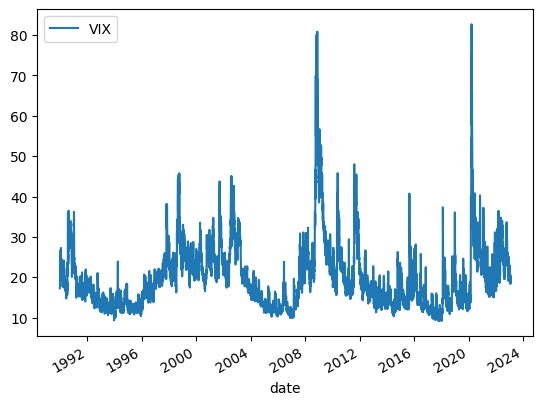

In [525]:
vix.plot()

In [446]:
# compare indexes of VIX and full dataframe

a = final_dataframe.index.unique()
b = final_dataframe.index.unique('date')
a.difference(b)

DatetimeIndex([], dtype='datetime64[ns]', name='date', freq=None)

In [447]:
# Merge VIX data

#full_df = pd.merge(final_dataframe, vix, left_index=True, right_index=True)

full_df = final_dataframe.merge(vix, on=['date'], how='left')

full_df

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
2007-03-31  WBC.AX              AUD                     NaN   
2006-03-31  WBC.AX              AUD                     NaN   
2005-03-31  WBC.AX              AUD                     NaN   
2004-03-31  WBC.AX              AUD                     NaN   
2003-03-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
2007-03-31                   NaN                          NaN             NaN   
2006-03-31                   NaN                          NaN             NaN   
2005-03-31                   NaN                          NaN             NaN   
2004-03-31                   NaN                          NaN             NaN   
2003-03-31                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
2007-03-31           NaN                 NaN                 NaN   
2006-03-31           NaN                 NaN                 NaN   
2005-03-31           NaN                 NaN                 NaN   
2004-03-31           NaN                 NaN                 NaN   
2003-03-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  otherFinancingActivites  \
date                                   ...                            
2023-01-31               1.147000e+09  ...                      NaN   
2022-10-31               1.100000e+09  ...            -1.440000e+08   
2022-10-31               1.100000e+09  ...            -1.440000e+08   
2022-10-31               1.100000e+09  ...            -1.440000e+08   
2022-10-31               1.100000e+09  ...            -1.440000e+08   
...                               ...  ...                      ...   
2007-03-31                        NaN  ...            -8.087495e+08   
2006-03-31                        NaN  ...             4.634681e+09   
2005-03-31                        NaN  ...             1.664582e+08   
2004-03-31                        NaN  ...             4.294656e+07   
2003-03-31                        NaN  ...            -9.227952e+07   

            netCashUsedProvidedByFinancingActivities  \
date                                                   
2023-01-31                                       NaN   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
2022-10-31                              -34100000

In [448]:
full_df.isnull().sum().sort_values(ascending=False)/len(full_df)

operatingCycle                  0.424204
cashConversionCycle             0.424204
VIX                             0.388061
othertotalStockholdersEquity    0.352503
netDebt                         0.350993
                                  ...   
netIncomeRatio                  0.036483
eps                             0.036483
epsdiluted                      0.036483
reportedCurrency                0.000000
symbol                          0.000000
Length: 159, dtype: float64

In [588]:
full_df.VIX

date
2023-01-31    19.40
2022-10-31    25.88
2022-10-31    25.88
2022-10-31    25.88
2022-10-31    25.88
              ...  
2007-03-31      NaN
2006-03-31    11.39
2005-03-31    14.02
2004-03-31    16.74
2003-03-31    29.15
Name: VIX, Length: 52984, dtype: float64

In [593]:
interpol_df=full_df

df_1 = df_1.sort_index(ascending=True)


interpol_df.VIX.resample('D').mean()

interpol_df['VIX'] = interpol_df['VIX'].interpolate()
interpol_df

KeyError: 'symbol'

<AxesSubplot:xlabel='date'>

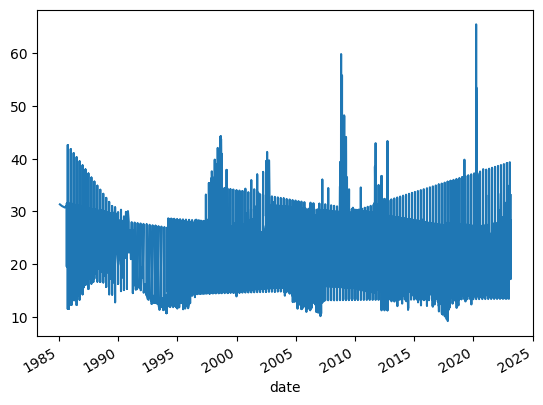

In [590]:
interpol_df.VIX.plot()

In [581]:
# Convert index and VIX into np arrays

x = full_df.index.values.astype(float)//10**16
y=new_df.VIX.to_numpy()


inds = np.argsort(x) # sort x so that it is increasing
x = x[inds]
y = y[inds]

spl=UnivariateSpline(x,y)

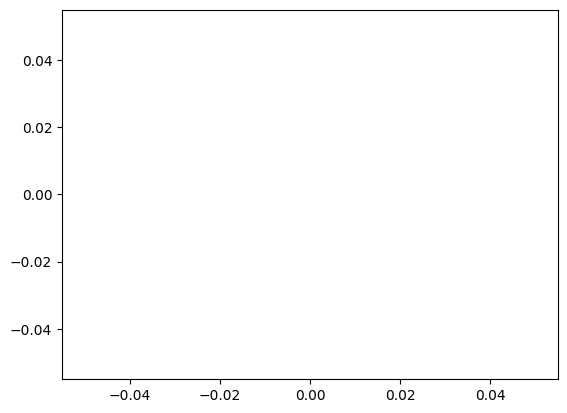

In [586]:
#plt.plot(x, y)

xx = np.linspace(x[0], x[-1], 300)
plt.plot(xx, spl(xx))

In [544]:
# Use Savgol Filter to smooth VIX data

vixhat = signal.savgol_filter(full_df.VIX, 5, 3, mode="nearest")


In [546]:
vixhat

array([21.06628571, 24.21371429, 26.43542857, ...,         nan,
       19.45714286, 26.192     ])

In [295]:
full_df

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                          
2023-01-31       A              USD            1.250000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
2022-10-31       A              USD            1.053000e+09   
...            ...              ...                     ...   
2007-03-31  WBC.AX              AUD                     NaN   
2006-03-31  WBC.AX              AUD                     NaN   
2005-03-31  WBC.AX              AUD                     NaN   
2004-03-31  WBC.AX              AUD                     NaN   
2003-03-31  WBC.AX              AUD                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
2007-03-31                   NaN                          NaN             NaN   
2006-03-31                   NaN                          NaN             NaN   
2005-03-31                   NaN                          NaN             NaN   
2004-03-31                   NaN                          NaN             NaN   
2003-03-31                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
2007-03-31           NaN                 NaN                 NaN   
2006-03-31           NaN                 NaN                 NaN   
2005-03-31           NaN                 NaN                 NaN   
2004-03-31           NaN                 NaN                 NaN   
2003-03-31           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  \
date                                   ...   
2023-01-31               1.147000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
...                               ...  ...   
2007-03-31                        NaN  ...   
2006-03-31                        NaN  ...   
2005-03-31                        NaN  ...   
2004-03-31                        NaN  ...   
2003-03-31                        NaN  ...   

            netCashUsedProvidedByFinancingActivities  \
date                                                   
2023-01-31                                       NaN   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
...                                              ...   
2007-03-31                                       0.0   
2006-03-31                                       0.0   
2005-03-31                                       0.0   
2004-03-31                            

<AxesSubplot:xlabel='date'>

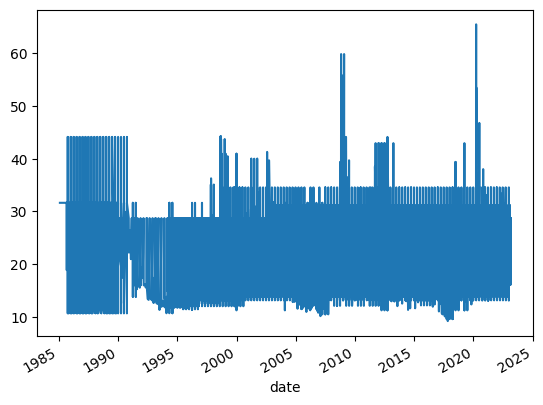

In [296]:
full_df.VIX_interpolated.plot()

In [449]:
# Merge equity closing prices by ticker and date

complete_df = full_df.merge(equity_prices, on=['date', 'symbol'], how='inner')

In [450]:
complete_df

symbol reportedCurrency  cashAndCashEquivalents  \
date                                                               
2023-01-31            A              USD            1.250000e+09   
2022-10-31            A              USD            1.053000e+09   
2022-10-31            A              USD            1.053000e+09   
2022-10-31            A              USD            1.053000e+09   
2022-10-31            A              USD            1.053000e+09   
...                 ...              ...                     ...   
2015-06-30  RELIANCE.NS              INR                     NaN   
2014-12-31  RELIANCE.NS              INR                     NaN   
2014-06-30  RELIANCE.NS              INR                     NaN   
2013-12-31  RELIANCE.NS              INR                     NaN   
2013-09-30  RELIANCE.NS              INR                     NaN   

            shortTermInvestments  cashAndShortTermInvestments  netReceivables  \
date                                                                            
2023-01-31                   0.0                 1.250000e+09    1.459000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
2022-10-31                   0.0                 1.053000e+09    1.405000e+09   
...                          ...                          ...             ...   
2015-06-30                   NaN                          NaN             NaN   
2014-12-31                   NaN                          NaN             NaN   
2014-06-30                   NaN                          NaN             NaN   
2013-12-31                   NaN                          NaN             NaN   
2013-09-30                   NaN                          NaN             NaN   

             inventory_x  otherCurrentAssets  totalCurrentAssets  \
date                                                               
2023-01-31  1.111000e+09         258000000.0        4.078000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
2022-10-31  1.038000e+09         282000000.0        3.778000e+09   
...                  ...                 ...                 ...   
2015-06-30           NaN                 NaN                 NaN   
2014-12-31           NaN                 NaN                 NaN   
2014-06-30           NaN                 NaN                 NaN   
2013-12-31           NaN                 NaN                 NaN   
2013-09-30           NaN                 NaN                 NaN   

            propertyPlantEquipmentNet  ...  \
date                                   ...   
2023-01-31               1.147000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
2022-10-31               1.100000e+09  ...   
...                               ...  ...   
2015-06-30                        NaN  ...   
2014-12-31                        NaN  ...   
2014-06-30                        NaN  ...   
2013-12-31                        NaN  ...   
2013-09-30                        NaN  ...   

            netCashUsedProvidedByFinancingActivities  \
date                                                   
2023-01-31                                       NaN   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
2022-10-31                              -341000000.0   
...                                              ...   
2015-06-30                                       0.0   
2014-12-31                                       NaN   
2014-06-30                        

In [451]:
print(complete_df.columns)

Index(['symbol', 'reportedCurrency', 'cashAndCashEquivalents',
       'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
       'inventory_x', 'otherCurrentAssets', 'totalCurrentAssets',
       'propertyPlantEquipmentNet',
       ...
       'netCashUsedProvidedByFinancingActivities',
       'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod',
       'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure',
       'freeCashFlow', 'VIX', 'equity_price'],
      dtype='object', length=160)


## Identify and remove repeated columns from merging

In [452]:
# Find repeated columns due to merging of dataframes

repeat_cols = [col for col in complete_df.columns if '_y' in col]
print(repeat_cols)

['netIncome_y', 'depreciationAndAmortization_y', 'inventory_y']


In [453]:
complete_df.drop(['netIncome_y', 'depreciationAndAmortization_y', 'inventory_y'], axis=1, inplace=True)


In [454]:
data=complete_df

# Check high level relationships between variables in financial statements and derive values if required

In [455]:
data['operatingIncomeRatio'] = data['operatingIncome']/data['revenue']

data['grossProfit'] = data['revenue'] - data['costOfRevenue']

data['grossProfitRatio'] = data['grossProfit']/data['revenue']

data['operatingIncome'] = data['grossProfit'] - data['operatingExpenses'] - data['depreciationAndAmortization_x']

data['operatingIncomeRatio'] = data['operatingIncome']/data['revenue']


# One Hot Encode Categorical Columns

## OHE the ticker symbol

In [456]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse = False) 

# Fit encoder
ohe.fit(data[['symbol']]) 


OneHotEncoder(sparse=False)

In [457]:
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

The categories detected by the OneHotEncoder are [array(['1288.HK', 'A', 'AAL.L', 'AAPL', 'ABB', 'ABBV', 'ABC', 'ABI.BR',
       'ABT', 'AC.PA', 'ACA.PA', 'ACE.MI', 'AD.AS', 'ADEN.SW', 'ADL.DE',
       'ADM', 'ADP', 'ADS.DE', 'AES', 'AET', 'AFG', 'AGN.AS', 'AGR',
       'AGS.BR', 'AI.PA', 'AIG', 'AIR.DE', 'AKZA.AS', 'ALL', 'ALLY',
       'ALO.PA', 'ALV.DE', 'AMAT', 'AMGN', 'AMP', 'AMT', 'AMX', 'AMZN',
       'AN', 'ANTM', 'ANZ.AX', 'APD', 'ARW', 'ASML', 'AU', 'AV.L', 'AVB',
       'AVT', 'AVY', 'AXP', 'AZN', 'AZO', 'BA', 'BA.L', 'BABA', 'BAC',
       'BARC.L', 'BAS.DE', 'BAX', 'BAYN.DE', 'BBD-B.TO', 'BBVA', 'BBY',
       'BDX', 'BIDU', 'BK', 'BLL', 'BMO', 'BMY', 'BN', 'BNS', 'BSX',
       'BTI', 'BWA', 'C', 'CAG', 'CAH', 'CAR', 'CAT', 'CB', 'CCB', 'CCI',
       'CI', 'CL', 'CLX', 'CM', 'CMCSA', 'CMI', 'CNA', 'CNHI', 'CNP',
       'COF', 'COP', 'COST', 'CPB', 'CPT', 'CS', 'CS.PA', 'CSCO', 'CSTM',
       'CSX', 'CTVA', 'CVS', 'CVX', 'D', 'DAL', 'DB', 'DE', 'DGX', 'DHI',
       'DHR', 'DO

In [458]:
# Display the generated names
print(f"The column names for the encoded values are {ohe.get_feature_names_out()}")

# Transform the current "symbol" column
data[ohe.get_feature_names_out()] = ohe.transform(data[['symbol']])

# Drop the column "symbol" which has been encoded
data.drop(columns = ["symbol"], inplace = True)

# Show the dataset
data.head(3)

The column names for the encoded values are ['symbol_1288.HK' 'symbol_A' 'symbol_AAL.L' 'symbol_AAPL' 'symbol_ABB'
 'symbol_ABBV' 'symbol_ABC' 'symbol_ABI.BR' 'symbol_ABT' 'symbol_AC.PA'
 'symbol_ACA.PA' 'symbol_ACE.MI' 'symbol_AD.AS' 'symbol_ADEN.SW'
 'symbol_ADL.DE' 'symbol_ADM' 'symbol_ADP' 'symbol_ADS.DE' 'symbol_AES'
 'symbol_AET' 'symbol_AFG' 'symbol_AGN.AS' 'symbol_AGR' 'symbol_AGS.BR'
 'symbol_AI.PA' 'symbol_AIG' 'symbol_AIR.DE' 'symbol_AKZA.AS' 'symbol_ALL'
 'symbol_ALLY' 'symbol_ALO.PA' 'symbol_ALV.DE' 'symbol_AMAT' 'symbol_AMGN'
 'symbol_AMP' 'symbol_AMT' 'symbol_AMX' 'symbol_AMZN' 'symbol_AN'
 'symbol_ANTM' 'symbol_ANZ.AX' 'symbol_APD' 'symbol_ARW' 'symbol_ASML'
 'symbol_AU' 'symbol_AV.L' 'symbol_AVB' 'symbol_AVT' 'symbol_AVY'
 'symbol_AXP' 'symbol_AZN' 'symbol_AZO' 'symbol_BA' 'symbol_BA.L'
 'symbol_BABA' 'symbol_BAC' 'symbol_BARC.L' 'symbol_BAS.DE' 'symbol_BAX'
 'symbol_BAYN.DE' 'symbol_BBD-B.TO' 'symbol_BBVA' 'symbol_BBY'
 'symbol_BDX' 'symbol_BIDU' 'symbol_BK' 'symbol_B

/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_6166/2990622154.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names_out()] = ohe.transform(data[['symbol']])
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_6166/2990622154.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[ohe.get_feature_names_out()] = ohe.transform(data[['symbol']])
/var/folders/q5/yf8g5p896_b94gkbhqcjx3t40000gn/T/ipykernel_6166/2990622154.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is us

reportedCurrency  cashAndCashEquivalents  shortTermInvestments  \
date                                                                        
2023-01-31              USD            1.250000e+09                   0.0   
2022-10-31              USD            1.053000e+09                   0.0   
2022-10-31              USD            1.053000e+09                   0.0   

            cashAndShortTermInvestments  netReceivables   inventory_x  \
date                                                                    
2023-01-31                 1.250000e+09    1.459000e+09  1.111000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31         258000000.0        4.078000e+09               1.147000e+09   
2022-10-31         282000000.0        3.778000e+09               1.100000e+09   
2022-10-31         282000000.0        3.778000e+09               1.100000e+09   

                goodwill  ...  symbol_WELL  symbol_WFC  symbol_WHR  symbol_WM  \
date                      ...                                                   
2023-01-31  3.983000e+09  ...          0.0         0.0         0.0        0.0   
2022-10-31  3.952000e+09  ...          0.0         0.0         0.0        0.0   
2022-10-31  3.952000e+09  ...          0.0         0.0         0.0        0.0   

            symbol_WMB  symbol_WMT  symbol_WU  symbol_WY  symbol_XL  \
date                                                                  
2023-01-31         0.0         0.0        0.0        0.0        0.0   
2022-10-31         0.0         0.0        0.0        0.0        0.0   
2022-10-31         0.0         0.0        0.0        0.0        0.0   

            symbol_XOM  
date                    
2023-01-31         0.0  
2022-10-31         0.0  
2022-10-31         0.0  

[3 rows x 460 columns]

## OHE the reported currency

In [459]:
# Instantiate the OneHotEncoder
ohe = OneHotEncoder(sparse = False) 

# Fit encoder
ohe.fit(data[['reportedCurrency']]) 


OneHotEncoder(sparse=False)

In [460]:
print(f"The categories detected by the OneHotEncoder are {ohe.categories_}")

The categories detected by the OneHotEncoder are [array(['AUD', 'CAD', 'CHF', 'CNY', 'EUR', 'GBP', 'INR', 'KRW', 'MXN',
       'USD'], dtype=object)]


In [461]:
# Display the generated names
print(f"The column names for the encoded values are {ohe.get_feature_names_out()}")

# Transform the current "symbol" column
data[ohe.get_feature_names_out()] = ohe.transform(data[['reportedCurrency']])

# Drop the column "reportedCurrency_x" which has been encoded
data.drop(columns = ["reportedCurrency"], inplace = True)

# Show the dataset
data.head(3)

The column names for the encoded values are ['reportedCurrency_AUD' 'reportedCurrency_CAD' 'reportedCurrency_CHF'
 'reportedCurrency_CNY' 'reportedCurrency_EUR' 'reportedCurrency_GBP'
 'reportedCurrency_INR' 'reportedCurrency_KRW' 'reportedCurrency_MXN'
 'reportedCurrency_USD']


cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31            1.250000e+09                   0.0   
2022-10-31            1.053000e+09                   0.0   
2022-10-31            1.053000e+09                   0.0   

            cashAndShortTermInvestments  netReceivables   inventory_x  \
date                                                                    
2023-01-31                 1.250000e+09    1.459000e+09  1.111000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31         258000000.0        4.078000e+09               1.147000e+09   
2022-10-31         282000000.0        3.778000e+09               1.100000e+09   
2022-10-31         282000000.0        3.778000e+09               1.100000e+09   

                goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                        ...                         
2023-01-31  3.983000e+09       810000000.0  ...                   0.0   
2022-10-31  3.952000e+09       821000000.0  ...                   0.0   
2022-10-31  3.952000e+09       821000000.0  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   

            reportedCurrency_EUR  reportedCurrency_GBP  reportedCurrency_INR  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   

            reportedCurrency_KRW  reportedCurrency_MXN  reportedCurrency_USD  
date                                                                          
2023-01-31                   0.0                   0.0                   1.0  
2022-10-31                   0.0                   0.0                   1.0  
2022-10-31                   0.0                   0.0                   1.0  

[3 rows x 469 columns]

# Impute missing values using MICEforest

In [549]:
#df_amp = mf.ampute_data(data,perc=0.25,random_state=1991)  # ampute introduces missing values

In [463]:
# check there are no non-numeric columns

data.select_dtypes(exclude=['number']).columns

Index([], dtype='object')

In [464]:
# Create kernel. 
kernel = mf.ImputationKernel(
    data,
    datasets=3,
    save_all_iterations=True,
    random_state=1
)

In [465]:
kernel.mice(2)

In [466]:
print(kernel)


              Class: ImputationKernel
           Datasets: 3
         Iterations: 2
       Data Samples: 22551
       Data Columns: 469
  Imputed Variables: 154
save_all_iterations: True


In [496]:
# Access fully imputed and complete dataset

imputed_dataset = kernel.complete_data(dataset=1)
print(imputed_dataset.isnull().sum(0))

cashAndCashEquivalents         0
shortTermInvestments           0
cashAndShortTermInvestments    0
netReceivables                 0
inventory_x                    0
                              ..
reportedCurrency_GBP           0
reportedCurrency_INR           0
reportedCurrency_KRW           0
reportedCurrency_MXN           0
reportedCurrency_USD           0
Length: 469, dtype: int64


In [497]:
imputed_dataset

cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31            1.250000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
...                            ...                   ...   
2015-06-30            1.365180e+11          4.516430e+11   
2014-12-31            2.048430e+11          2.826440e+11   
2014-06-30            7.142100e+10          3.370000e+09   
2013-12-31            1.596610e+11          4.172050e+11   
2013-09-30            1.501330e+11          1.776760e+11   

            cashAndShortTermInvestments  netReceivables   inventory_x  \
date                                                                    
2023-01-31                 1.250000e+09    1.459000e+09  1.111000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
...                                 ...             ...           ...   
2015-06-30                 5.595500e+11    1.561690e+11  5.599700e+11   
2014-12-31                 4.973110e+11    1.428040e+11  7.223100e+11   
2014-06-30                 1.296090e+11    1.041840e+11  5.599700e+11   
2013-12-31                 5.455670e+11    4.561300e+10  5.599700e+11   
2013-09-30                 3.574480e+11    1.431990e+11  6.233000e+11   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31        2.580000e+08        4.078000e+09               1.147000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
...                        ...                 ...                        ...   
2015-06-30        7.554172e+11        1.493870e+12               4.569395e+12   
2014-12-31        7.163300e+11        1.339936e+12               3.677020e+12   
2014-06-30        5.925500e+11        1.177799e+12               2.716800e+12   
2013-12-31        6.851510e+11        1.078042e+12               3.677020e+12   
2013-09-30        4.954640e+11        1.265870e+12               4.177510e+12   

                goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                        ...                         
2023-01-31  3.983000e+09      8.100000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
...                  ...               ...  ...                   ...   
2015-06-30  1.332470e+11      1.414400e+12  ...                   0.0   
2014-12-31  9.349600e+10      1.371100e+12  ...                   0.0   
2014-06-30  1.543550e+11      1.007200e+12  ...                   0.0   
2013-12-31  9.603000e+10      1.233440e+12  ...                   0.0   
2013-09-30  1.463700e+11      1.414400e+12  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0     

In [498]:
imputed_dataset.totalAssets

date
2023-01-31    1.091900e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
                  ...     
2015-06-30    1.226649e+13
2014-12-31    3.386071e+12
2014-06-30    1.457429e+12
2013-12-31    2.557261e+12
2013-09-30    1.669058e+12
Name: totalAssets, Length: 22551, dtype: float64

# Normalize & scale variables

## Normalize and scale balance sheet variables

In [499]:
# inventory column changed to inventory_x

bs_columns = ['cashAndCashEquivalents', 'shortTermInvestments', 'cashAndShortTermInvestments', 'netReceivables',
             'inventory_x', 'otherCurrentAssets', 'totalCurrentAssets',
             'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
             'goodwillAndIntangibleAssets', 'longTermInvestments', 'taxAssets',
             'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
             'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
             'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
             'longTermDebt', 'deferredRevenueNonCurrent',
              'deferredTaxLiabilitiesNonCurrent', 'otherNonCurrentLiabilities',
              'totalNonCurrentLiabilities', 'otherLiabilities',
              'capitalLeaseObligations', 'totalLiabilities', 'preferredStock', 'commonStock', 'retainedEarnings',
              'accumulatedOtherComprehensiveIncomeLoss',
              'othertotalStockholdersEquity', 'totalStockholdersEquity',
              'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
              'minorityInterest', 'totalLiabilitiesAndTotalEquity', 'totalInvestments', 'totalDebt', 'netDebt']


In [500]:
normalized_dataset=imputed_dataset

In [502]:
normalized_dataset.totalAssets

date
2023-01-31    1.091900e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
2022-10-31    1.053200e+10
                  ...     
2015-06-30    1.226649e+13
2014-12-31    3.386071e+12
2014-06-30    1.457429e+12
2013-12-31    2.557261e+12
2013-09-30    1.669058e+12
Name: totalAssets, Length: 22551, dtype: float64

In [503]:
normalized_dataset[normalized_dataset['totalAssets'] > 0]


cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31            1.250000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
2022-10-31            1.053000e+09          0.000000e+00   
...                            ...                   ...   
2015-06-30            1.365180e+11          4.516430e+11   
2014-12-31            2.048430e+11          2.826440e+11   
2014-06-30            7.142100e+10          3.370000e+09   
2013-12-31            1.596610e+11          4.172050e+11   
2013-09-30            1.501330e+11          1.776760e+11   

            cashAndShortTermInvestments  netReceivables   inventory_x  \
date                                                                    
2023-01-31                 1.250000e+09    1.459000e+09  1.111000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
2022-10-31                 1.053000e+09    1.405000e+09  1.038000e+09   
...                                 ...             ...           ...   
2015-06-30                 5.595500e+11    1.561690e+11  5.599700e+11   
2014-12-31                 4.973110e+11    1.428040e+11  7.223100e+11   
2014-06-30                 1.296090e+11    1.041840e+11  5.599700e+11   
2013-12-31                 5.455670e+11    4.561300e+10  5.599700e+11   
2013-09-30                 3.574480e+11    1.431990e+11  6.233000e+11   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31        2.580000e+08        4.078000e+09               1.147000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
2022-10-31        2.820000e+08        3.778000e+09               1.100000e+09   
...                        ...                 ...                        ...   
2015-06-30        7.554172e+11        1.493870e+12               4.569395e+12   
2014-12-31        7.163300e+11        1.339936e+12               3.677020e+12   
2014-06-30        5.925500e+11        1.177799e+12               2.716800e+12   
2013-12-31        6.851510e+11        1.078042e+12               3.677020e+12   
2013-09-30        4.954640e+11        1.265870e+12               4.177510e+12   

                goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                        ...                         
2023-01-31  3.983000e+09      8.100000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
2022-10-31  3.952000e+09      8.210000e+08  ...                   0.0   
...                  ...               ...  ...                   ...   
2015-06-30  1.332470e+11      1.414400e+12  ...                   0.0   
2014-12-31  9.349600e+10      1.371100e+12  ...                   0.0   
2014-06-30  1.543550e+11      1.007200e+12  ...                   0.0   
2013-12-31  9.603000e+10      1.233440e+12  ...                   0.0   
2013-09-30  1.463700e+11      1.414400e+12  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0     

In [504]:
# Divide all BS values by total assets

normalized_dataset[bs_columns]=normalized_dataset[bs_columns].div(normalized_dataset['totalAssets'].values,axis=0)

In [505]:
# remove any rows containing infinite values from total assets=0

normalized_dataset = normalized_dataset[normalized_dataset['totalAssets'] > 0]

In [506]:
normalized_dataset

cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31                0.114479              0.000000   
2022-10-31                0.099981              0.000000   
2022-10-31                0.099981              0.000000   
2022-10-31                0.099981              0.000000   
2022-10-31                0.099981              0.000000   
...                            ...                   ...   
2015-06-30                0.011129              0.036819   
2014-12-31                0.060496              0.083473   
2014-06-30                0.049005              0.002312   
2013-12-31                0.062434              0.163145   
2013-09-30                0.089951              0.106453   

            cashAndShortTermInvestments  netReceivables  inventory_x  \
date                                                                   
2023-01-31                     0.114479        0.133620     0.101749   
2022-10-31                     0.099981        0.133403     0.098557   
2022-10-31                     0.099981        0.133403     0.098557   
2022-10-31                     0.099981        0.133403     0.098557   
2022-10-31                     0.099981        0.133403     0.098557   
...                                 ...             ...          ...   
2015-06-30                     0.045616        0.012731     0.045650   
2014-12-31                     0.146870        0.042174     0.213318   
2014-06-30                     0.088930        0.071485     0.384218   
2013-12-31                     0.213340        0.017837     0.218973   
2013-09-30                     0.214162        0.085796     0.373444   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31            0.023629            0.373477                   0.105046   
2022-10-31            0.026776            0.358716                   0.104444   
2022-10-31            0.026776            0.358716                   0.104444   
2022-10-31            0.026776            0.358716                   0.104444   
2022-10-31            0.026776            0.358716                   0.104444   
...                        ...                 ...                        ...   
2015-06-30            0.061584            0.121785                   0.372510   
2014-12-31            0.211552            0.395720                   1.085925   
2014-06-30            0.406572            0.808135                   1.864105   
2013-12-31            0.267924            0.421561                   1.437874   
2013-09-30            0.296852            0.758434                   2.502915   

            goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                    ...                         
2023-01-31  0.364777          0.074183  ...                   0.0   
2022-10-31  0.375237          0.077953  ...                   0.0   
2022-10-31  0.375237          0.077953  ...                   0.0   
2022-10-31  0.375237          0.077953  ...                   0.0   
2022-10-31  0.375237          0.077953  ...                   0.0   
...              ...               ...  ...                   ...   
2015-06-30  0.010863          0.115306  ...                   0.0   
2014-12-31  0.027612          0.404924  ...                   0.0   
2014-06-30  0.105909          0.691080  ...                   0.0   
2013-12-31  0.037552          0.482329  ...                   0.0   
2013-09-30  0.087696          0.847424  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   
2022-10-31            

In [507]:
# Initialise and fit Robust Scaler
# Use RS because data appears to have some very extreme min/max values
# Note [[]] usage otherwise you will get an error with data type

scaled_dataset=normalized_dataset
rb_scaler = RobustScaler() 
scaled_dataset[bs_columns] = rb_scaler.fit_transform(scaled_dataset[bs_columns])


In [508]:
scaled_dataset

cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31                0.907260             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
...                            ...                   ...   
2015-06-30               -0.427947              0.883111   
2014-12-31                0.209832              2.015373   
2014-06-30                0.061377              0.045637   
2013-12-31                0.234877              3.949007   
2013-09-30                0.590368              2.573099   

            cashAndShortTermInvestments  netReceivables  inventory_x  \
date                                                                   
2023-01-31                     0.371199        0.656723     1.156172   
2022-10-31                     0.262436        0.654921     1.116022   
2022-10-31                     0.262436        0.654921     1.116022   
2022-10-31                     0.262436        0.654921     1.116022   
2022-10-31                     0.262436        0.654921     1.116022   
...                                 ...             ...          ...   
2015-06-30                    -0.145394       -0.345458     0.450646   
2014-12-31                     0.614182       -0.101376     2.559315   
2014-06-30                     0.179534        0.141614     4.708632   
2013-12-31                     1.112827       -0.303134     2.630429   
2013-09-30                     1.118987        0.260257     4.573139   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31            0.081338            0.359034                  -0.057832   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
...                        ...                 ...                        ...   
2015-06-30            0.819211           -0.276926                   0.695342   
2014-12-31            3.734681            0.415235                   2.704307   
2014-06-30            7.525989            1.457297                   4.895648   
2013-12-31            4.830583            0.480529                   3.695390   
2013-09-30            5.392974            1.331716                   6.694527   

            goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                    ...                         
2023-01-31  2.755256          0.685610  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
...              ...               ...  ...                   ...   
2015-06-30 -0.009230          1.147804  ...                   0.0   
2014-12-31  0.121602          4.402878  ...                   0.0   
2014-06-30  0.733194          7.619050  ...                   0.0   
2013-12-31  0.199244          5.272849  ...                   0.0   
2013-09-30  0.590930          9.376235  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   
2022-10-31            

In [509]:
scaled_dataset.accountsPayables

date
2023-01-31    0.000000e+00
2022-10-31    1.100000e+07
2022-10-31    1.100000e+07
2022-10-31    1.100000e+07
2022-10-31    1.100000e+07
                  ...     
2015-06-30    0.000000e+00
2014-12-31   -2.242000e+09
2014-06-30    0.000000e+00
2013-12-31    0.000000e+00
2013-09-30    0.000000e+00
Name: accountsPayables, Length: 22551, dtype: float64

## Normalize and scale income statement variables

In [510]:
# Define columns to normalize in income statement
# depreciationAndAmortization = depreciationAndAmortization_x
# netIncome = netIncome_x

is_columns =['revenue', 'costOfRevenue', 'grossProfit', 'researchAndDevelopmentExpenses', 
              'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses', 
              'sellingGeneralAndAdministrativeExpenses', 'otherExpenses', 'operatingExpenses', 'costAndExpenses', 
              'interestIncome', 'interestExpense', 'depreciationAndAmortization_x', 
              'ebitda', 'operatingIncome', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
              'incomeBeforeTaxRatio', 'incomeTaxExpense', 'netIncome_x', 'eps', 'epsdiluted',
              'weightedAverageShsOut', 'weightedAverageShsOutDil']


In [511]:
# Divide all income statement values by revenue

scaled_dataset[is_columns] = scaled_dataset[is_columns].div(scaled_dataset['revenue'].values,axis=0)

In [512]:
scaled_dataset

cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31                0.907260             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
...                            ...                   ...   
2015-06-30               -0.427947              0.883111   
2014-12-31                0.209832              2.015373   
2014-06-30                0.061377              0.045637   
2013-12-31                0.234877              3.949007   
2013-09-30                0.590368              2.573099   

            cashAndShortTermInvestments  netReceivables  inventory_x  \
date                                                                   
2023-01-31                     0.371199        0.656723     1.156172   
2022-10-31                     0.262436        0.654921     1.116022   
2022-10-31                     0.262436        0.654921     1.116022   
2022-10-31                     0.262436        0.654921     1.116022   
2022-10-31                     0.262436        0.654921     1.116022   
...                                 ...             ...          ...   
2015-06-30                    -0.145394       -0.345458     0.450646   
2014-12-31                     0.614182       -0.101376     2.559315   
2014-06-30                     0.179534        0.141614     4.708632   
2013-12-31                     1.112827       -0.303134     2.630429   
2013-09-30                     1.118987        0.260257     4.573139   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31            0.081338            0.359034                  -0.057832   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
...                        ...                 ...                        ...   
2015-06-30            0.819211           -0.276926                   0.695342   
2014-12-31            3.734681            0.415235                   2.704307   
2014-06-30            7.525989            1.457297                   4.895648   
2013-12-31            4.830583            0.480529                   3.695390   
2013-09-30            5.392974            1.331716                   6.694527   

            goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                    ...                         
2023-01-31  2.755256          0.685610  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
...              ...               ...  ...                   ...   
2015-06-30 -0.009230          1.147804  ...                   0.0   
2014-12-31  0.121602          4.402878  ...                   0.0   
2014-06-30  0.733194          7.619050  ...                   0.0   
2013-12-31  0.199244          5.272849  ...                   0.0   
2013-09-30  0.590930          9.376235  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   
2022-10-31            

In [513]:
# Initialise and fit Robust Scaler
# Use RS because data appears to have some very extreme min/max values
# Note [[]] usage otherwise you will get an error with data type

rb_scaler = RobustScaler() 
scaled_dataset[is_columns] = rb_scaler.fit_transform(scaled_dataset[is_columns])


## Normalize and scale cashflow statement variables

In [514]:
# netIncome = netIncome_x

cf_columns = ['netIncome_x', 'depreciationAndAmortization_x', 'deferredIncomeTax', 'stockBasedCompensation', 
              'changeInWorkingCapital', 'accountsReceivables', 'inventory_x', 'accountsPayables', 'otherWorkingCapital',
              'otherNonCashItems', 'netCashProvidedByOperatingActivities', 'investmentsInPropertyPlantAndEquipment', 
              'acquisitionsNet', 'purchasesOfInvestments', 'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites', 'debtRepayment',
              'commonStockIssued', 'commonStockRepurchased', 'dividendsPaid', 'otherFinancingActivites', 
              'netCashUsedProvidedByFinancingActivities', 'effectOfForexChangesOnCash', 'netChangeInCash', 
              'cashAtEndOfPeriod', 'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 
              'freeCashFlow']


In [517]:
# Remove all zero income rows

sanitized_dataset = scaled_dataset[scaled_dataset['netIncome_x'] != 0]

In [518]:
# Divide all income statement values by net income

sanitized_dataset[cf_columns] = sanitized_dataset[cf_columns].div(sanitized_dataset['netIncome_x'].values,axis=0)

In [520]:
# Initialise and fit Robust Scaler
# Use RS because data appears to have some very extreme min/max values
# Note [[]] usage otherwise you will get an error with data type

rb_scaler = RobustScaler() 
sanitized_dataset[cf_columns] = rb_scaler.fit_transform(sanitized_dataset[cf_columns])

In [521]:
sanitized_dataset

cashAndCashEquivalents  shortTermInvestments  \
date                                                       
2023-01-31                0.907260             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
2022-10-31                0.719952             -0.010482   
...                            ...                   ...   
2015-06-30               -0.427947              0.883111   
2014-12-31                0.209832              2.015373   
2014-06-30                0.061377              0.045637   
2013-12-31                0.234877              3.949007   
2013-09-30                0.590368              2.573099   

            cashAndShortTermInvestments  netReceivables  inventory_x  \
date                                                                   
2023-01-31                     0.371199        0.656723     1.146085   
2022-10-31                     0.262436        0.654921     1.119552   
2022-10-31                     0.262436        0.654921     1.119552   
2022-10-31                     0.262436        0.654921     1.119552   
2022-10-31                     0.262436        0.654921     1.119552   
...                                 ...             ...          ...   
2015-06-30                    -0.145394       -0.345458     6.012371   
2014-12-31                     0.614182       -0.101376   -20.914446   
2014-06-30                     0.179534        0.141614   -40.467644   
2013-12-31                     1.112827       -0.303134   -13.145564   
2013-09-30                     1.118987        0.260257   -27.628023   

            otherCurrentAssets  totalCurrentAssets  propertyPlantEquipmentNet  \
date                                                                            
2023-01-31            0.081338            0.359034                  -0.057832   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
2022-10-31            0.142518            0.321737                  -0.059529   
...                        ...                 ...                        ...   
2015-06-30            0.819211           -0.276926                   0.695342   
2014-12-31            3.734681            0.415235                   2.704307   
2014-06-30            7.525989            1.457297                   4.895648   
2013-12-31            4.830583            0.480529                   3.695390   
2013-09-30            5.392974            1.331716                   6.694527   

            goodwill  intangibleAssets  ...  reportedCurrency_AUD  \
date                                    ...                         
2023-01-31  2.755256          0.685610  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
2022-10-31  2.836963          0.727985  ...                   0.0   
...              ...               ...  ...                   ...   
2015-06-30 -0.009230          1.147804  ...                   0.0   
2014-12-31  0.121602          4.402878  ...                   0.0   
2014-06-30  0.733194          7.619050  ...                   0.0   
2013-12-31  0.199244          5.272849  ...                   0.0   
2013-09-30  0.590930          9.376235  ...                   0.0   

            reportedCurrency_CAD  reportedCurrency_CHF  reportedCurrency_CNY  \
date                                                                           
2023-01-31                   0.0                   0.0                   0.0   
2022-10-31                   0.0                   0.0                   0.0   
2022-10-31            

# KMV Distance to Default Calculator

## Calculate annualized volatility

In [ ]:
# Apply adjusted DTD taken from "Measuring Distance-to-Default for Financial and Non-Financial Firms", Jin-Chuan Duan & Tao Wang, 2012
# DTD = ln(Vt/F)/sigma*sqrt(T-t)


# Calculate annualized volatility

TRADING_DAYS = 252
data['returns'] = np.log(data['equity_price']/data['equity_price'].shift(1))
data['returns'].fillna(0, inplace=True)
data['volatility'] = data['returns'].rolling(window=TRADING_DAYS).std()*np.sqrt(TRADING_DAYS)

data

## Expected return after 1 year

In [17]:
# Calculate expected return after 1 year

# Import stock portfolio from excel
df = pd.read_excel("Stock_Portfolio.xlsx")

# Calculate beta for each individual stock
for i in range(len(df)):
    x = df.loc[i, "Stock"]
    ticker = yf.Ticker(x)
    stock_beta = ticker.info["beta"]
    df.at[i, "Beta"]= round(stock_beta,2)
    
    
# find the risk free rate (10 year treasury bill)
treasury_yield10 = yf.Ticker("^TNX") 
risk_free_rate_prem = round(treasury_yield10.info['regularMarketPrice']/100,2)
risk_free_rate_prem

# assume 10 percent return on the return of market ( average return of the S&P 500)
sp500_teturn = 0.10

# Caclulate the portfolio beta
portfolio_beta = round(sum(df["Beta"]* df["stock_weight"]/100),2)
portfolio_beta

# Calculate the expected return of the portfolio
portfolio_exp_return = round(risk_free_rate_prem + portfolio_beta *(sp500_teturn - risk_free_rate_prem),2)

#calulate the expected return for each individual stock using CAPM forumla
df["exp_return"]= round(risk_free_rate_prem + df["Beta"]*(sp500_teturn - risk_free_rate_prem),2)

FileNotFoundError: [Errno 2] No such file or directory: 'Stock_Portfolio.xlsx'

In [11]:
enterprise_value=7.9
short_term_debt=5.0
long_term_debt=5.0
mu=0.1
sigma=0.1

kmv(enterprise_value, short_term_debt, long_term_debt, mu, sigma, period=1)

0.07083541388671619